In [3]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.4

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.1.3         magrittr_2.0.3          presto_1.0.0           
 [4] harmony_1.2.0           Rcpp_1.0.12             ggrepel_0.9.4          
 [7] ggridges_0.5.5          ggpubr_0.6.0            Biostrings_2.70.1      
[10] GenomeInfoDb_1.38.2     XVector_0.42.0          IRanges_2.36.0         
[13] S4Vectors_0.40.2        BiocGenerics_0.48.1     lubridate_1.9.3        
[16] forcats_

# Load Libraries

In [2]:
suppressPackageStartupMessages({
    library(MASS)
    library(gdata)
    library(singlecellmethods) # github install
    library(matrixStats)
    library(data.table)
    library(viridis)
    library(RColorBrewer)
   library(pheatmap)
    library(Matrix)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(dendsort)
    library(tidyverse)
    library(Biostrings)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
    library(harmony) #github install immunogenomics
    library(presto) #github install immunogenomics
    source("utils.R") #extra functions 
    source("misc_funcs.R") #extra functions #2
})


# Load FlowIndex Data, Load RNA counts, Load ADT counts, Load DNA allele matrices

In [44]:
rownames(alleles_DNA$cell) %in% FlowMatrix$cell

Warning message:
“Unknown or uninitialised column: `cell`.”


logical(0)

In [4]:
FlowMatrix <- read_csv("Github_Data/FBXO11_FlowMatrix.csv")

Rows: 1536 Columns: 21
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Well_ID, DNA_Barcode, RNA_cell, Experiment_Index, Plate, CellType_...
dbl  (9): PB_CD45, BV605_CD45, SSC, FSC, FITC_DQB1, PE_CD40, PECY7_CD45, APC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [46]:
#Read in RNA counts merged from different plates. Colnames == cells, rownames == genes
exprs <- readMM("Github_Data/FBXO11_RNA_counts.txt")
colnames(exprs) <- read.csv("Github_Data/FBXO11_RNA_counts_colnames.txt")[,2]
rownames(exprs) <- read.csv("Github_Data/FBXO11_RNA_counts_rownames.txt")[,2]

In [7]:
#Read in adt counts merged from different plates. Colnames == cells, rownames == genes
counts_ADT <- readMM("Github_Data/FBXO11_adt_counts.txt")
colnames(counts_ADT) <- read.csv("Github_Data/FBXO11_adt_counts_colnames.txt")[,2]
rownames(counts_ADT) <- read.csv("Github_Data/FBXO11_adt_counts_rownames.txt")[,2]

In [8]:
# Load DNA alleles calculated from top two CRISPResso alleles
alleles_DNA <- read_csv("Github_Data/FBXO11_alleles_dna.csv")

Rows: 3052 Columns: 11
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (6): Barcode_DNA, Well_ID, Aligned_Sequence, PlateLabel, MainCondition, ...
dbl (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [50]:
#Read in meta file RNA
meta <- read_csv("Github_Data/FBXO11_meta.csv")
rownames(meta) <- meta$cell

Rows: 1536 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): plate, cell, MainCondition, ADT, cell_ADT

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Setting row names on a tibble is deprecated.”


In [31]:
#Read in meta file ADT
meta_ADT <-  read_csv("Github_Data/FBXO11_meta_adt.csv")
rownames(meta_ADT) <- meta_ADT$cell

Rows: 1536 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): plate, cell_adt, MainCondition, RNA, cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Setting row names on a tibble is deprecated.”


In [32]:
meta_DNA <- read_csv("Github_Data/FBXO11_meta_dna.csv")

Rows: 4 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): PlateLabel, MainCondition, Barcode_DNA, Reference

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


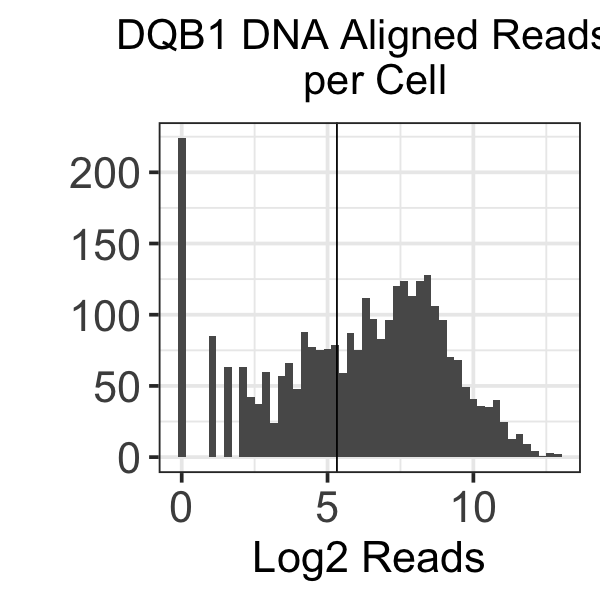

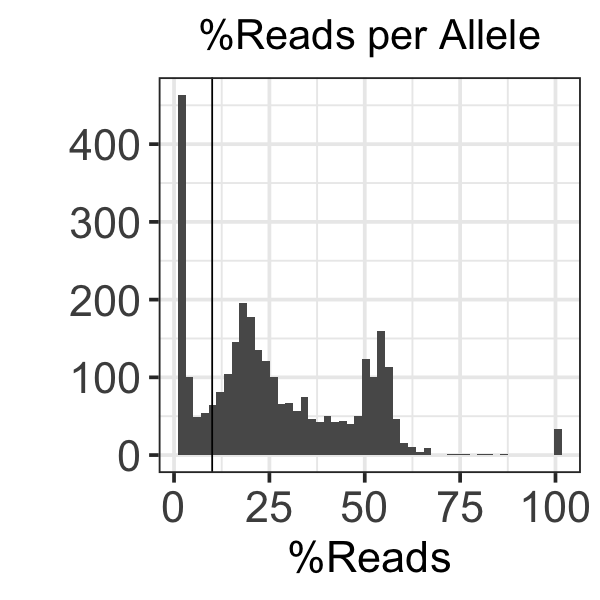

In [54]:
### DNA reads
fig.size(5,5)
DQB1_alleles_DNA %>%  
    ggplot(aes(log2(`#Reads`))) + 
    geom_histogram(bins = 50) + theme_gy() + geom_vline(xintercept = log2(40)) + 
    xlab("Log2 Reads") + ylab("") + ggtitle("DQB1 DNA Aligned Reads \n per Cell")

## AlleleFreq
fig.size(5,5) 
DQB1_alleles_DNA %>% 
    ggplot(aes((`%Reads`))) + 
    geom_histogram(bins = 50) + theme_gy() + geom_vline(xintercept = (10)) + 
    xlab("%Reads") + ylab("") + ggtitle("%Reads per Allele")

In [55]:
## DNA analysis, filter and identify deletion in allele 1 and allele 2

In [56]:
#Filter alleles on Reads # and Allele Freq
DQB1_alleles_DNA_filt <- DQB1_alleles_DNA %>% mutate("Plate_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% 
    FilterAlleles(12,40) 
#Merge with MetaData
DQB1_alleles_DNA_filt<- separate(DQB1_alleles_DNA_filt, Plate_Well, into = c("Barcode_DNA", "Well_ID")) %>% 
    inner_join(select(meta_DNA, -Reference))

Joining with `by = join_by(Plate_Well, Reference)`
Joining with `by = join_by(Barcode_DNA)`


In [57]:
#Fix lengths.
DQB1_alleles_DNA_filt<- mutate(DQB1_alleles_DNA_filt, 
           "Allele1" = str_trunc(Allele1, 180, "left", ellipsis = "")) %>% 
    mutate("Allele2" = str_trunc(Allele2, 180, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 180, "left", ellipsis = ""))

In [58]:
## Pull out alleles and see which nucleotides are reference (should I just make this into a function?)
Allele1 <- DQB1_alleles_DNA_filt$Allele1 %>% as.matrix() %>% 
apply(1, function(x) {
            gsub("(.{1})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(DQB1_alleles_DNA_filt$Allele1[1]))

Allele2 <- DQB1_alleles_DNA_filt$Allele2 %>% as.matrix() %>% 
apply(1, function(x) {
            gsub("(.{1})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(DQB1_alleles_DNA_filt$Allele2[1]))

REF <- apply(matrix(DQB1_alleles_DNA_filt$Reference), 1, 
        function(x) {
            gsub("(.{1})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(DQB1_alleles_DNA_filt$Reference[1]))

Allele1[Allele1 == REF]<- "R"
Allele2[Allele2 == REF]<- "R"

#replace any modification with an X
Allele1 <- apply(Allele1, 1, 
        function(x) {
            gsub("-|A|C|T|G", "X", x) })
Allele2 <- apply(Allele2, 1, 
        function(x) {
            gsub("-|A|C|T|G", "X", x) })

## combine back into a single string
DQB1_alleles_DNA_filt_alt <- copy(DQB1_alleles_DNA_filt)
DQB1_alleles_DNA_filt_alt$Allele1 <- apply(Allele1, 2, paste, collapse="") 
DQB1_alleles_DNA_filt_alt$Allele2 <- apply(Allele2, 2, paste, collapse = "")

#Combine into alleles and call genotypes
DQB1_alleles_DNA_filt_alt_gen <- GenotypesFunction(DQB1_alleles_DNA_filt_alt)

Joining with `by = join_by(Alleles)`


In [59]:
#Sepearte by nucleotide position
ALLELES <- apply(matrix(DQB1_alleles_DNA_filt_alt_gen$Alleles), 1, 
        function(x) {
            gsub("(.{2})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(DQB1_alleles_DNA_filt_alt_gen$Alleles[1])/2)

#Create Deletion Matrix and make numeric.
DeletionMatrix <- apply(ALLELES, 1, 
        function(x) {
            gsub("RR", 0, x) }) %>% 
apply(1, function(x) {
            gsub("RX|XR", 1, x) }) %>% 
apply(1,function(x) {
            gsub("XX", 2, x) })  
DeletionMatrix<- DeletionMatrix %>% apply(1, as.numeric)

### Pull out and add cell IDs to matrix
DeletionMatrix<- DQB1_alleles_DNA_filt_alt_gen %>% dplyr::rename(Well_ID = Well) %>% 
    inner_join(read_csv("PlateMeta2Full.csv"), by = "Barcode_DNA") %>% 
inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% 
mutate(cell = paste0(RNA_cell, "_", Barcode_RNA)) %>% 
select(cell) %>% cbind(DeletionMatrix)

##Add MeanDeletionData
DeletionMatrix<- DQB1_alleles_DNA %>% filter(`#Reads` > 40 & `%Reads`>12) %>% mutate("DNA_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>%
    group_by(DNA_Well) %>% summarise(DQB1deletion_Mean = mean(n_deleted)) %>% as_tibble() %>% 
separate(DNA_Well, into = c("Barcode_DNA", "Well_ID")) %>% 
inner_join(read_csv("PlateMeta2Full.csv"), by = "Barcode_DNA")%>% 
    inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% 
    mutate(cell = paste0(RNA_cell, "_", Barcode_RNA)) %>% inner_join(DeletionMatrix)

## export matrix (proceed to secondary notebook for heatmap plots)
write_csv(DeletionMatrix, "DeletionMatrix.csv")

Rows: 10 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Condition, Barcode_RNA, Barcode_ADT, Barcode_DNA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`
Rows: 10 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Condition, Barcode_RNA, Barcode_ADT, Barcode_DNA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 

### Can you pull out HDR cells ?

In [60]:
ReferenceDQB1 <- DQB1_alleles_DNA.filt$Aligned_Sequence %>% grep(pattern = "GCTGATTGGTTCTTTTCCGAGGGACCATCCAAT")
ReferenceCells <- DQB1_alleles_DNA.filt[ReferenceDQB1,] %>% mutate("DNA_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% 
    with(DNA_Well)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'grep': object 'DQB1_alleles_DNA.filt' not found


In [ ]:
HDRDQB1<- DQB1_alleles_DNA.filt$Aligned_Sequence %>% grep(pattern = "GCTGATTGGTTCTTTTCCGAGCGACCATCCAAT")
HDRCells <- DQB1_alleles_DNA.filt[HDRDQB1,] %>% mutate("DNA_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% with(DNA_Well)

In [ ]:
ReferenceDQB1 <- DQB1_alleles_DNA.filt %>% mutate("DNA_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% 
    filter(DNA_Well %in% ReferenceCells) %>%
    filter(n_deleted == 0) %>% filter(n_inserted == 0) %>% filter(n_mutated == 0)

In [ ]:
HDRDQB1 <- DQB1_alleles_DNA.filt %>% mutate("DNA_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% 
    filter(DNA_Well %in% HDRCells) 

In [ ]:
ReferenceCells<- DQB1_alleles_DNA.filt %>% mutate(DNA_Well = paste0(Barcode_DNA, "_", Well_ID)) %>% group_by(DNA_Well) %>% 
    summarize(editing = sum(n_deleted)+sum(n_inserted) + sum(n_mutated)) %>% filter(editing == 0) %>% 
with(DNA_Well)

In [ ]:
write.csv(ReferenceCells, "DQB1Reference.csv")
write.csv(HDRCells, "DQB1HDR.csv")

# Genomic DNA Analysis

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust
  accordingly.”
`summarise()` has grouped output by 'test'. You can override using the `.groups` argument.


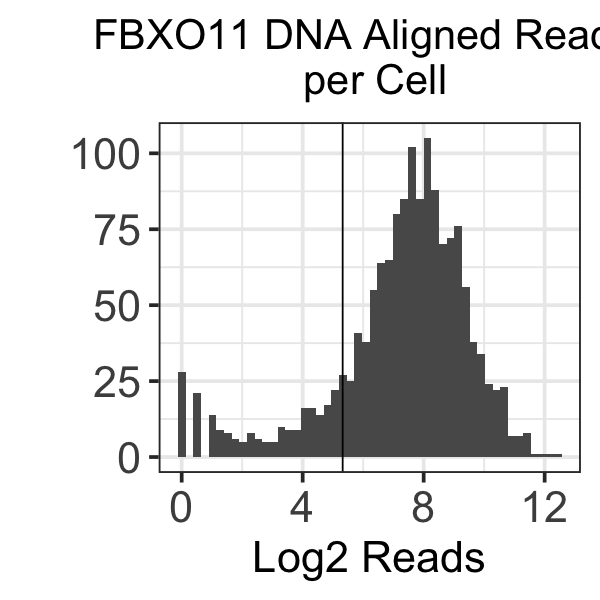

In [12]:
### DNA reads
fig.size(5,5)
alleles_DNA %>% mutate("test" = paste0(Well_ID, Barcode_DNA)) %>% 
                            group_by(test) %>% summarise(test, "mean" = mean(`#Reads`)) %>% unique %>% 
    ggplot(aes(log2(mean))) + 
    geom_histogram(bins = 50) + theme_gy() + geom_vline(xintercept = log2(40)) + 
    xlab("Log2 Reads") + ylab("") + ggtitle("FBXO11 DNA Aligned Reads \n per Cell")

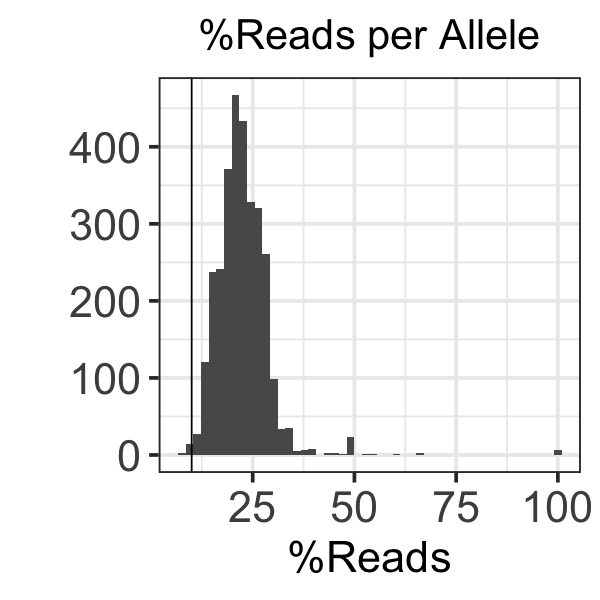

In [13]:
# Allele Freq - this is being caused by a sequencing error from too many T's 
alleles_DNA %>% 
    ggplot(aes((`%Reads`))) + 
    geom_histogram(bins = 50) + theme_gy() + geom_vline(xintercept = (10)) + 
    xlab("%Reads") + ylab("") + ggtitle("%Reads per Allele")

In [14]:
#Filter alleles
alleles_DNA_filt <- alleles_DNA %>% mutate("Plate_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% 
    FilterAlleles(12, 40) 
#Merge with metaData
alleles_DNA_filt<- 
    alleles_DNA_filt %>% separate(Plate_Well, into = c("Barcode_DNA", "Well_ID")) %>% inner_join(meta_DNA)

#Fix length from P7
alleles_DNA_filt<- alleles_DNA_filt %>% 
    mutate("Allele1" = str_trunc(Allele1, 65, "left",ellipsis = "" )) %>% 
    mutate("Allele2" = str_trunc(Allele2, 65, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 65, "left", ellipsis = "")) %>% 
    mutate("Allele1" = str_trunc(Allele1, 50, "right",ellipsis = "" )) %>% 
    mutate("Allele2" = str_trunc(Allele2, 50, "right", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 50, "right", ellipsis = ""))
#Call genotypes
alleles_DNA_filt_gen <- GenotypesFunction(alleles_DNA_filt)

Joining with `by = join_by(Plate_Well, Reference)`
Joining with `by = join_by(Barcode_DNA, Reference)`
Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”
Joining with `by = join_by(Alleles)`


In [15]:
alleles_DNA_filt_gen$genotype %>% table %>% sort(decreasing = T)

.
   1    2    4   10    7    6   11   12    3    5    8    9 
1038  206   41    3    3    2    1    1    1    1    1    1 

Warning message:
“`as_data_frame()` was deprecated in tibble 2.0.0.
ℹ Please use `as_tibble()` (with slightly different semantics) to convert to a tibble, or `as.data.frame()` to convert to a data frame.”


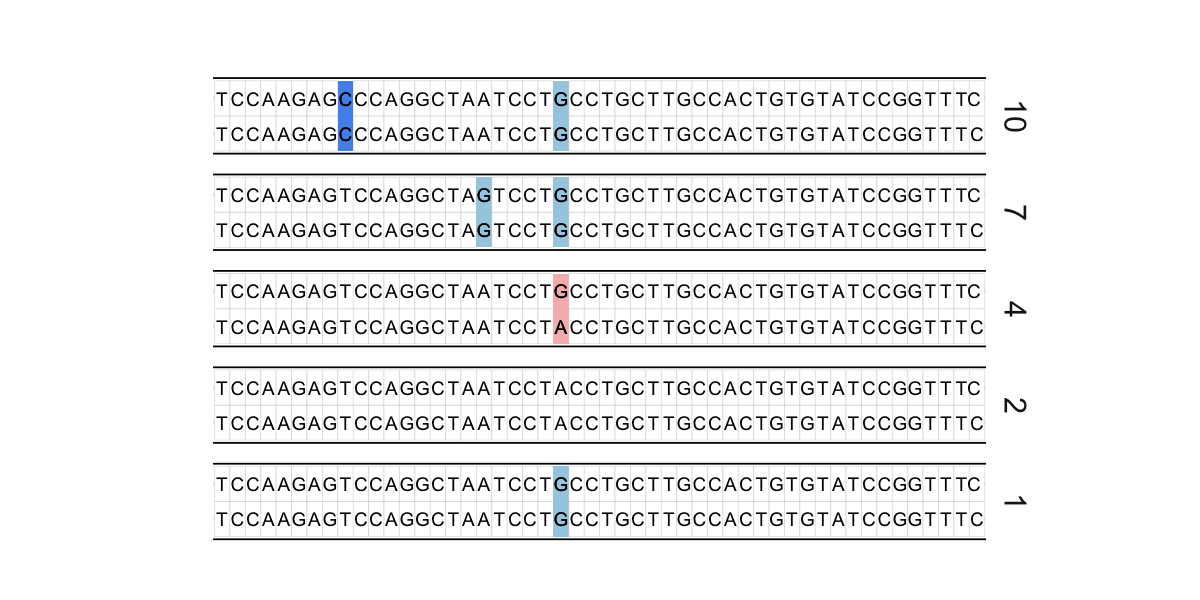

In [16]:
fig.size(5,10)
#Define order
order <- alleles_DNA_filt_gen$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)
#Make DF for plotting
df<- GenotypeHeatmap2(alleles_DNA_filt_gen, 2)
#Fix order
df$genotypes <- factor(df$genotypes, levels = order)

g <-     

g<- df %>% #the number is the filter on genotype 
ggplot(aes(x = reorder(position, as.integer(position)), 
           y = allele, fill = `value`)) + 
    geom_tile(aes(color = value), width=1, height=1) +
        geom_text(data = dplyr::filter(df),
                  aes(label = `allele_value`), angle = 0, size = (4)) + 
        geom_text(data = dplyr::filter(df, value != "R"),
                  aes(label = allele_value), angle = 0, size = (4))+
        scale_fill_manual(values = 
                    c(R = 'white',
                    CC = "#5194ed", 
                      TT = "#fdb462", 
                      CT = "#7fc97f", 
                      GT = "#ef3b2c",
                      CG = "#f5aa87",
                      GG = "#a6cee3",  
                      AG = "#f5bbba",
                      AA = "#fae1e1",
                     `-A`= "grey90", 
                     `-T` = "grey90", 
                     `-C` = "grey90", 
                     `-G` = "grey90", 
                     `--` ="grey80"))+ 
        scale_color_manual(values = 
                   c(R = 'grey',
                      CC = "NA", 
                      TT = "NA", 
                      CT = "NA", 
                      GT = "NA",
                      CG = "NA",
                      GG = "NA",  
                     AG = "NA"))+ 
     #c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33"))
        ggtitle("") + 
        theme_gy()+
    xlab("")+
    theme(aspect.ratio = 0.1)+ 
    ylab("") +
    theme(axis.text.y = element_text(size = 0, angle = 0, hjust = .5, vjust = .5),
          axis.text.x = element_text(size = 0),
        axis.title.x = element_text(size = 20, angle = 0, hjust = .5, vjust = .5),
        axis.title.y = element_text(size = 20, angle = 90, hjust = .5, vjust = .5),
          axis.ticks.y = element_blank(),
         legend.position = "none") + 
    scale_x_discrete(breaks=NULL) + 
    facet_grid(genotypes~.)+ 
theme(
  strip.background = element_blank(),
  strip.text.x = element_blank(), 
    panel.border=element_blank()

) + 
    annotate(geom = 'segment', y = Inf, yend = Inf, color = 'black', x = -Inf, xend = Inf, size = 1) + 

    annotate(geom = 'segment', y = -Inf, yend = -Inf, color = 'black', x = -Inf, xend = Inf, size = 1)
plot(g)



# Quality Control - Filtering RNA / ADT

## RNA QC

In [52]:
nUMI = colSums(exprs)
nGenes = colSums(exprs > 0)
pctMito = colSums(exprs[rownames(exprs)[rownames(exprs) %>% startsWith('MT-')], ])/nUMI
qc_df = data.frame(nUMI = nUMI, nGenes = nGenes, pctMito = pctMito)

In [53]:
meta = cbind(meta, qc_df[rownames(meta), ])

In [54]:
##Add indexing flow data to meta. 
meta_Flow <- FlowMatrix %>% inner_join(meta)

Joining with `by = join_by(cell)`


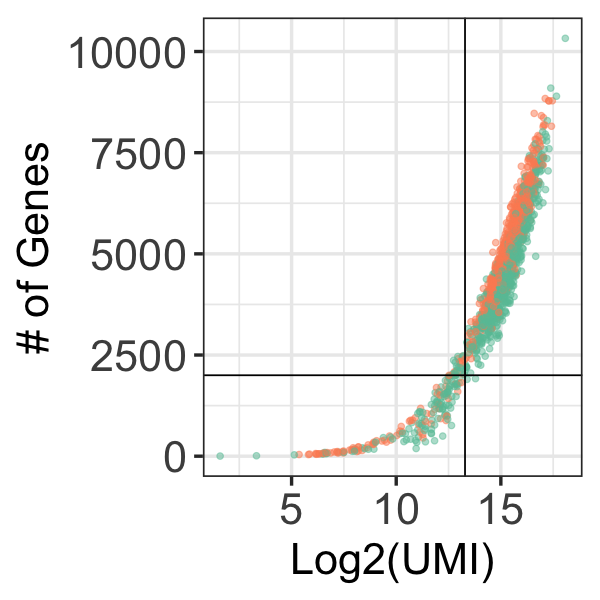

In [56]:
# QC figures
fig.size(5,5)
library(scales)
options(scipen = 999)

ggplot(meta_Flow %>% na.omit) +
       geom_point(aes(x=log2(nUMI), y=nGenes, color = CellType_Index), alpha = 0.5) +
    theme_gy(21) + ylab("# of Genes") + 
    xlab("Log2(UMI)") + scale_color_brewer(palette = "Set2")  + 
    theme(legend.position = "none") + 
    scale_x_continuous(labels = scales::comma) + 
    labs(color = "Celltype")+  
    geom_vline(xintercept = log2(10000)) + 
    geom_hline(yintercept = 2000)
    

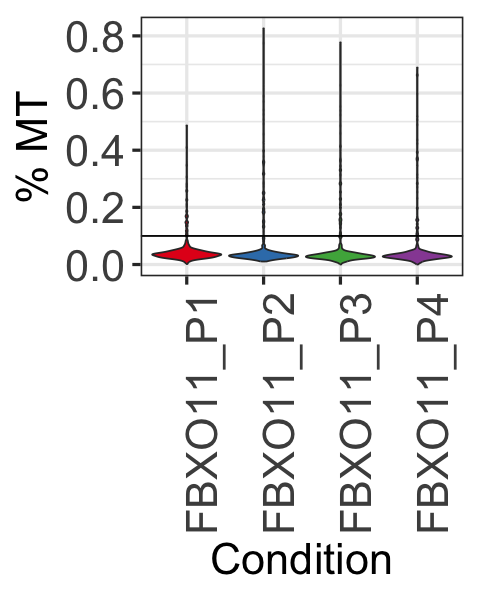

In [57]:
fig.size(5, 4)
meta_Flow %>% na.omit %>%
ggplot()+
    geom_violin(aes(x = Condition, y = pctMito, fill= Condition), scale = 'width')+
    theme_gy()+
    geom_hline(yintercept = 0.1) + 
    theme_gy(20) + ylab("% MT") + 
    scale_fill_brewer(palette = "Set1") + 
    theme(legend.position = "none")+
    theme(axis.text.x = element_text(angle = 90), legend.position = "none")

In [58]:
nCells = rowSums(exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

In [59]:
#Set thresholds based on above. 
nUMI_thresh =  10000 #5000 #40
nGene_thresh = 2000
pctMito_thresh = 0.1
ncell_thresh = floor(dim(exprs)[2]*0.1) #expressed in 10% of cells

filt_exprs = exprs[rownames(gene_qc %>% filter(nCells > ncell_thresh)), 
                   rownames(qc_df %>% filter(nUMI > nUMI_thresh, 
                                               nGenes > nGene_thresh, 
                                               pctMito < pctMito_thresh))]
#filtered expression
filt_meta = meta[colnames(filt_exprs),] #filtered meta

In [60]:
filt_cellcount = (table(meta$plate) %>% unclass %>% as.data.frame) - 
                (table(filt_meta$plate) %>% unclass %>% as.data.frame)
filt_cellcount$Condition = rownames(filt_cellcount)

colnames(filt_cellcount)[1] = 'Freq'

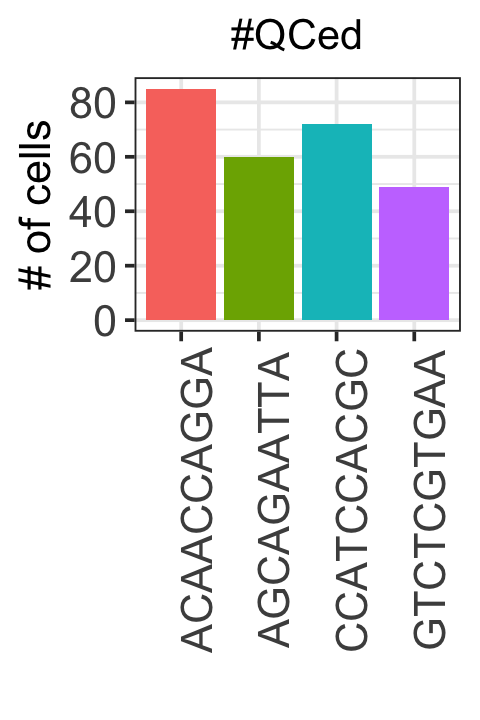

In [61]:
fig.size(6, 4)
ggplot(filt_cellcount)+
    geom_col(aes(y = Freq, x = Condition, fill = Condition))+
    theme_gy()+
    theme(axis.text.x = element_text(angle = 90), legend.position = 'none')+
    xlab('')+
    labs(fill = '')+
    ylab('# of cells')+
    ggtitle("#QCed")

## ADT QC

In [62]:
# Filter non-human ADTs and cells not called by STAR (RNA)
counts_ADT_filt <- counts_ADT[rownames(counts_ADT)[!grepl('^Mouse|^Rat|^Hamster', rownames(counts_ADT))], 
                             intersect(rownames(meta_ADT), rownames(meta))]

meta_ADT_filt <- meta_ADT[intersect(rownames(meta_ADT), rownames(meta)), ]

In [63]:
rownames(meta_ADT_filt) <- meta_ADT_filt$cell

Warning message:
“Setting row names on a tibble is deprecated.”


In [64]:
nUMI_ADT = colSums(counts_ADT_filt)
nGenes_ADT = colSums(counts_ADT_filt > 0)
qc_df_ADT = data.frame(nUMI = nUMI_ADT, nGenes = nGenes_ADT)

meta_ADT_filt = cbind(meta_ADT_filt, qc_df_ADT[rownames(meta_ADT_filt), ])

In [65]:
##Add indexing flow data to meta. First fix labels on FlowMatrix, then add cell barcode, then merge with meta
meta_ADT_Flow <- FlowMatrix %>% inner_join(meta_ADT_filt)

Joining with `by = join_by(cell)`


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


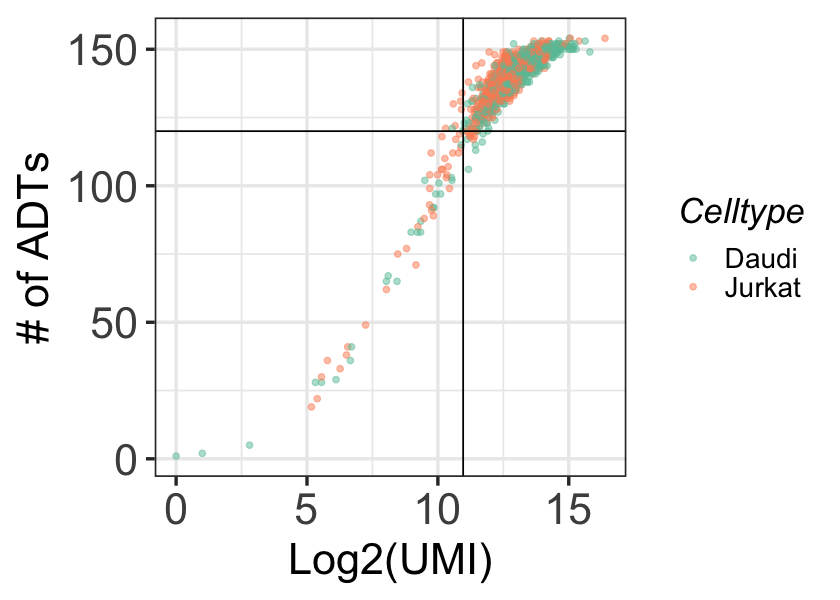

In [66]:
#plotting QC cutoffs
fig.size(5, 7)
ggplot(meta_ADT_Flow %>% na.omit) +
    geom_point(aes(x=log2(nUMI), y=nGenes, color = CellType_Index), alpha = 0.5) +
    theme_gy(21) + ylab("# of ADTs") + 
    xlab("Log2(UMI)") + scale_color_brewer(palette = "Set2") + 
    theme(legend.position = "right") + 
  labs(color = "Celltype")+ 
    scale_color_manual(values = c("HEK293T"='#8DA0CB',
                                  "Daudi" = '#66C2A5',
                                  "Jurkat"='#FC8D62')) +
  geom_vline(xintercept = log2(2000))+
    geom_hline(yintercept = 120)
    

In [67]:
# Filter to QC'd cells only
meta_ADT_filt = meta_ADT_filt %>% filter(nUMI > 2000, nGenes > 120)
counts_ADT_filt = counts_ADT_filt[, rownames(meta_ADT_filt)]

#Intersect with mRNA data to remove low quality cells
meta_ADT_filt <- filter(meta_ADT_filt, cell %in% filt_meta$cell)
counts_ADT_filt = counts_ADT_filt[, intersect(meta_ADT_filt$cell, filt_meta$cell)]


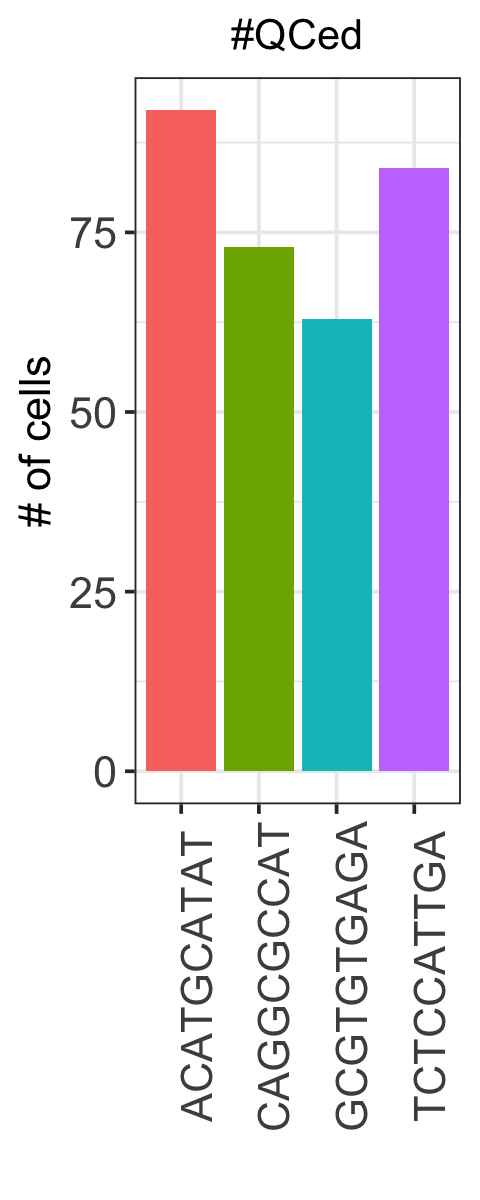

In [68]:
### Number of cells per condition/plate
filt_cellcount = (table(meta_ADT$plate) %>% unclass %>% as.data.frame) - 
                (table(meta_ADT_filt$plate) %>% unclass %>% as.data.frame)
filt_cellcount$Condition = rownames(filt_cellcount)

colnames(filt_cellcount)[1] = 'Freq'

### Number of cells per condition/plate

fig.size(10, 4)
ggplot(filt_cellcount)+
    geom_col(aes(y = Freq, x = Condition, fill = Condition))+
    theme_gy()+
    theme(axis.text.x = element_text(angle = 90), legend.position = 'none')+
    xlab('')+
    labs(fill = '')+
    ylab('# of cells')+
    ggtitle("#QCed")

# Pre-process expression data

In [113]:
### Pre-process based on metadata conditions

In [69]:
scale_exprs = process_rna(filt_exprs, filt_meta)

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [70]:
scale_adt = process_adt(counts_ADT_filt, 
                        meta_ADT_filt)

In [71]:
# Process all genes (or a subset) without variable gene selection, useful for plotting
plot_exprs_rna = normalize_rna(filt_exprs, filt_meta, scale = TRUE)

# Dimensionality Reduction

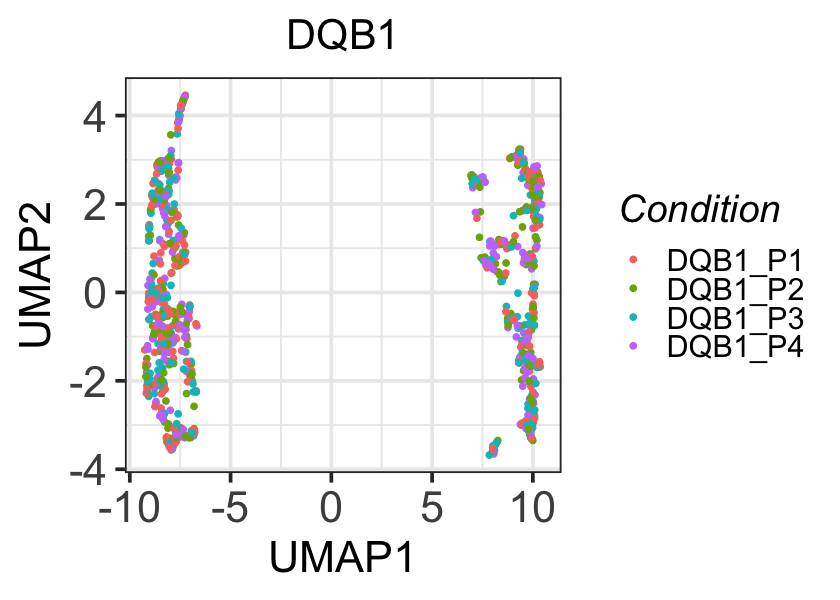

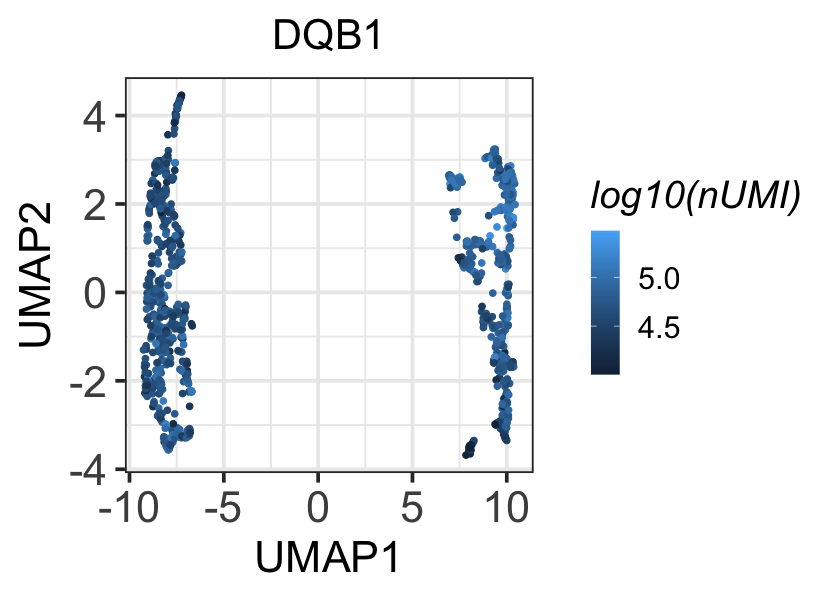

In [121]:
fig.size(5, 7)
ggplot(meta_umap_DQB1 %>% sample_n(nrow(meta_umap_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Condition))+
    theme_gy()+
    ggtitle('DQB1')
fig.size(5, 7)
ggplot(meta_umap_DQB1 %>% sample_n(nrow(meta_umap_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nUMI)))+
    theme_gy()+
    ggtitle('DQB1')

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



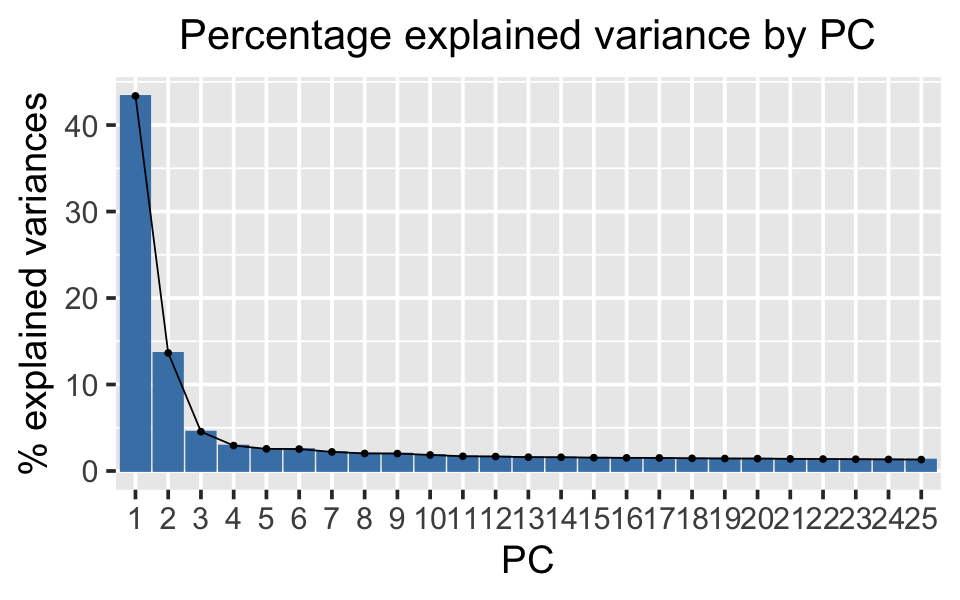

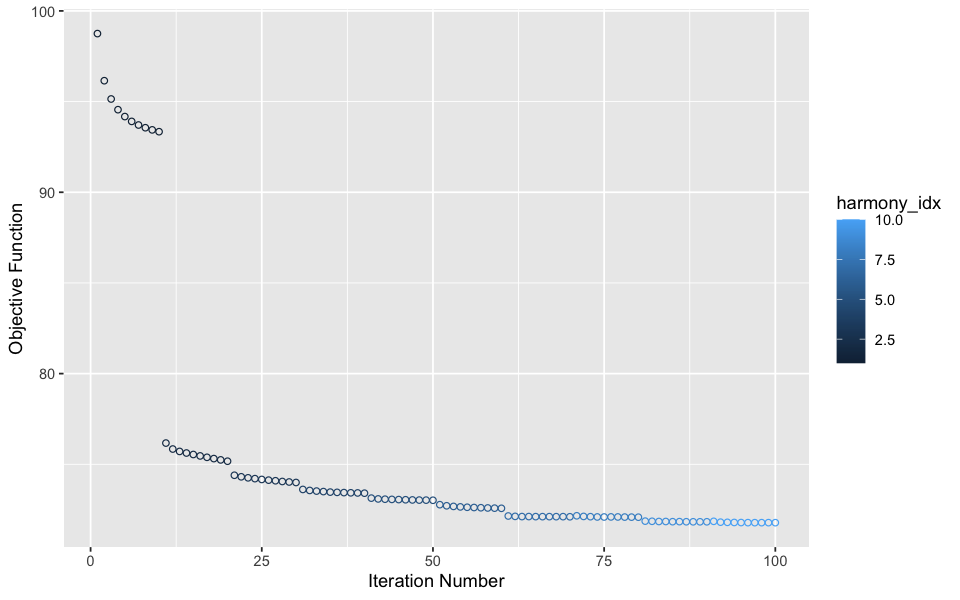

In [122]:
meta_umap_adt_DQB1 = pca_umap(scale_adt_DQB1, meta_ADT_filt, c('MainCondition'), c('DQB1'), 
                            harmony_var = 'Condition')

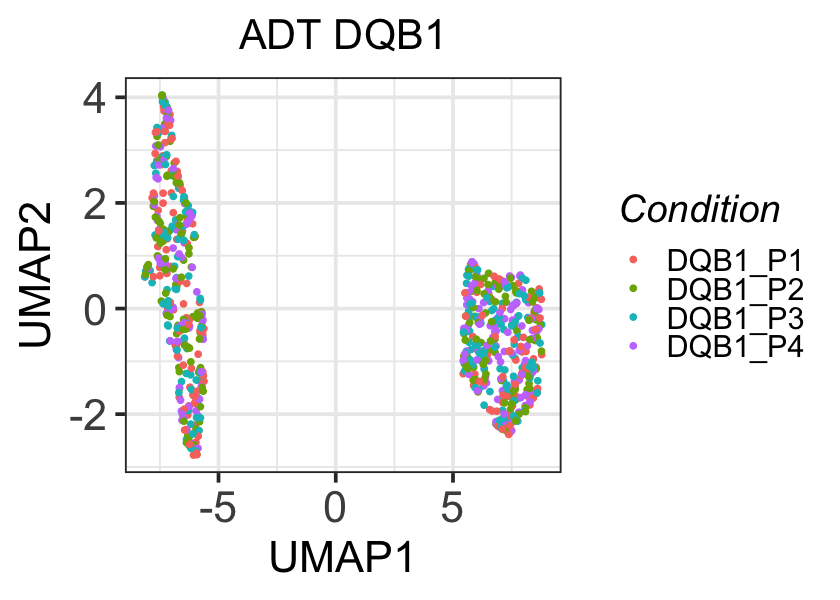

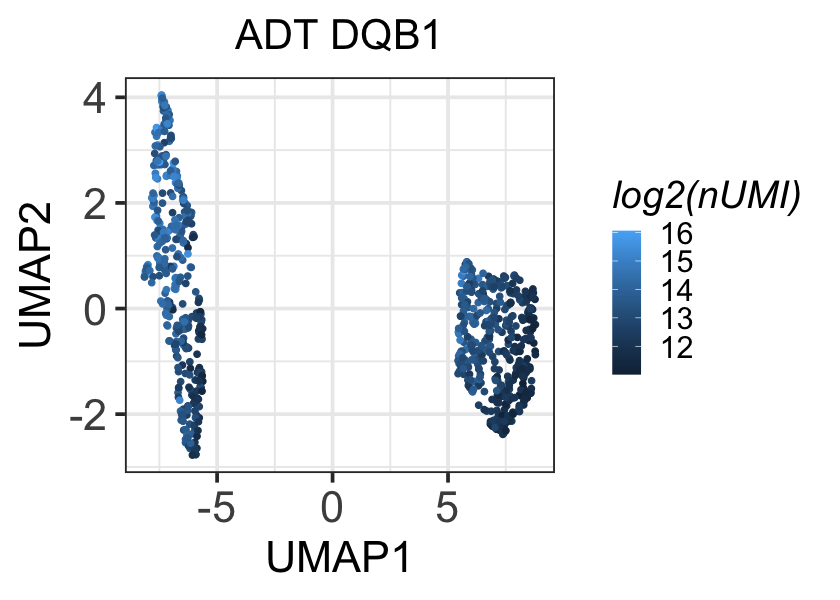

In [123]:
fig.size(5, 7)
ggplot(meta_umap_adt_DQB1 %>% sample_n(nrow(meta_umap_adt_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Condition))+
    theme_gy()+
    ggtitle('ADT DQB1')

fig.size(5, 7)
ggplot(meta_umap_adt_DQB1 %>% sample_n(nrow(meta_umap_adt_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log2(nUMI)))+
    theme_gy()+
    ggtitle('ADT DQB1')

## RNA expression

Warning message:
“Warning: The parameters do_pca and npcs are deprecated. They will be ignored for this function call and please remove parameters do_pca and npcs and pass to harmony cell_embeddings directly.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter max.iter.harmony is replaced with parameter max_iter. It will be ignored for this function call and please use parameter max_iter in future function calls.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter max.iter.cluster is deprecated. It will be ignored for this function call and please remove parameter max.iter.cluster in future function calls. Advanced users can set value of parameter max.iter.cluster by using parameter .options and function harmony_options().
This warning is displayed once per session.”
Warning message:
“Warning: The parameter epsilon.cluster is deprecated. It will be ignored for this function call and please remove parameter epsilon.clus

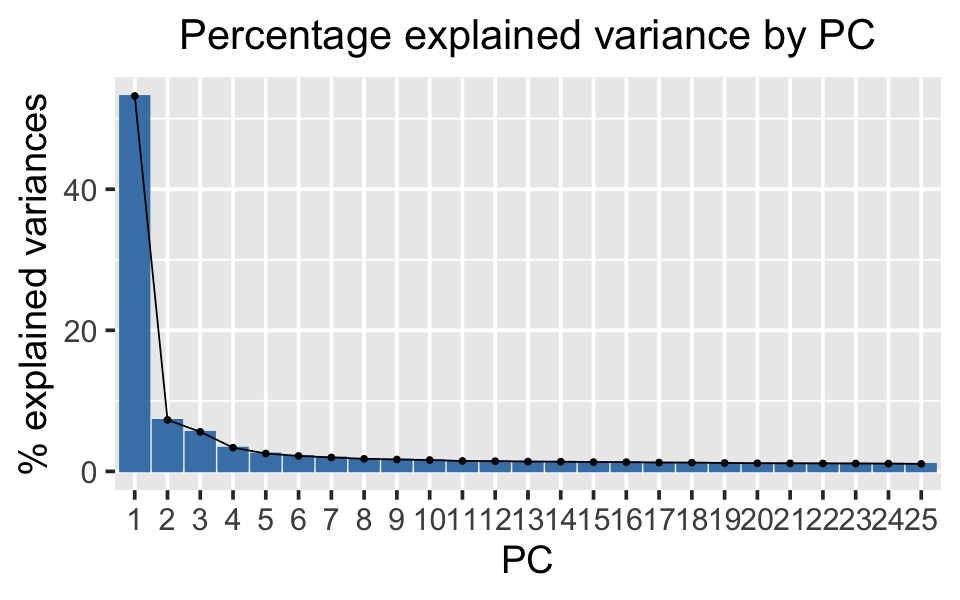

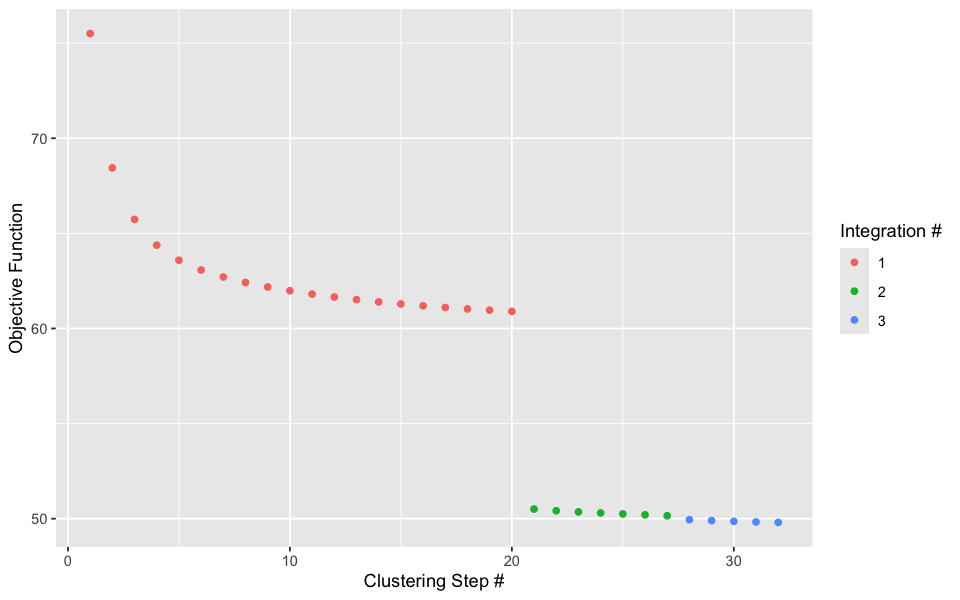

In [72]:
meta_umap = pca_umap(scale_exprs, meta, harmony_var = 'plate')

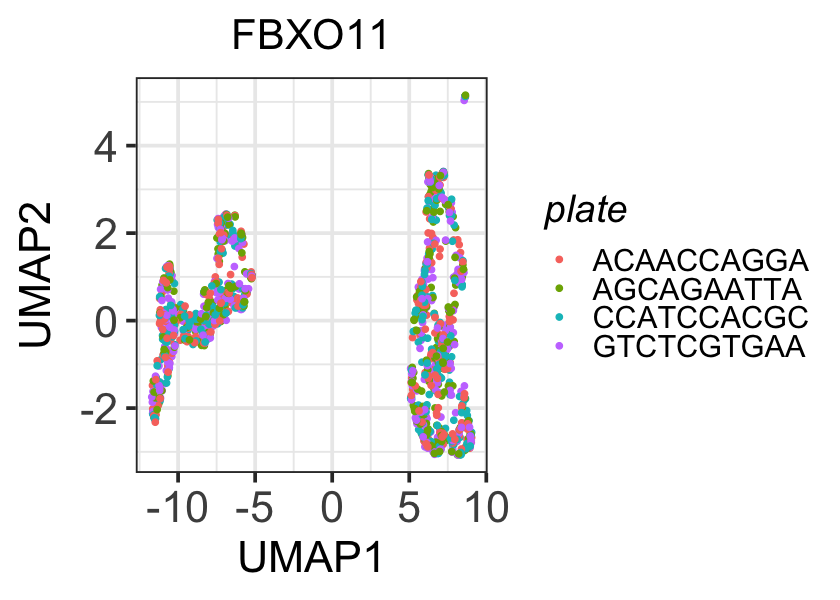

In [74]:
fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = plate))+
    theme_gy()+
    ggtitle('FBXO11')

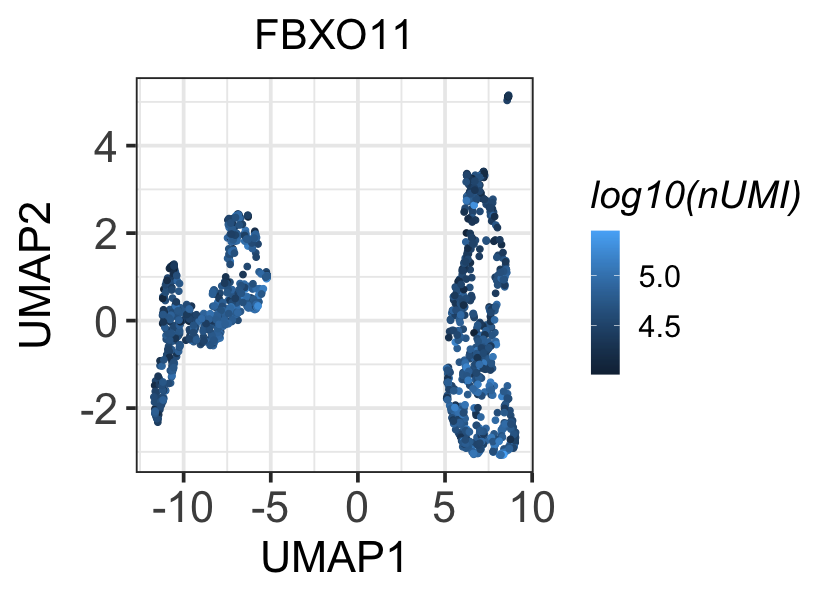

In [75]:
fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nUMI)))+
    theme_gy()+
    ggtitle('FBXO11')

## ADT

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



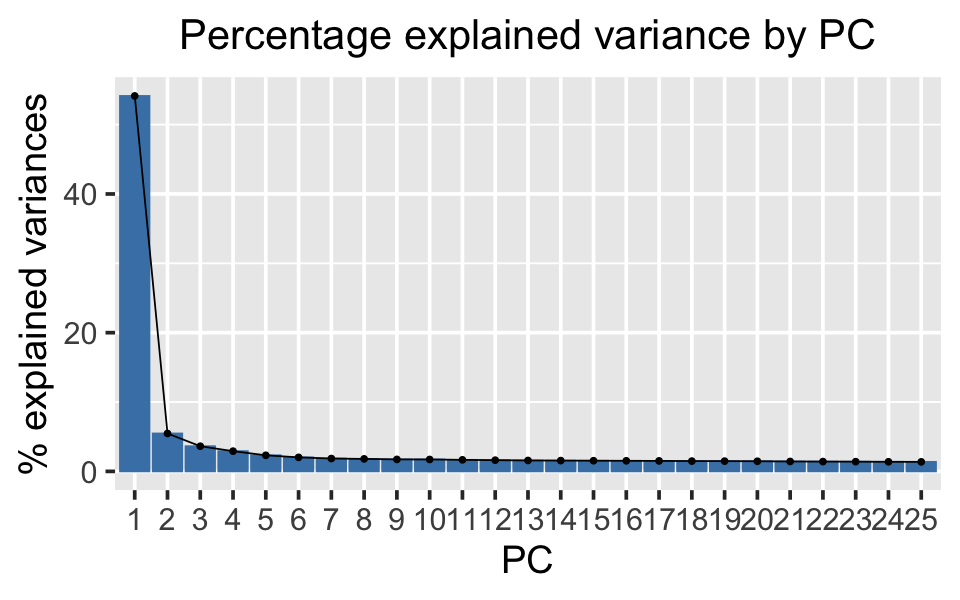

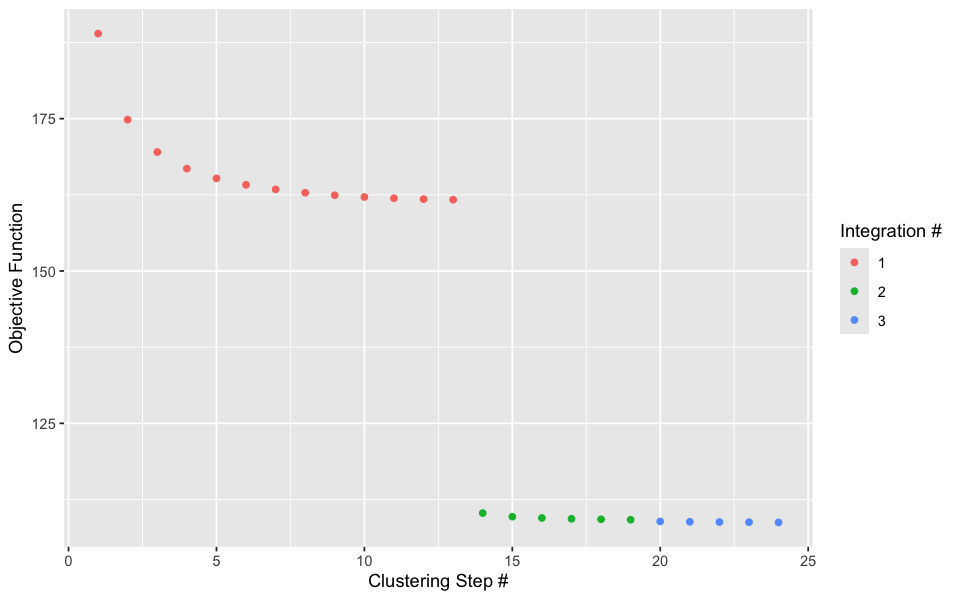

In [77]:
meta_umap_adt = pca_umap(scale_adt, meta_ADT_filt,  harmony_var = 'plate')

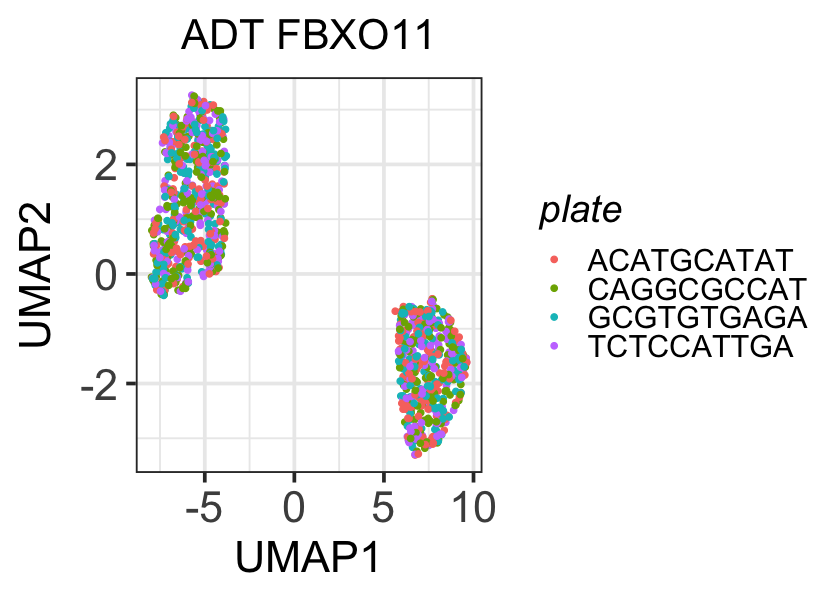

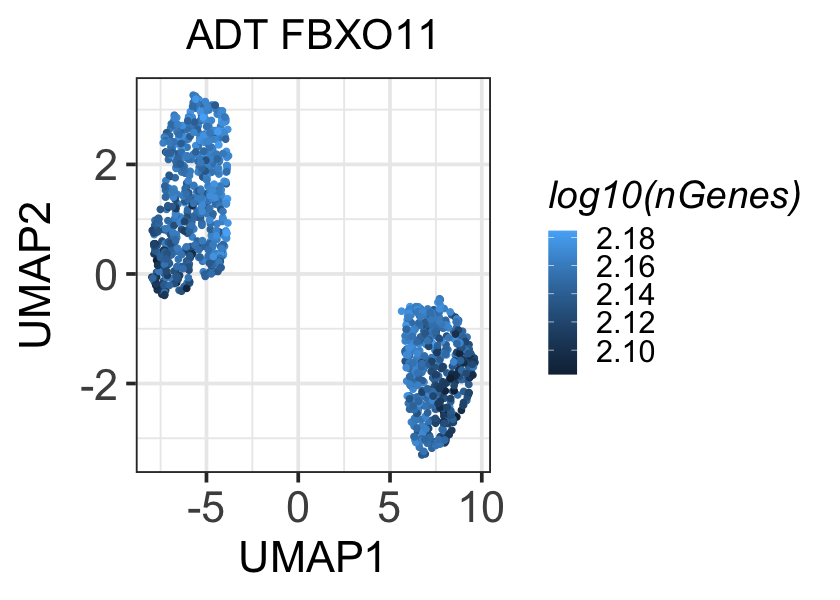

In [80]:
fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = plate))+
    theme_gy()+
    ggtitle('ADT FBXO11')

fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nGenes)))+
    theme_gy()+
    ggtitle('ADT FBXO11')

In [41]:
harmony::RunHarmony

function (...) 
{
    UseMethod("RunHarmony")
}
<bytecode: 0x1484cadd8>
<environment: namespace:harmony>

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



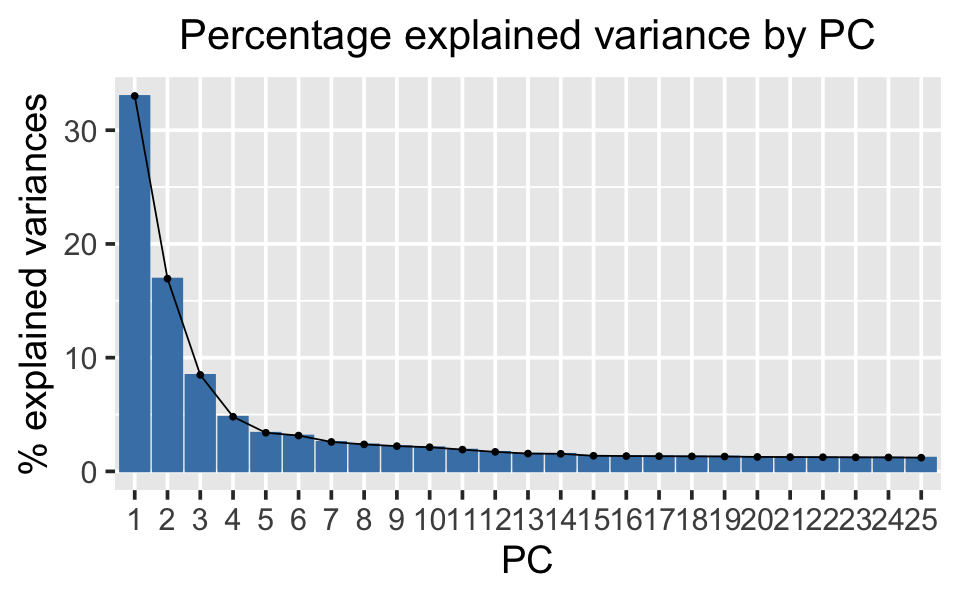

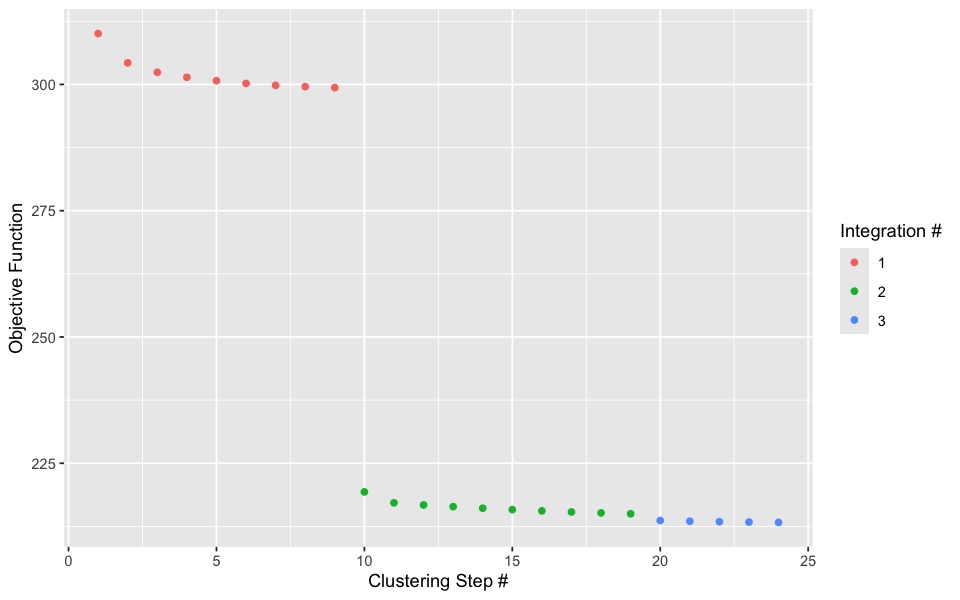

In [45]:
meta_umap = pca_umap(scale_exprs, filt_meta, harmony_var = 'plate')

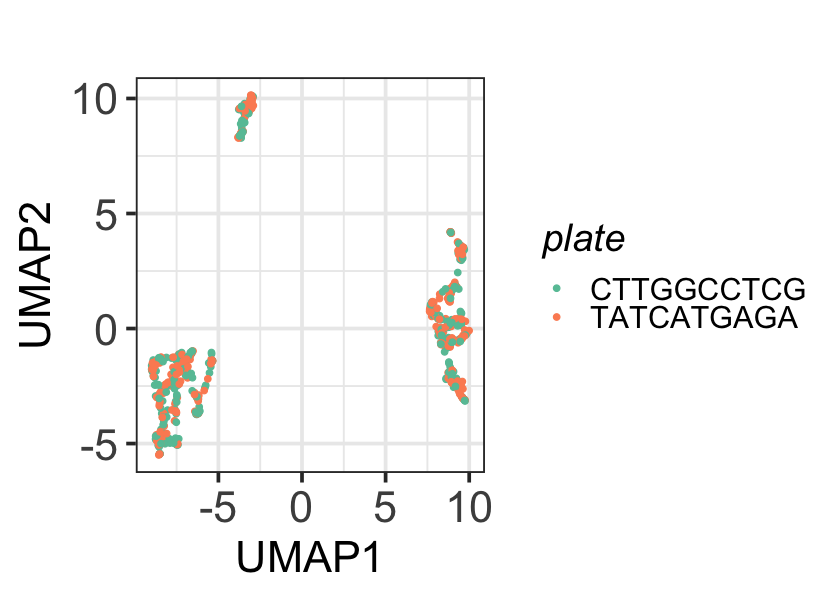

In [48]:
fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = plate))+
    theme_gy()+
    ggtitle('') + scale_color_brewer(palette = "Set2")

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



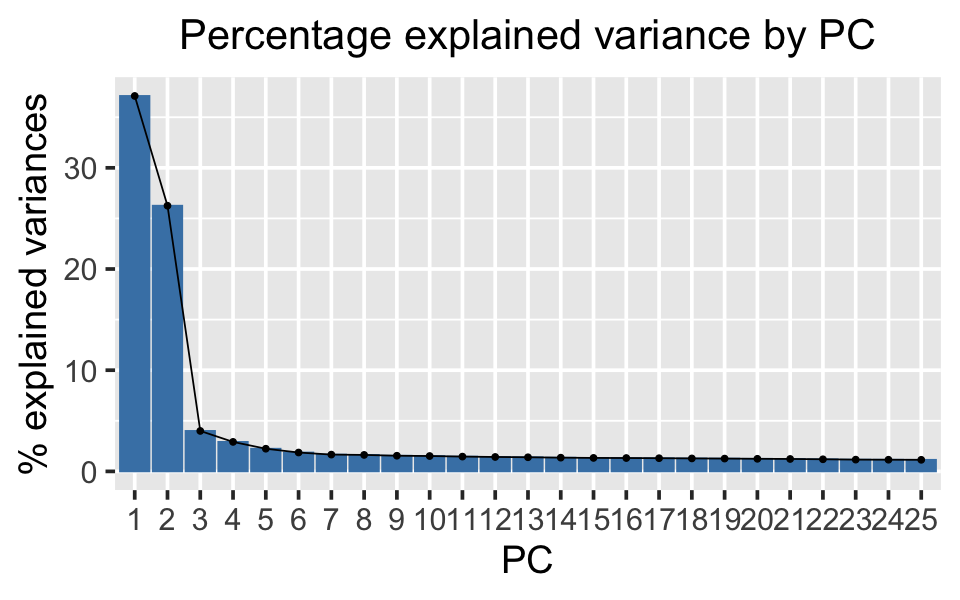

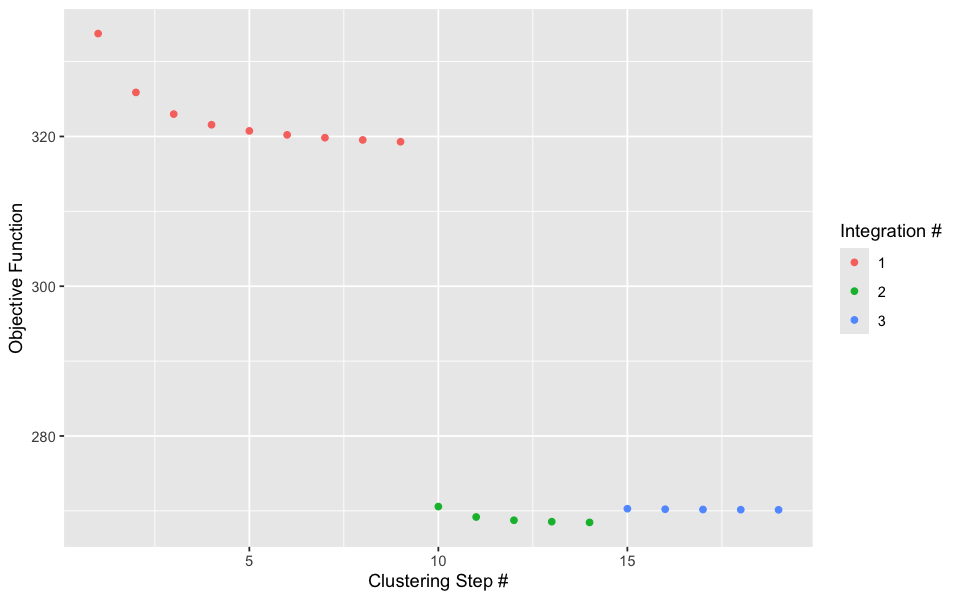

In [51]:
meta_umap_adt = pca_umap(scale_adt, meta_ADT_filt, harmony_var = 'plate')

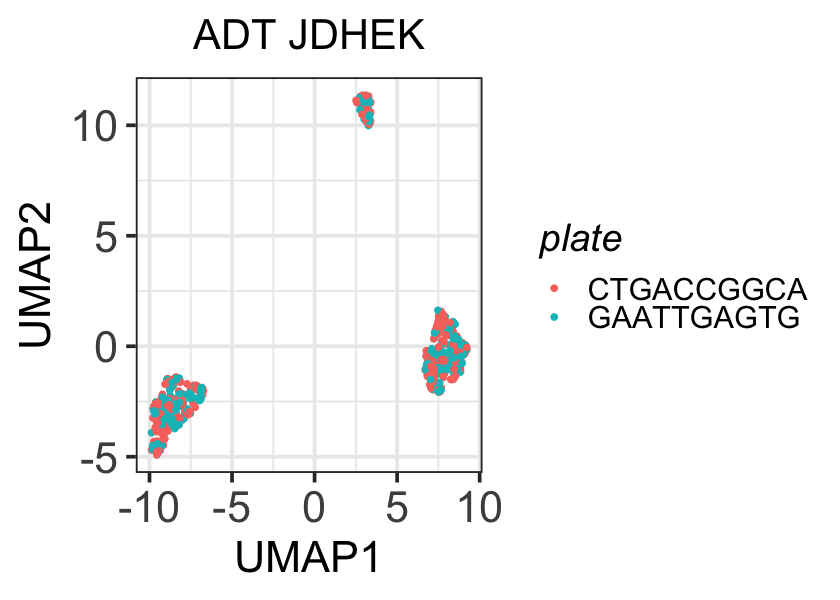

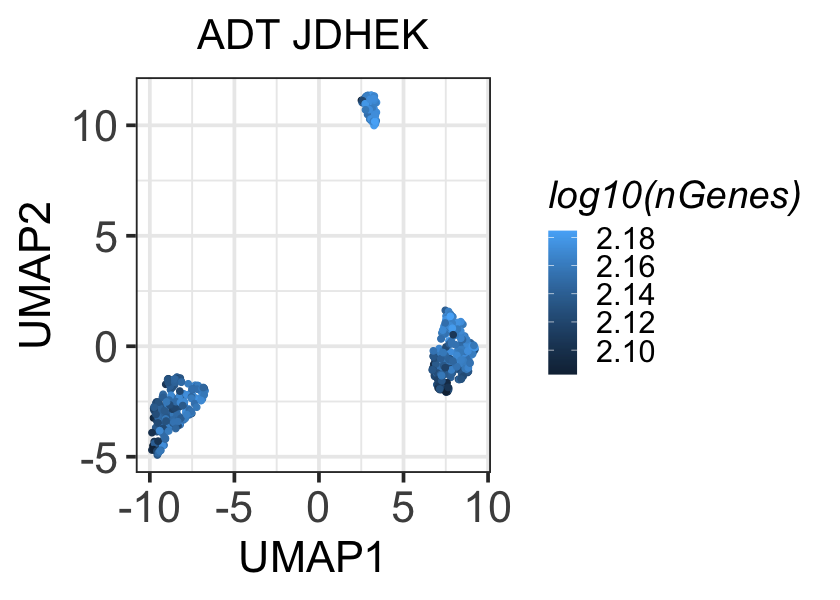

In [55]:
fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = plate))+
    theme_gy()+
    ggtitle('ADT JDHEK')

fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nGenes)))+
    theme_gy()+
    ggtitle('ADT JDHEK')

# Clustering + DGE

In [56]:
meta_umap.clust = do_cluster(meta_umap, resolution_list = seq(0.05, 0.5, 0.05))
table(meta_umap.clust$`res.0.1`)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9804
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9611
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9419
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9228
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version


  0   1   2 
249 239  69 

In [57]:
meta_umap.clust$cluster = meta_umap.clust$`res.0.1`

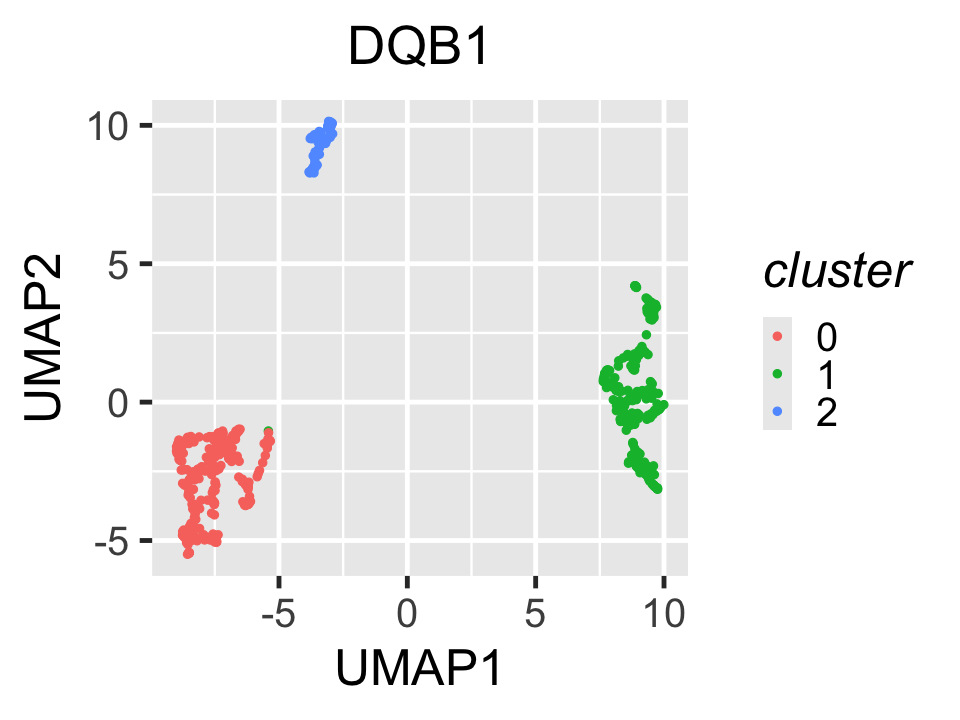

In [58]:
fig.size(6, 8)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('DQB1')

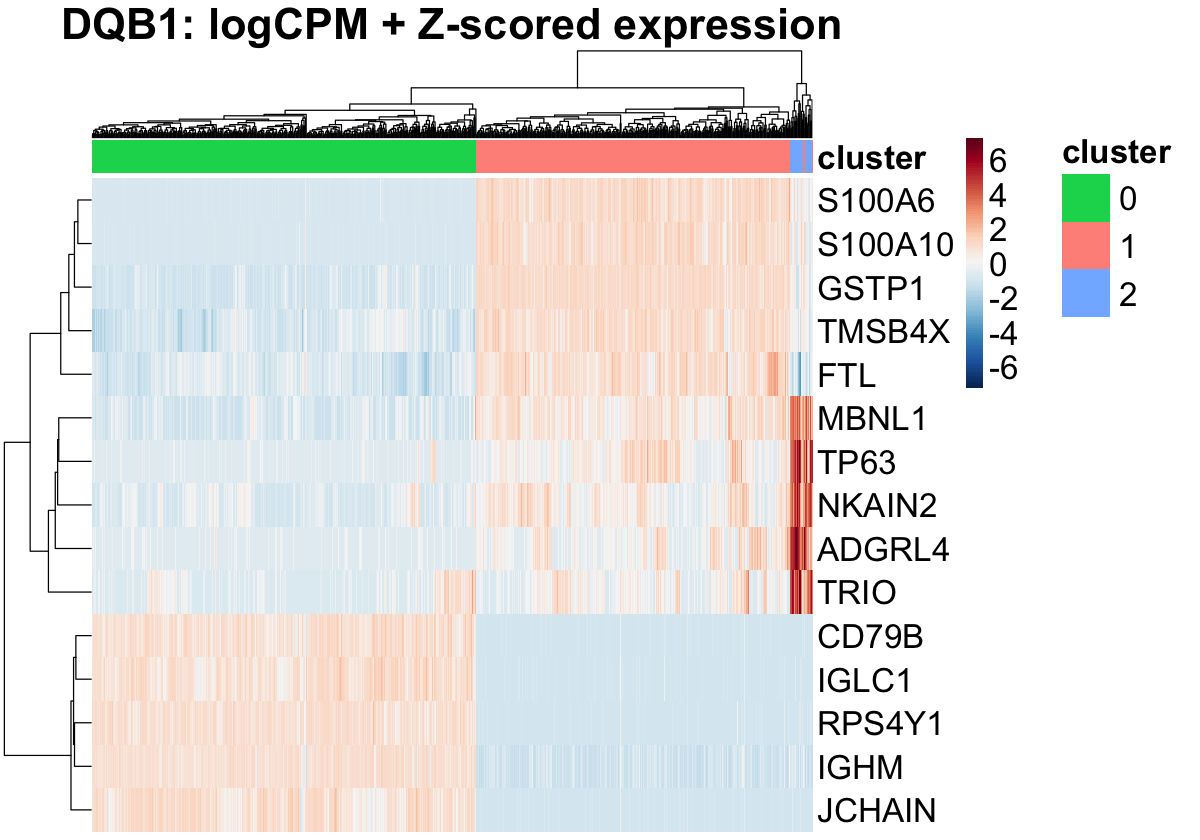

In [142]:
dge_DQB1 = wilcoxauc(scale_exprs_DQB1, meta_umap_DQB1.clust$cluster)

var_genes_DQB1 = top_markers(dge_DQB1, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_exprs_DQB1[var_genes_DQB1, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_DQB1.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_DQB1.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_exprs_DQB1[var_genes_DQB1, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_exprs_DQB1[var_genes_DQB1, ])))

fig.size(7, 10)
pheatmap(scale_exprs_DQB1[c(var_genes_DQB1,"HLA-DQB1"), ],
         main = 'DQB1: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

### ADT

In [143]:
meta_umap_adt_DQB1.clust = do_cluster(meta_umap_adt_DQB1, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31989

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9496
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31989

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8994
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31989

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8580
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31989

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8218
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version

In [144]:
meta_umap_adt_DQB1.clust$cluster = meta_umap_adt_DQB1.clust$`res.0.1`

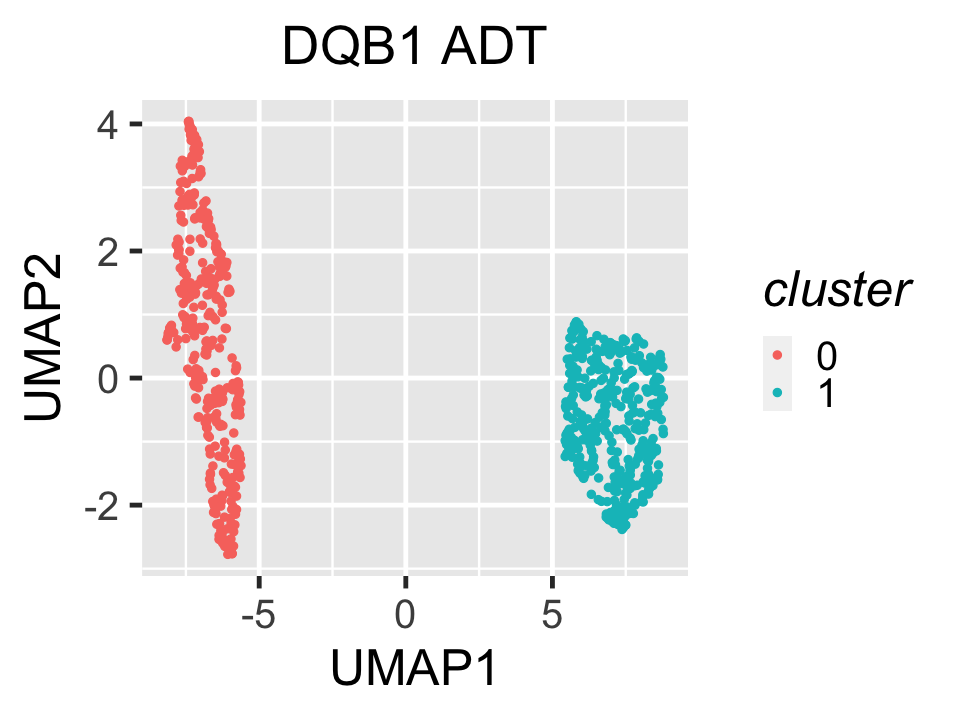

In [145]:
fig.size(6, 8)
ggplot(meta_umap_adt_DQB1.clust[sample(rownames(meta_umap_adt_DQB1.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('DQB1 ADT')

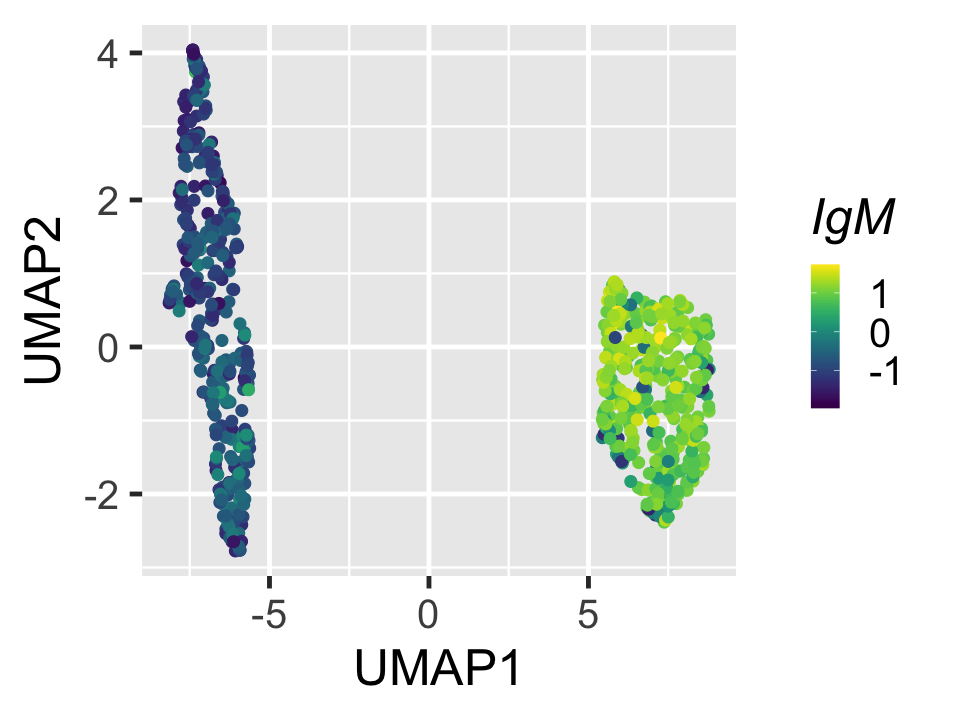

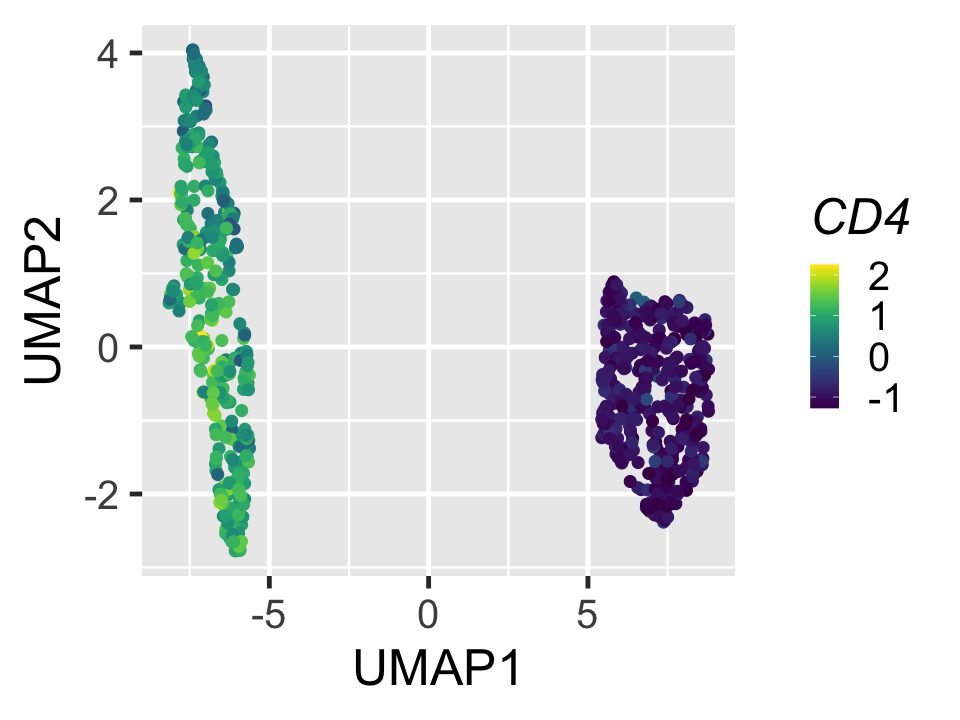

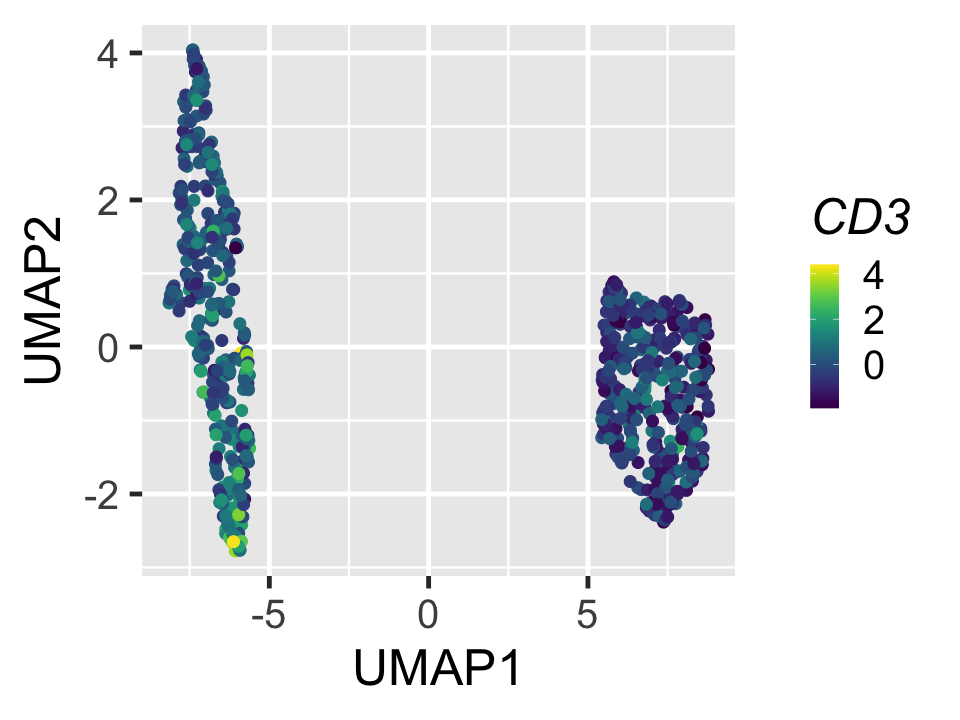

In [146]:
plot_exprs(scale_adt_DQB1, meta_umap_adt_DQB1, c("IgM", "CD4", "CD3"))

In [147]:
intersect(rownames(meta_umap_DQB1),
         rownames(meta_umap_adt_DQB1)) %>% length

[1] 808

In [148]:
# Compare cluster concordance in RNA vs protein
intersect_cells = intersect(rownames(meta_umap_adt_DQB1.clust), rownames(meta_umap_DQB1.clust))
concordance_RNAprot_DQB1 = table(meta_umap_adt_DQB1.clust[intersect_cells, 'cluster'],
                                 meta_umap_DQB1.clust[intersect_cells, 'cluster']) %>% as.data.frame

In [149]:
# # Order clusters in plot
# concordance_RNAprot_DQB1$Var2 = factor(concordance_RNAprot_DQB1$Var2, 
#                                        levels = unique(concordance_RNAprot_DQB1$Var2))
# concordance_RNAprot_DQB1$Var1 = factor(concordance_RNAprot_DQB1$Var1, 
#                                        levels = unique(concordance_RNAprot_DQB1$Var1))

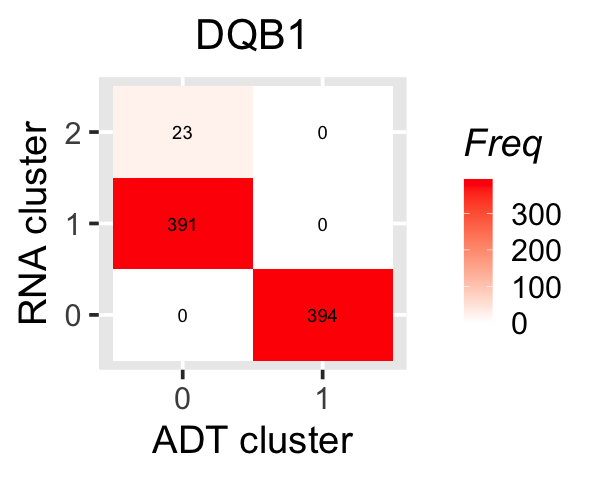

In [150]:
# Compare cluster concordance in RNA vs protein
intersect_cells = intersect(rownames(meta_umap_adt_DQB1.clust), rownames(meta_umap_DQB1.clust))
concordance_RNAprot_DQB1 = table(meta_umap_adt_DQB1.clust[intersect_cells, 'cluster'],
                                 meta_umap_DQB1.clust[intersect_cells, 'cluster']) %>% as.data.frame

fig.size(4, 5)
ggplot(concordance_RNAprot_DQB1)+
    geom_tile(aes(x = Var1, y = Var2, fill = Freq))+
    geom_text(aes(x = Var1, y = Var2, label = Freq)) +
    scale_fill_gradient(low = "white", high = "red")+
    theme_g()+
    xlab('ADT cluster')+
    ylab('RNA cluster')+
    ggtitle('DQB1')

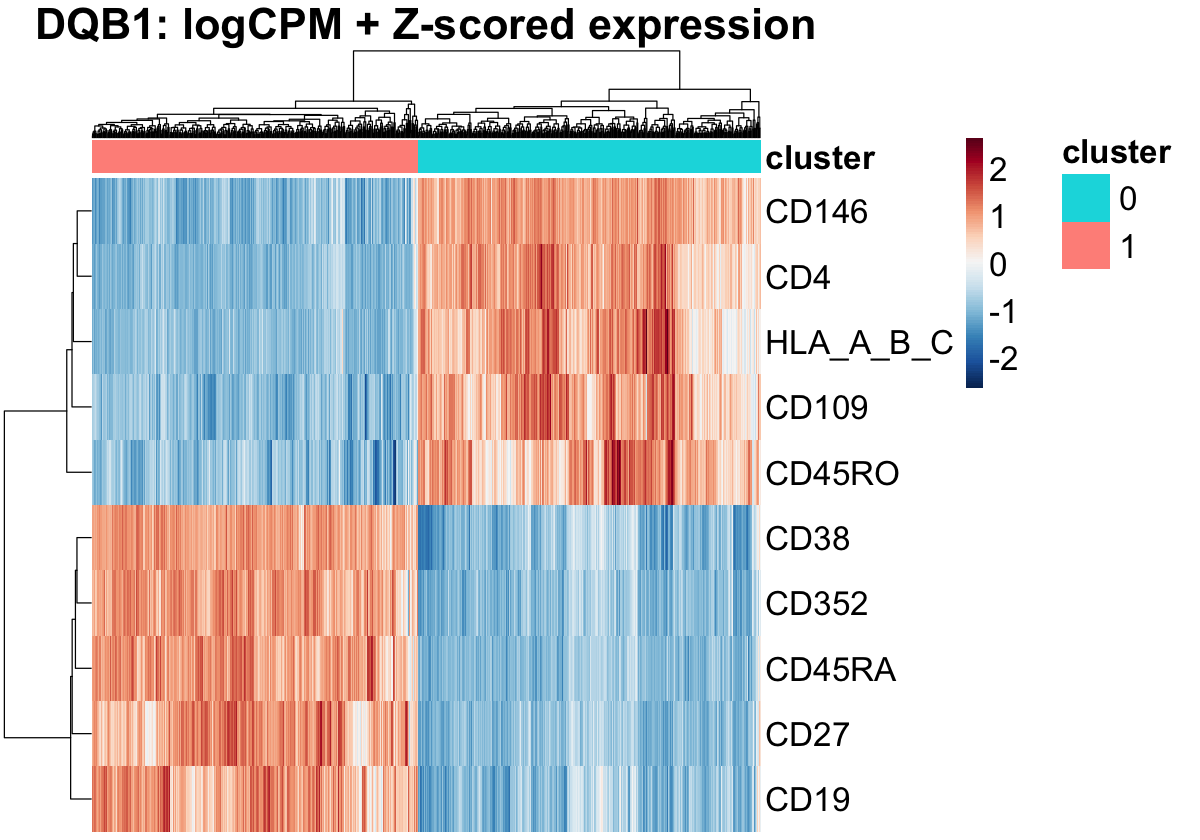

In [151]:
#Heatmap of variable genes
dge_DQB1 = wilcoxauc(scale_adt_DQB1, meta_umap_adt_DQB1.clust$cluster)
var_genes_DQB1 = top_markers(dge_DQB1, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_adt_DQB1[var_genes_DQB1, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_adt_DQB1.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_adt_DQB1.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_adt_DQB1[var_genes_DQB1, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_adt_DQB1[var_genes_DQB1, ])))
fig.size(7, 10)
pheatmap(scale_adt_DQB1[c(var_genes_DQB1), ],
         main = 'DQB1: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

## Clustering in Gene UMAP

In [81]:
meta_umap.clust = do_cluster(meta_umap, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1270
Number of edges: 40672

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9495
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1270
Number of edges: 40672

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9074
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1270
Number of edges: 40672

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8781
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1270
Number of edges: 40672

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8519
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer ver

In [82]:
table(meta_umap.clust$'res.0.1')


  0   1 
704 566 

In [83]:
meta_umap.clust$cluster = meta_umap.clust$`res.0.1`

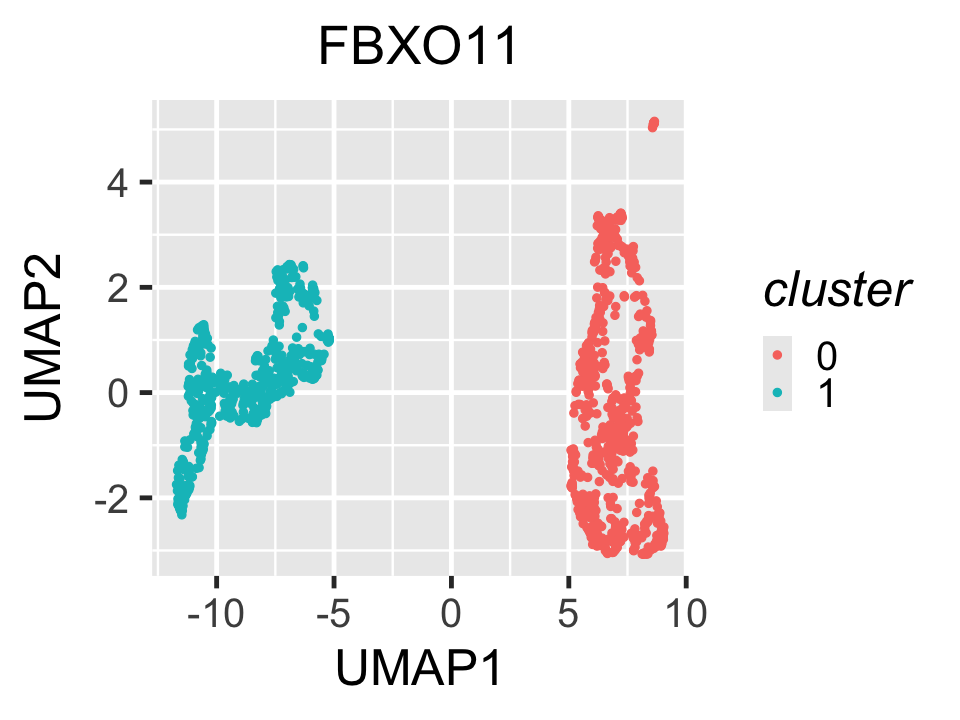

In [84]:
fig.size(6, 8)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('FBXO11')

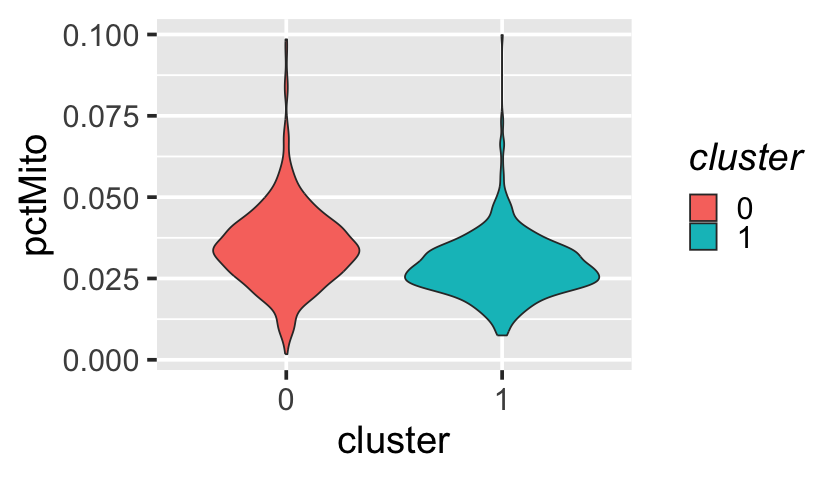

In [85]:
fig.size(4, 7)
ggplot(meta_umap.clust )+
    geom_violin(aes(x = cluster, y = pctMito, fill = cluster))+
    theme_g()

In [87]:
dge_FBXO11 = wilcoxauc(scale_exprs, meta_umap.clust$cluster)

In [88]:
var_genes_FBXO11 = top_markers(dge_FBXO11, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 

cmax = abs(scale_exprs[var_genes_FBXO11, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap.clust$cluster)
rownames(mat_col) <- rownames(meta_umap.clust)

# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_exprs[var_genes_FBXO11, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_exprs[var_genes_FBXO11, ])))

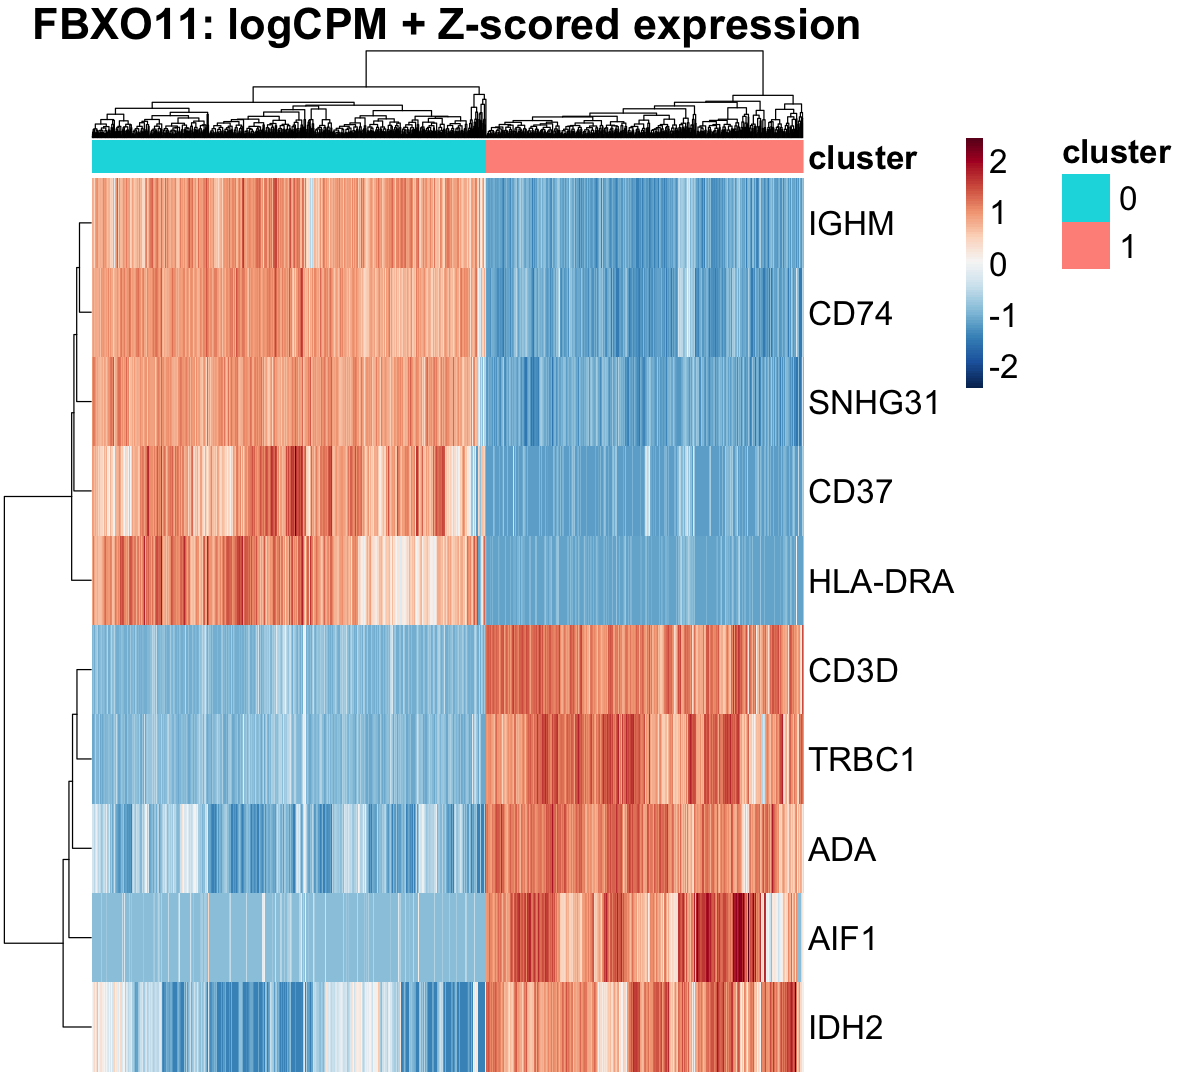

In [89]:
fig.size(9, 10)
pheatmap(scale_exprs[var_genes_FBXO11, ],
         main = 'FBXO11: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

### ADT

In [91]:
meta_umap_adt.clust = do_cluster(meta_umap_adt, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1224
Number of edges: 47956

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9495
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1224
Number of edges: 47956

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8990
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1224
Number of edges: 47956

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8485
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1224
Number of edges: 47956

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7981
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer ver

In [92]:
table(meta_umap_adt.clust$'res.0.1')


  0   1 
687 537 

In [93]:
meta_umap_adt.clust$cluster = meta_umap_adt.clust$`res.0.1`

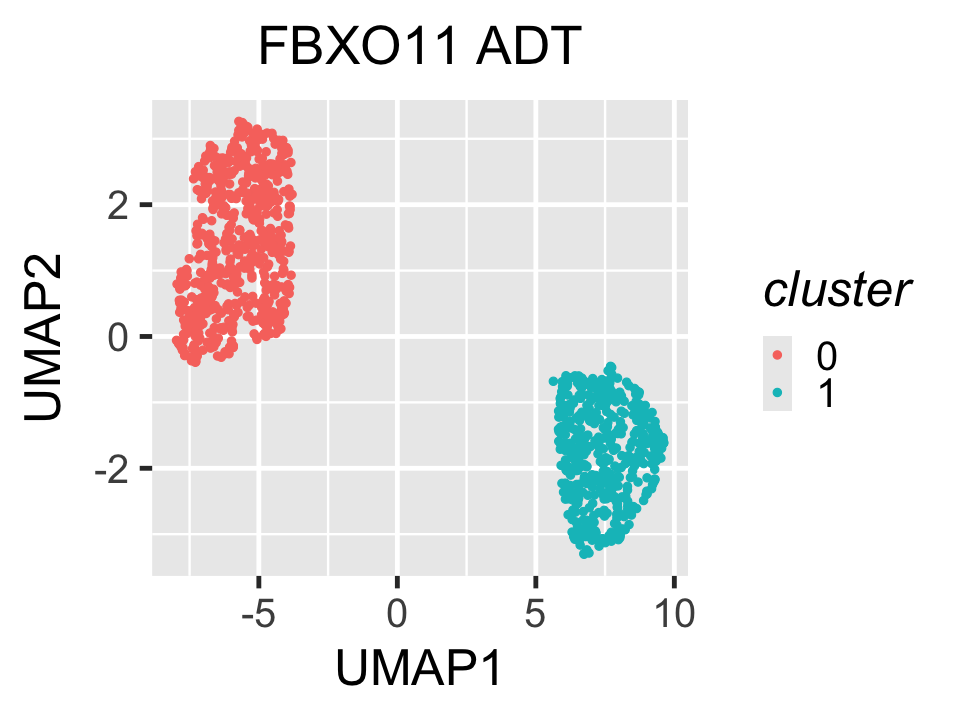

In [94]:
fig.size(6, 8)
ggplot(meta_umap_adt.clust[sample(rownames(meta_umap_adt.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('FBXO11 ADT')

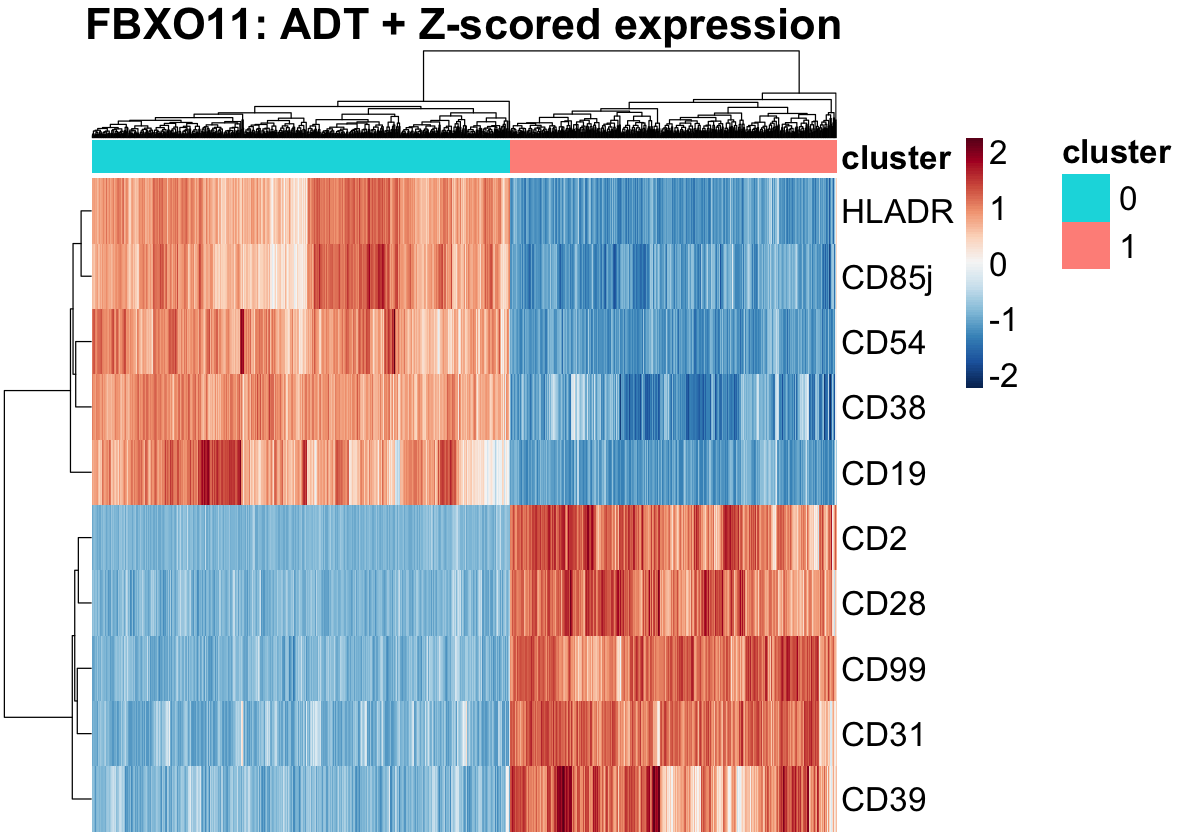

In [97]:
DGE= wilcoxauc(scale_adt, meta_umap_adt.clust$cluster)
var_genes = top_markers(DGE, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_adt[var_genes, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_adt.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_adt.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_adt[var_genes, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_adt[var_genes, ])))
fig.size(7, 10)
pheatmap(scale_adt[c(var_genes), ],
         main = 'FBXO11: ADT + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

In [59]:
meta_umap.clust = do_cluster(meta_umap, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9611
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9228
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8902
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8622
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version

In [61]:
table(meta_umap.clust$'res.0.1')


  0   1   2 
249 239  69 

In [63]:
meta_umap.clust$cluster = meta_umap.clust$`res.0.1`

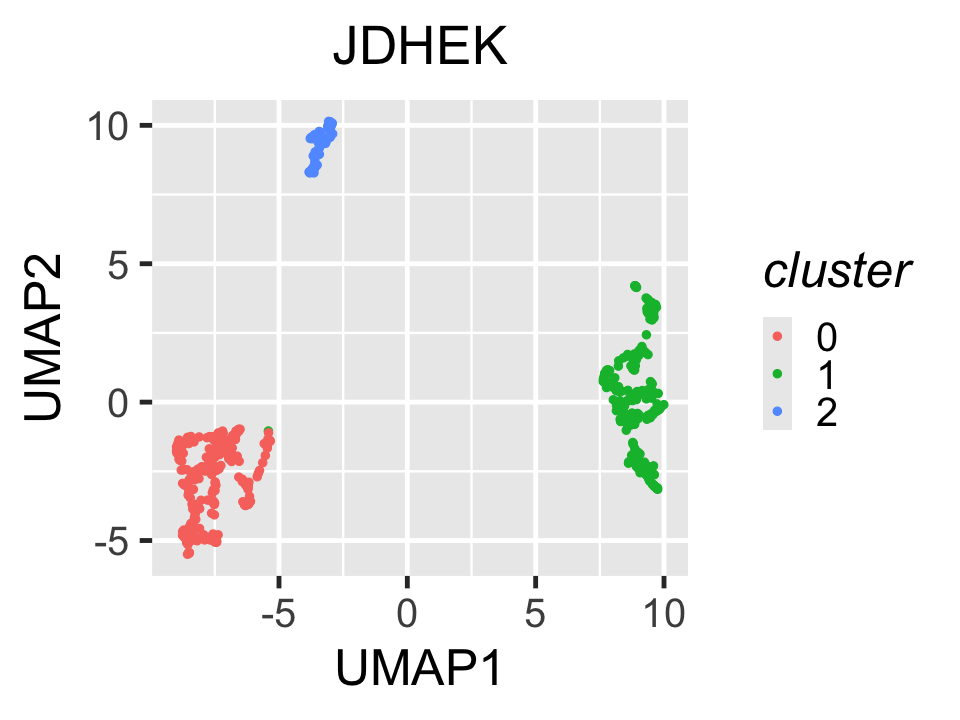

In [64]:
fig.size(6, 8)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('JDHEK')

In [65]:
DGE = wilcoxauc(scale_exprs, meta_umap.clust$cluster)

In [66]:
top_markers(DGE, 50) %>% head(10)


rank 0       1        2     
1   1   TRBC1   CD37     CKB   
2   2   ADA     SNHG31   TSPO  
3   3   CD3D    CD74     UCHL1 
4   4   LCK     IGKC     CALD1 
5   5   AIF1    HLA-DRA  CSRP2 
6   6   IDH2    IGLC1    PLS3  
7   7   GYPC    TCL1A    RASAL2
8   8   CD3E    HLA-DPA1 GAL   
9   9   ARHGDIB IGHM     PERP  
10 10   PGK1    CD79B    TCEAL4

### ADT

In [67]:
meta_umap_adt.clust = do_cluster(meta_umap_adt, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 526
Number of edges: 20853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9618
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 526
Number of edges: 20853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9237
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 526
Number of edges: 20853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8856
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 526
Number of edges: 20853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8475
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version

In [68]:
table(meta_umap_adt.clust$'res.0.1')


  0   1   2 
232 225  69 

In [69]:
meta_umap_adt.clust$cluster = meta_umap_adt.clust$`res.0.1`

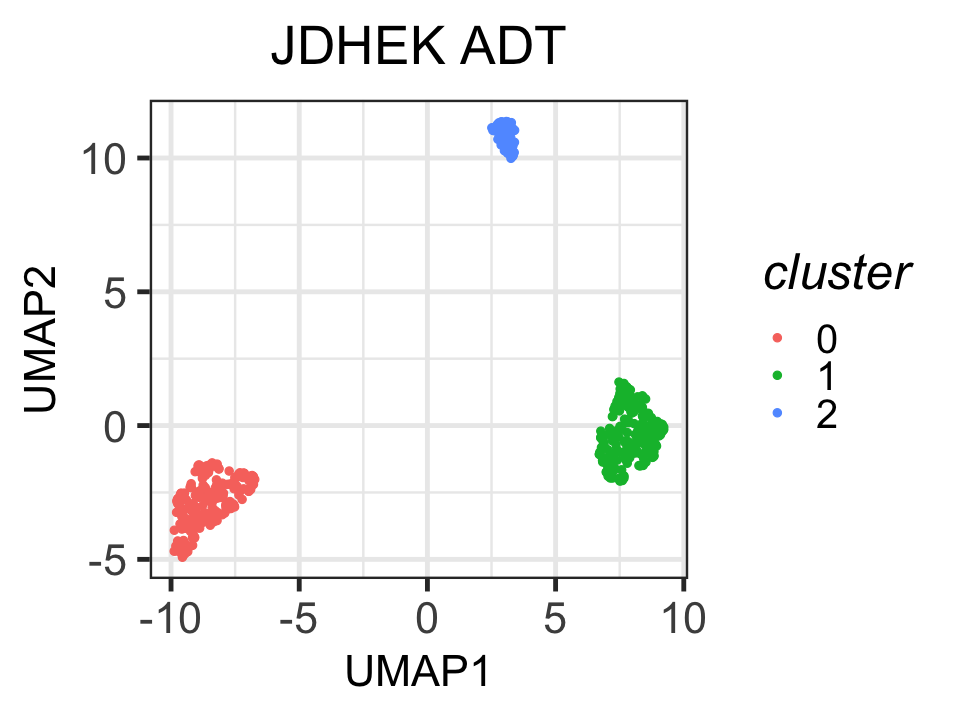

In [70]:
fig.size(6, 8)
ggplot(meta_umap_adt.clust[sample(rownames(meta_umap_adt.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_gy(30)+
    ggtitle('JDHEK ADT')

In [72]:
#Overlapping cells
intersect(rownames(meta_umap),
         rownames(meta_umap_adt)) %>% length

[1] 526

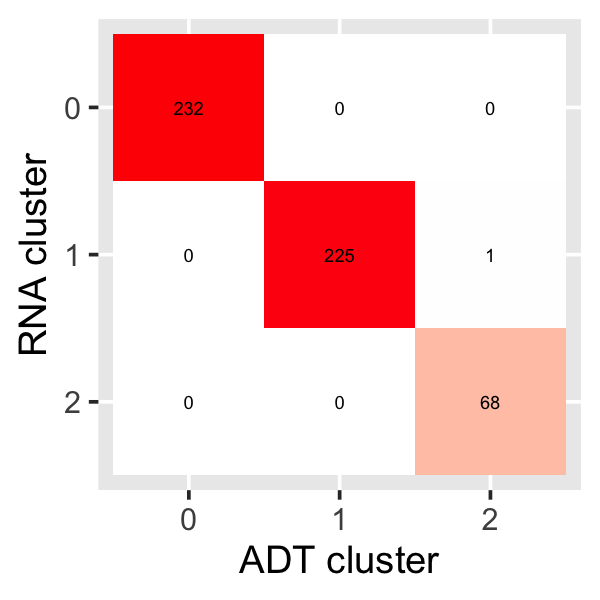

In [73]:
# Compare cluster concordance in RNA vs protein
intersect_cells = intersect(rownames(meta_umap_adt.clust), rownames(meta_umap.clust))
concordance_RNAprot = table(meta_umap_adt.clust[intersect_cells, 'cluster'],
                                 meta_umap.clust[intersect_cells, 'cluster']) %>% as.data.frame

# Order clusters in plot
concordance_RNAprot$Var2 = factor(concordance_RNAprot$Var2, 
                                       levels = c(2, 1, 0))
concordance_RNAprot$Var1 = factor(concordance_RNAprot$Var1, 
                                       levels = c(0, 1, 2))

fig.size(5, 5)
ggplot(concordance_RNAprot)+
    geom_tile(aes(x = Var1, y = Var2, fill = Freq))+
    geom_text(aes(x = Var1, y = Var2, label = Freq)) +
    scale_fill_gradient(low = "white", high = "red")+
    theme_g()+
    xlab('ADT cluster')+
    ylab('RNA cluster') + theme(legend.position = "none")

In [74]:
plot_exprs <- function (scale_exprs, meta_umap, markers, fig_size = c(6, 8)) 
{
    exprs_umap = cbind(meta_umap, scale_exprs[, rownames(meta_umap)] %>% 
        t)
    fig.size(fig_size[1], fig_size[2])
    for (marker in markers) {
        print(ggplot(exprs_umap) + geom_point(aes(x = UMAP1, 
            y = UMAP2, col = eval(parse(text = marker))), size = 3) + 
            labs(col = marker) + theme_g(30) + scale_color_viridis() + theme_gy())
    }
}

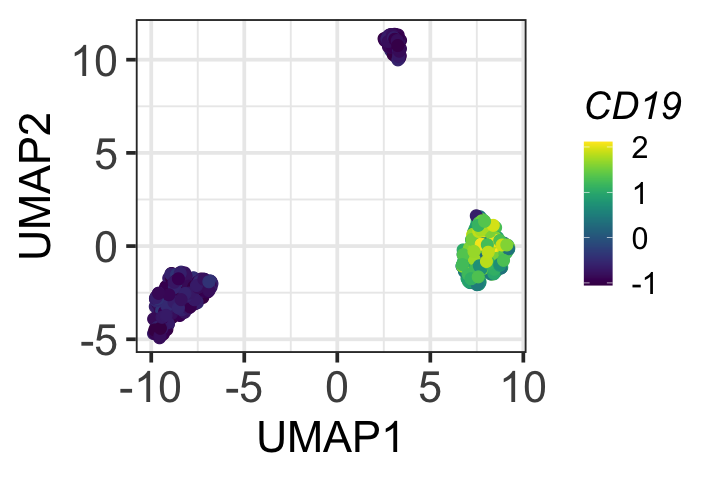

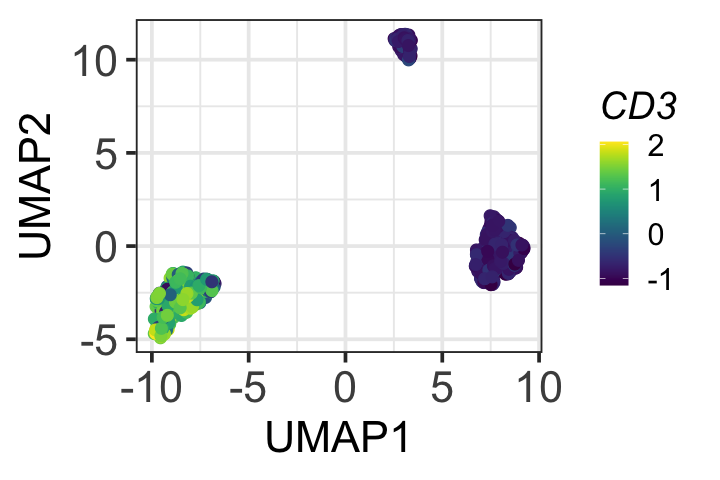

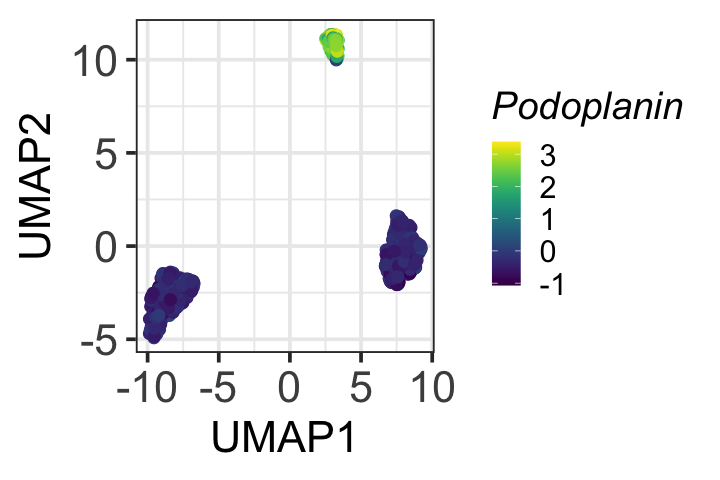

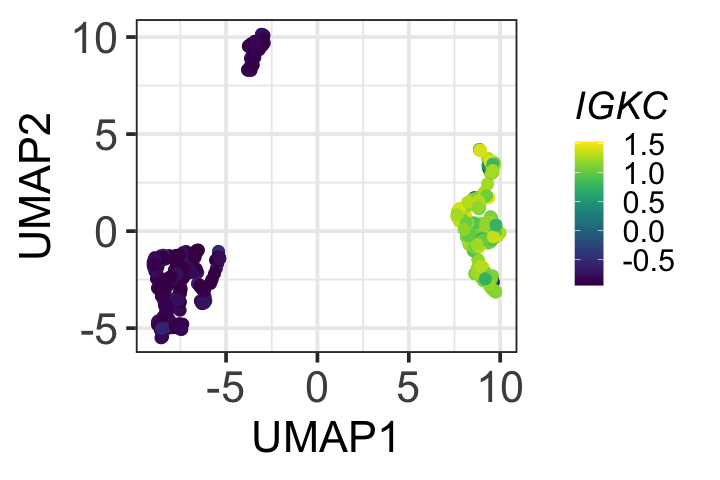

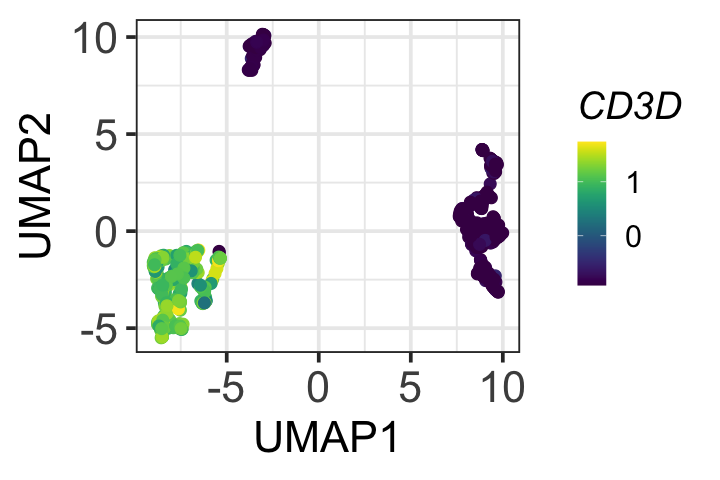

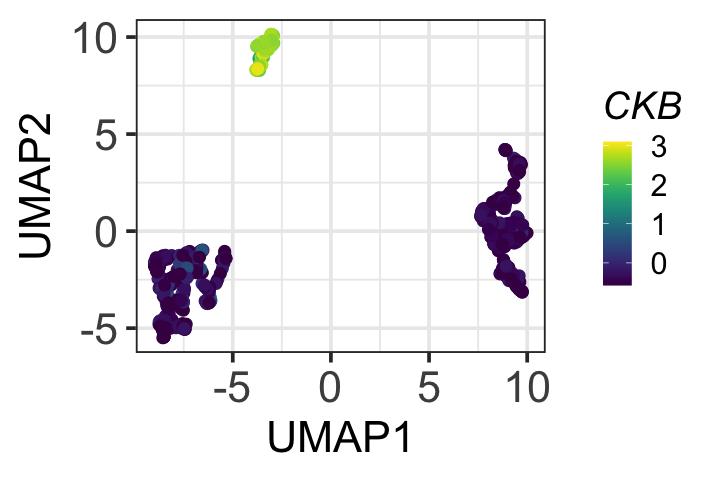

In [77]:
plot_exprs(scale_adt, meta_umap_adt.clust, markers = c("CD19", "CD3", "Podoplanin"), fig_size = c(4,6))
plot_exprs(scale_exprs, meta_umap.clust, markers = c("IGKC", "CD3D", "CKB"),fig_size = c(4,6))

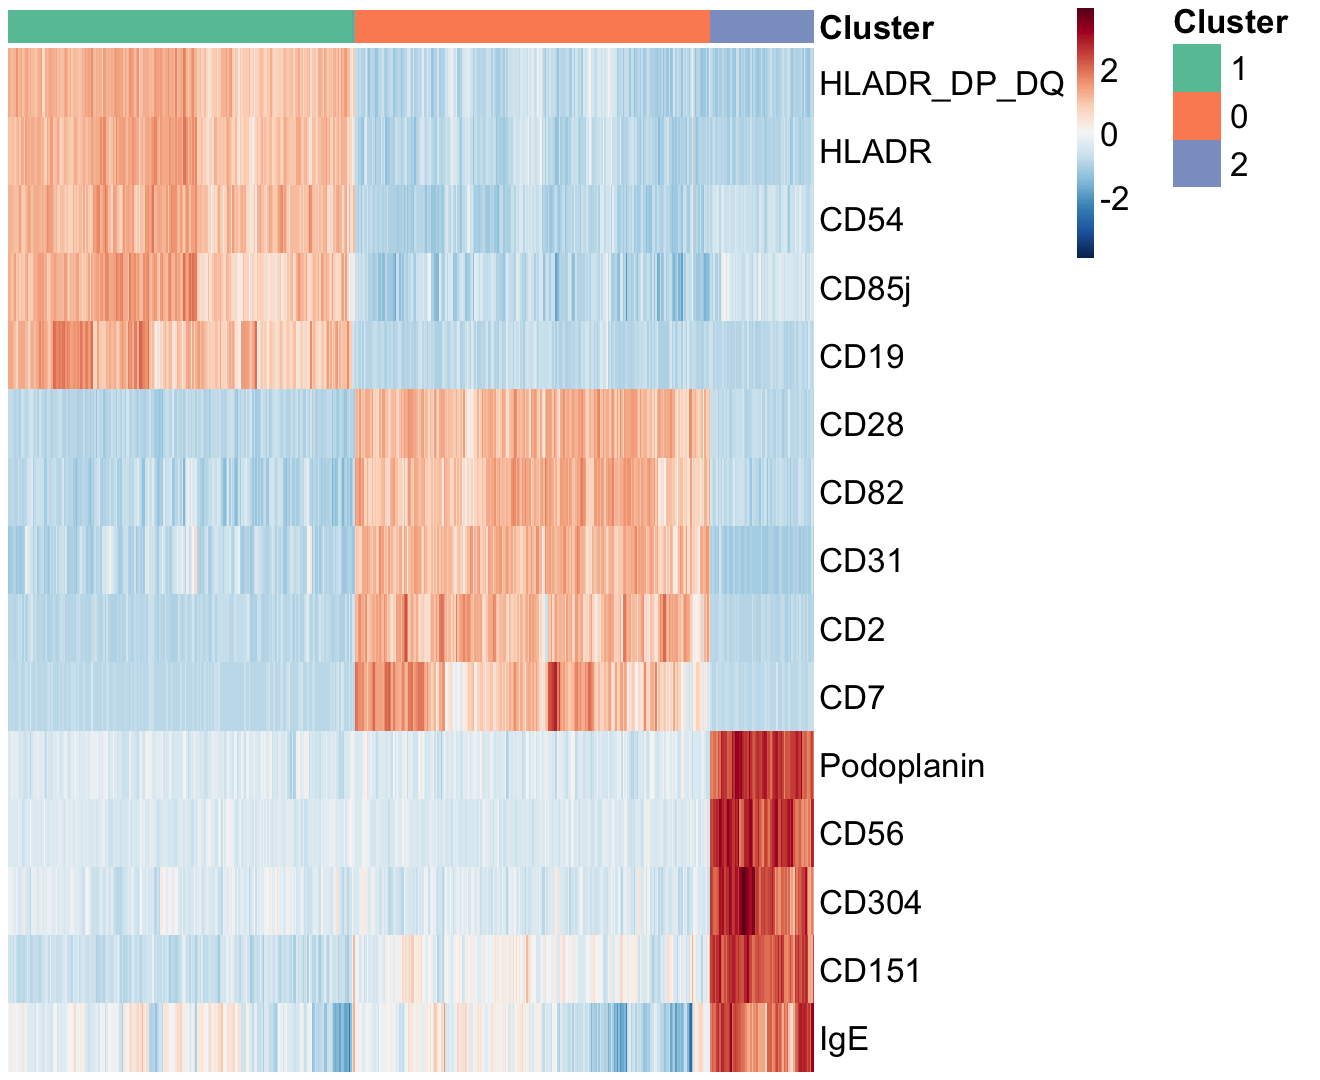

In [79]:
meta <- meta_umap_adt.clust
df <- scale_adt[,meta$cell]

    
    dge = wilcoxauc(df, meta$cluster)
    var_genes = top_markers(dge, 5) %>% head(5) %>% select(-rank) %>% unlist %>% unique
    cmax = abs(df[var_genes, ]) %>% unlist %>% max
    
    mat_col <- data.frame(Cluster = meta$cluster)
    rownames(mat_col) <- rownames(meta)
    
    mat_colors <- list(Cluster = c(
        "1" = "#66C2A5", 
        "0" = "#FC8D62", 
        "2" = "#8DA0CB"))
    
    mat_cluster_cols <- hclust(dist(t(df[var_genes, ])))
    mat_cluster_cols <- sort_hclust(mat_cluster_cols)
    mat_cluster_rows <- sort_hclust(hclust(dist(df[var_genes, 
        ])))
   
fig.size(9, 11)
    pheatmap(df[var_genes, ],
            # main = "Scaled TPM PTEN", 
             breaks = seq(-cmax, cmax, length.out = 100), 
             color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev, 
             show_colnames = FALSE, 
             annotation_col = mat_col, 
             annotation_colors = mat_colors,
            fontsize = 20, 
             cluster_cols = mat_cluster_cols, 
             cluster_rows = mat_cluster_rows, 
             treeheight_row = 0, 
            treeheight_col = 0)

# Processing for figures and analysis

In [98]:
##full normalized and scaled expression
filt_norm_scale_exprs <- filt_exprs %>% singlecellmethods::normalizeData(method = "log") %>% 
    singlecellmethods::scaleData()

In [99]:
#normalized expression
norm_exprs <- filt_exprs %>% singlecellmethods::normalizeData(method = "log")

In [100]:
norm_filt_exprs <- norm_exprs %>% t %>% as_tibble(rownames = "cell") 

In [101]:
CLR_adt_filt <- counts_ADT_filt%>% singlecellmethods::normalizeData(method = "cellCLR")%>% t %>% 
    as_tibble(rownames = "cell") 

# Merging Data Types

In [103]:
##Merge all three data sets
Plots <- alleles_DNA_filt_gen %>% rename(Well = "Well_ID") %>% 
    inner_join(read_csv("PlateMeta2Full.csv")) %>% 
    inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% 
    mutate("cell" = paste0(RNA_cell, "_", Barcode_RNA)) %>% 
    inner_join(dplyr::select(meta_umap_adt.clust, cell, cluster, UMAP1, UMAP2)) %>% 
    inner_join(dplyr::select(meta_umap.clust, cell, cluster, UMAP1, UMAP2), by = "cell") 

##Add FlowData to this. 
Plots <- FlowMatrix %>%  
    inner_join(Plots) %>% na.omit %>% 
    mutate("genotype3" = ifelse(Edited_Index == "Edited", 
                                ifelse(genotype == "2", "A/A", 
                                ifelse(genotype == "4", "A/G", 
                                ifelse(genotype == "1", "G/G", "Other"))), 
                                "Control")) %>% 
    mutate("genotype3" = fct_relevel(genotype3, 
            "Control", "A/A", "A/G", 
            "G/G"))

Rows: 10 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Condition, Barcode_RNA, Barcode_ADT, Barcode_DNA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Barcode_DNA)`
Rows: 384 Columns: 2
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`
Joining with `by = join_by(cell)`
Joining with `by = join_by(Well_ID, RNA_cell, Condition, Barcode_RNA, Barcode_ADT, Barcode_DNA, cell)`


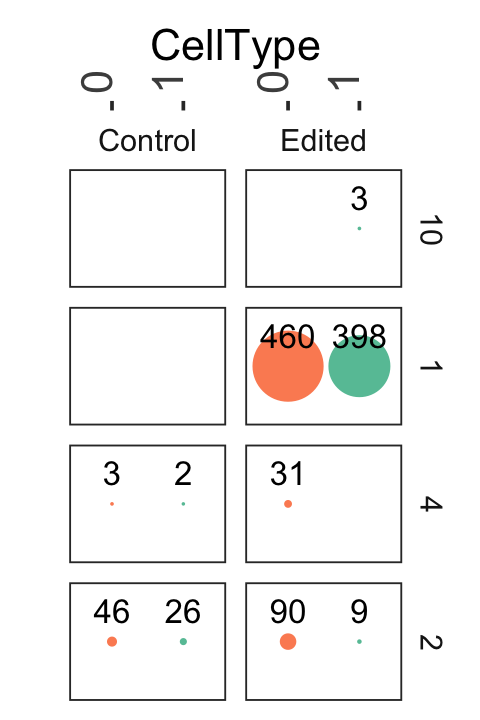

In [105]:
## Plot of PTEN genotypes distributions across RNA clusters
## Define df for plotting 
df <- Plots %>% add_count(genotype,name = "genotype_count") %>% 
    filter(genotype_count  > 2)

#Defineplotting Order
order <- df$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)


fig.size(6,4)
g <- 

table(df$genotype,df$cluster.x, df$Edited_Index) %>% 
as.data.frame() %>% dplyr::rename(CellType = Var2, genotype = Var1, Edited_Index = Var3) %>% 
na.omit %>% filter(Freq != 0) %>% {
    
    ggplot(., aes(CellType,fill=CellType,
                   size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =7, vjust = -0.8)+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor((genotype), levels = c("10","1", "4", "2"))~ 
               Edited_Index) + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        ) +scale_fill_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))
    
} 
plot(g)


Saving 7 x 7 in image


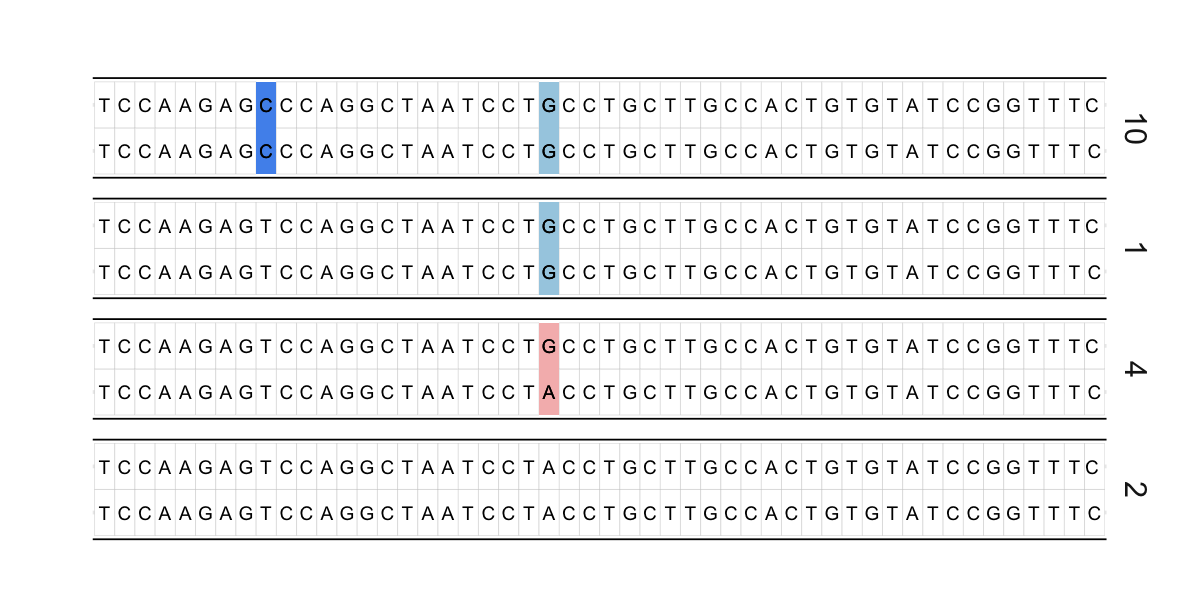

In [106]:
fig.size(5,10)
#Define order
order <- Plots$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)
#Make DF for plotting
df<- GenotypeHeatmap2(Plots, 2)
#Fix order
df$genotypes <- factor(df$genotypes, levels = order)

g <-     

g<- df %>% #the number is the filter on genotype 
ggplot(aes(x = reorder(position, as.integer(position)), 
           y = allele, fill = `value`)) + 
    geom_tile(aes(color = value), width=1, height=1) +
        geom_text(data = dplyr::filter(df),
                  aes(label = `allele_value`), angle = 0, size = (4)) + 
        geom_text(data = dplyr::filter(df, value != "R"),
                  aes(label = allele_value), angle = 0, size = (4))+
        scale_fill_manual(values = 
                    c(R = 'white',
                    CC = "#5194ed", 
                      TT = "#fdb462", 
                      CT = "#7fc97f", 
                      GT = "#ef3b2c",
                      CG = "#f5aa87",
                      GG = "#a6cee3",  
                      AG = "#f5bbba",
                      AA = "#fae1e1",
                     `-A`= "grey90", 
                     `-T` = "grey90", 
                     `-C` = "grey90", 
                     `-G` = "grey90", 
                     `--` ="grey80"))+ 
        scale_color_manual(values = 
                   c(R = 'grey',
                      CC = "NA", 
                      TT = "NA", 
                      CT = "NA", 
                      GT = "NA",
                      CG = "NA",
                      GG = "NA",  
                     AG = "NA"))+ 
     #c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33"))
        ggtitle("") + 
        theme_gy()+
    xlab("")+
    theme(aspect.ratio = 0.1)+ 
    ylab("") +
    theme(axis.text.y = element_text(size = 0, angle = 0, hjust = .5, vjust = .5),
          axis.text.x = element_text(size = 0),
        axis.title.x = element_text(size = 20, angle = 0, hjust = .5, vjust = .5),
        axis.title.y = element_text(size = 20, angle = 90, hjust = .5, vjust = .5),
          axis.ticks.y = element_blank(),
         legend.position = "none") + 
    scale_x_discrete(breaks=NULL) + 
    facet_grid(factor((genotypes), levels = c("10","1", "4", "2"))~.)+ 
theme(
  strip.background = element_blank(),
  strip.text.x = element_blank(), 
    panel.border=element_blank()

) + 
    annotate(geom = 'segment', y = Inf, yend = Inf, color = 'black', x = -Inf, xend = Inf, size = 1) + 

    annotate(geom = 'segment', y = -Inf, yend = -Inf, color = 'black', x = -Inf, xend = Inf, size = 1)
plot(g)


Joining with `by = join_by(cell)`


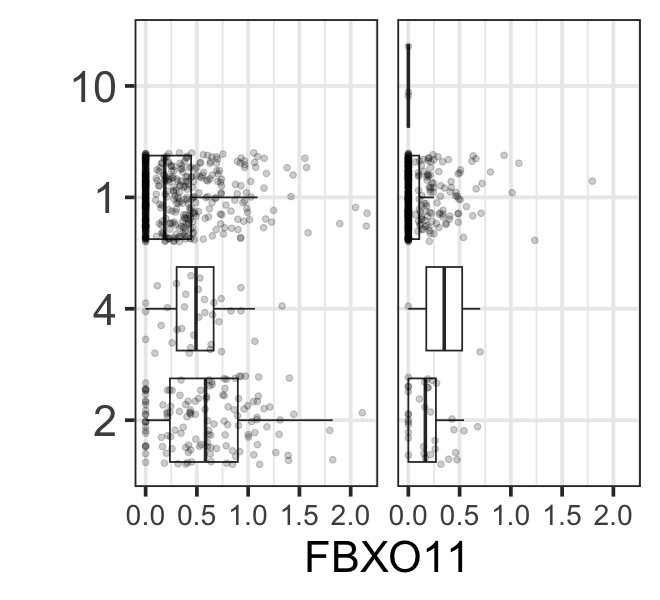

In [107]:
#Gene expression across genotypes
fig.size(5, 5.5)

norm_exprs["FBXO11", Plots$cell] %>% as_tibble(rownames = "cell") %>% inner_join(Plots) %>% 
 add_count(genotype,name = "genotype_count") %>% filter(genotype_count >2) %>%{
ggplot(.) +  
geom_boxplot(outlier.alpha = 0,
             aes(factor((genotype), levels = rev(c("10","1", "4", "2"))), `value`)) + 

geom_jitter(aes(factor((genotype), levels = rev(c("10","1", "4", "2"))), `value`), 
           alpha = 0.2) + 
theme_gy()+
#scale_x_discrete(limits = c("Control", 
 #                          "Edited", 
  #                         "A/A",
   #                        "A/G", 
    #                       "G/G"
     #                      )) + 

xlab("") + 
ylab("FBXO11")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x) 
    } + coord_flip() + 
    theme(strip.text = element_blank(), axis.text.x = element_text(size = 17))

Joining with `by = join_by(cell)`
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


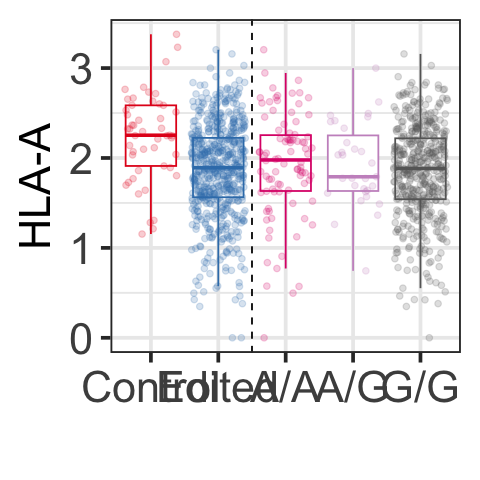

In [109]:
#Example plot for genes of interest
fig.size(4, 4)

df <- norm_exprs["HLA-A",] %>% as_tibble(rownames = "cell") %>% inner_join(
    Plots %>% filter(cluster.x == 0)) 

ggplot(df) +  
geom_boxplot(outlier.alpha = 0,
             aes(Edited_Index, `value`, color = Edited_Index)) + 
geom_boxplot(outlier.alpha = 0, 
             data = filter(df, genotype3 != "Control"),
             aes(genotype3, `value`, color = genotype3)) +
geom_jitter(aes(Edited_Index, `value`, color = Edited_Index), 
           alpha = 0.2) + 
geom_jitter(data = filter(df, genotype3 != "Control"),
             aes(genotype3, `value`, color = genotype3), 
           alpha = 0.2) + 
theme_gy()+
scale_x_discrete(limits = c("Control", 
                           "Edited", 
                           "A/A",
                           "A/G", 
                           "G/G"
                           )) + 
geom_vline(xintercept = 2.5, linetype = 2) + 
scale_color_manual(values = c(
              "Control" = "#E41A1C",
              "Edited" = "#377EB8",
              "A/A" = "#DD1C77", 
              "A/G" = "#C994C7",
              "G/G" = "grey40"))+ 
xlab("") + 
ylab("HLA-A")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x) +theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x)  + 
    theme(strip.text = element_blank())
    

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


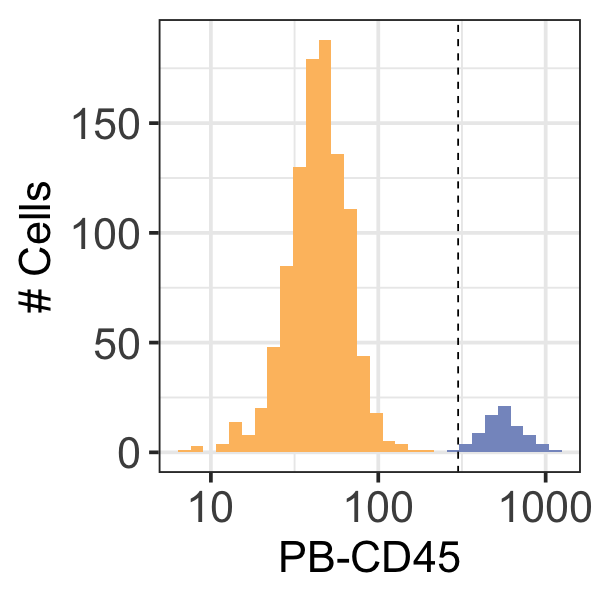

In [110]:
#CRISPR gating - index sort - defining editing vs not. 
fig.size(5, 5)

Plots %>%
ggplot() +  
geom_histogram(aes(x = PB_CD45, fill = Edited_Index)) + 
scale_x_log10()+
theme_gy()+
scale_fill_manual(values = c(
          "Control" = "#8698C7",
          "Edited" = "#FDBF6E",
          "A/G" = "#C994C7",
          "A/A" = "#DD1C77", 
          "G/G" = "grey"))+   
theme(legend.position = "none") +
geom_vline(xintercept = 300, linetype =2) + 
xlab("PB-CD45") + 
ylab("# Cells")

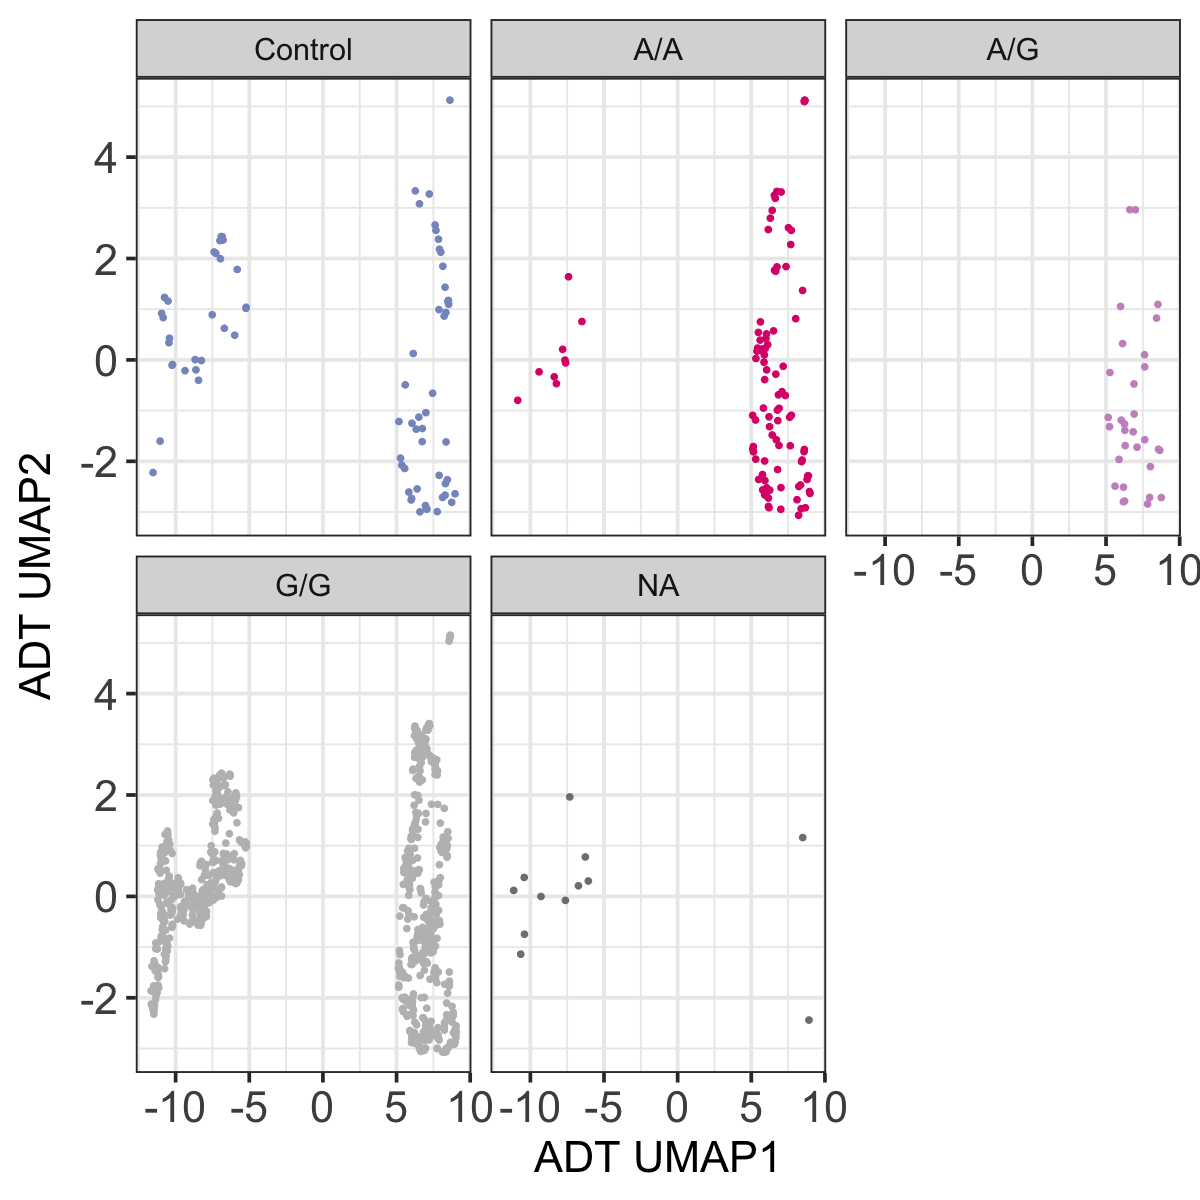

In [111]:
fig.size(10,10)
## Facet by genotype
Plots %>% ggplot(aes(UMAP1.y, UMAP2.y, color = genotype3)) + 
geom_point() + 
facet_wrap(~factor(genotype3, levels = c("Control", 
                                        "A/A",
                                        "A/G", 
                                        "G/G"))) + theme_gy() + 
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "Edited" = "#FDBF6E",
          "A/G" = "#C994C7",
          "A/A" = "#DD1C77", 
          "G/G" = "grey"))+ 
theme(legend.position = "none") + 
xlab("ADT UMAP1") + 
ylab("ADT UMAP2")



In [311]:
##Merge all three data sets
## read in matrix from other work sheet defining cluster

DQB1Plots <- read_csv("DQB1matrix.csv") %>% select(cell, DQB1deletion_Mean, KClust, Edited_Index2) %>% 
    inner_join(select(meta_umap_adt_DQB1.clust, cell, cluster, UMAP1, UMAP2, nUMI, nGenes)) %>% # Add meta adt data
    inner_join(select(meta_umap_DQB1.clust, cell, cluster, UMAP1, UMAP2, nUMI, nGenes), by = "cell")  #add meta RNA data

##Add FlowData to this. 
DQB1Plots <- FlowMatrix %>%
    mutate("Experiment_Index" = ifelse(Experiment_Index == "PTEN", "JDHEK", Experiment_Index)) %>% 
    mutate(Condition = paste0(Experiment_Index, "_", Plate))  %>%
    inner_join(read_csv("PlateMeta2Full.csv")) %>% 
    mutate("cell" = paste0(RNA_Barcode, "_", Barcode_RNA)) %>% 
    inner_join(DQB1Plots) %>% na.omit
DQB1Plots%>% head
#Save meta data files
DQB1Plots %>% write_csv("DQB1Plots.csv")
DQB1Plots<- read_csv("DQB1Plots.csv")

Rows: 721 Columns: 389
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (26): Barcode_DNA, Well_ID.x, Condition, Barcode_RNA, Barcode_ADT, RNA_...
dbl (363): DQB1deletion_Mean, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(cell)`
Rows: 10 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Condition, Barcode_RNA, Barcode_ADT, Barcode_DNA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Condition)`
Joining with `by = join_by(cell)`


Well_ID DNA_Barcode RNA_Barcode    Experiment_Index Plate PB_CD45  
1 A1      AACACGAGGA  AACATCTCTGTGAC DQB1             P1     21.28752
2 A2      AACCAATGAC  AACCAACCAGACTC DQB1             P1    105.07137
3 A3      AACGACTCCA  AACCGTATGCGGTG DQB1             P1     78.43886
4 A3      AACGACTCCA  AACCGTATGCGGTG DQB1             P2     74.98942
5 A3      AACGACTCCA  AACCGTATGCGGTG DQB1             P4    117.57433
6 A4      AACGTATACC  AACCGTGCCACATA DQB1             P1    831.61416
  BV605_CD45 SSC       FSC      FITC_DQB1 ⋯ cluster.x UMAP1.x   UMAP2.x   
1  295.5991   6731.704 29032.91  107.4608 ⋯ 1          6.672213 -1.9406789
2  995.5129  40679.443 38025.78 2236.7084 ⋯ 0         -7.732679  2.0181108
3  634.9425  26535.552 43518.30 1333.5214 ⋯ 0         -7.364677  1.9961778
4 1018.1517  20260.055 31765.31  378.5515 ⋯ 1          5.562515 -1.1025983
5  236.0733  37180.267 34754.87 3064.2777 ⋯ 0         -6.148256 -2.5498857
6  433.2302  12921.952 25368.62  161.0762 ⋯ 1          8.432272 -0.9523577
  nUMI.x nGenes.x cluster.y UMAP1.y   UMAP2.y    nUMI.y nGenes.y
1  4765  137      0         -7.265769  4.4356597  15848 2744    
2 15187  151      1         10.362779  2.5369396 107965 7505    
3 11900  146      1          7.998463  0.5772439  78917 6195    
4  9612  148      0         -7.456430 -3.0653818  88916 6578    
5 15796  146      1          9.657458 -3.0779700  46599 4981    
6  3052  126      0         -8.762729 -1.3584078  38058 5021

Rows: 646 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): Well_ID, DNA_Barcode, RNA_Barcode, Experiment_Index, Plate, FBXO11...
dbl (21): PB_CD45, BV605_CD45, SSC, FSC, FITC_DQB1, PE_CD40, PECY7_CD45, APC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


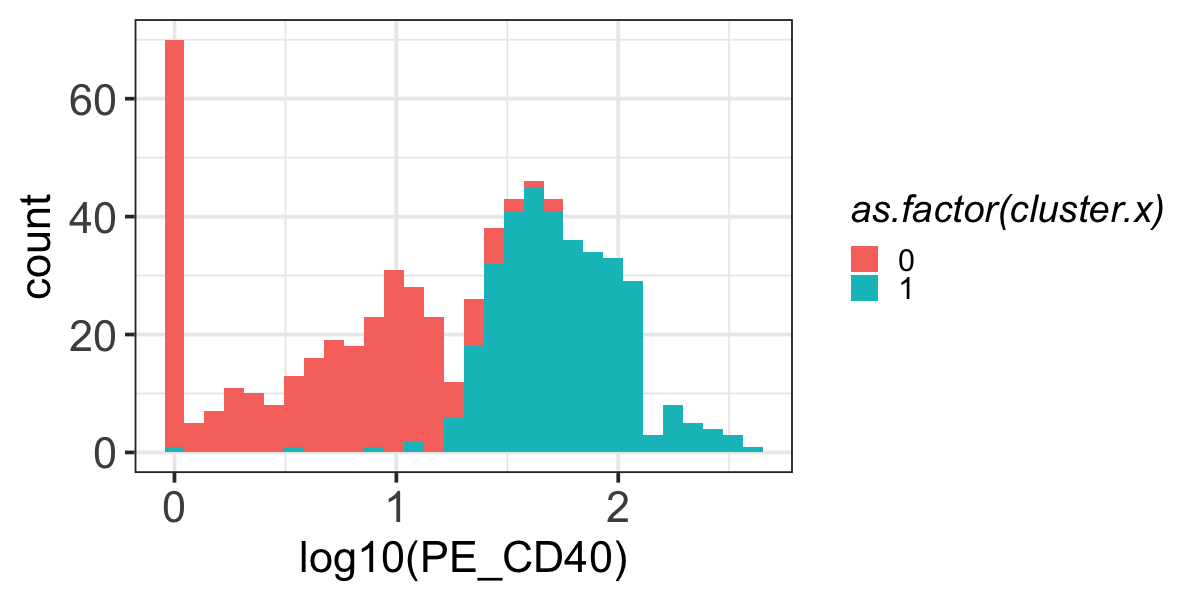

In [319]:
fig.size(5,10)
DQB1Plots %>% ggplot(aes(log10(PE_CD40), fill = as.factor(cluster.x))) + geom_histogram() + theme_gy()


In [315]:
library(lme4)

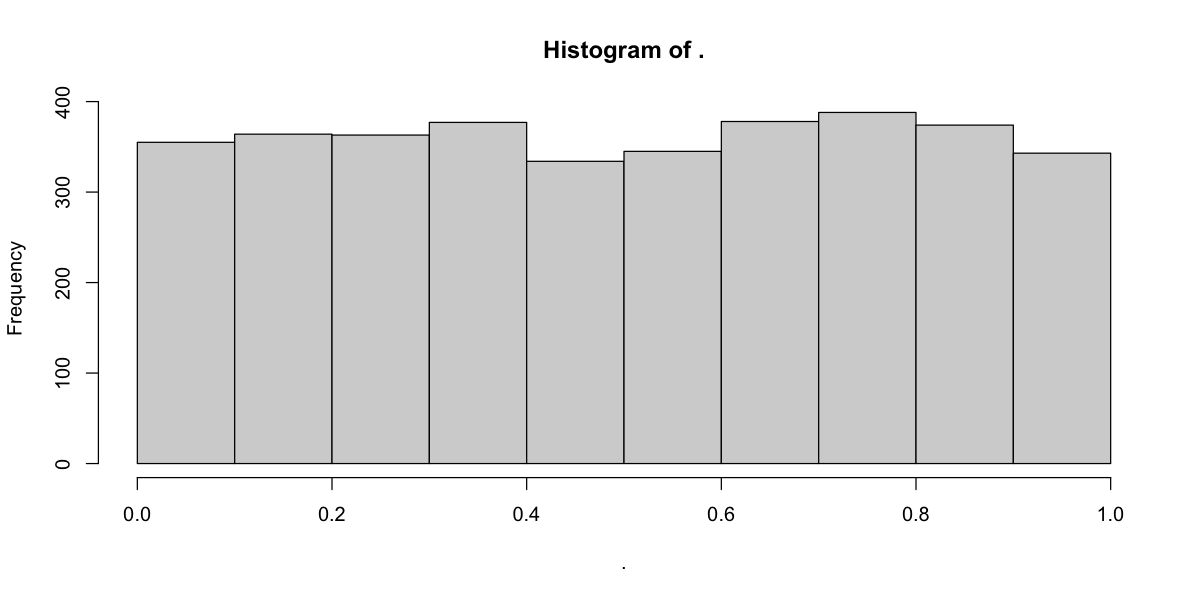

In [352]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- Daudi_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 1))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(which(rowSums(Exprs)/length(cells)> 2))

suppressWarnings({
DQB1_lm_Daudi <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + log2(DQB1deletion_Mean+1)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_Daudi<- DQB1_lm_Daudi %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_Daudi %>% with(pval) %>% hist
DQB1_lm_Daudi <- DQB1_lm_Daudi %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

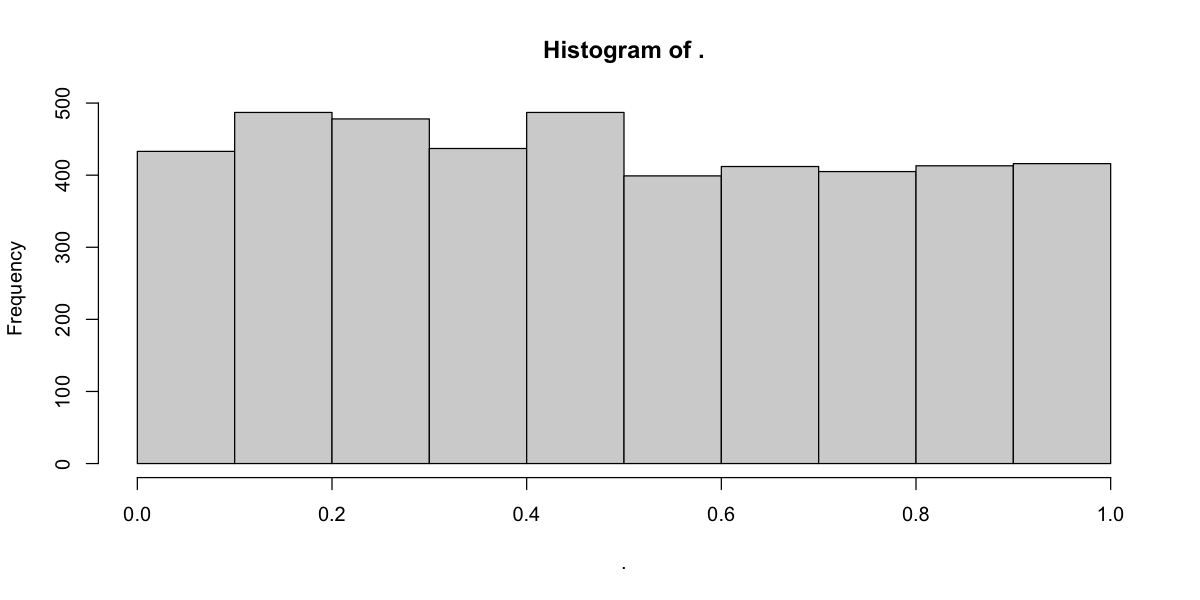

In [353]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- HH_DQB1
nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

DQB1_exprs <- filt_exprs[gene_qc %>% filter(nCells > length(HH_DQB1)*0.3) %>% rownames, HH_DQB1]
genes <- names(which(rowSums(DQB1_exprs)/length(cells)> 2))

suppressMessages({
    suppressWarnings({
DQB1_lm_HH <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = (DQB1Plots %>% filter(cluster.x == 0)),  
          formula = (DQB1_exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = (DQB1Plots %>% filter(cluster.x == 0)),  
          formula = (DQB1_exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + log2(DQB1deletion_Mean+1)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
        })
    })
DQB1_lm_HH<- DQB1_lm_HH %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_HH %>% with(pval) %>% hist
DQB1_lm_HH <- DQB1_lm_HH %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [ ]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- Daudi_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 1))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(rowSums(Exprs)/length(cells)> 1.5)

suppressWarnings({
DQB1_lm_Daudi_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index2
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_Daudi_Edited<- DQB1_lm_Daudi_Edited %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_Daudi_Edited %>% with(pval) %>% hist
DQB1_lm_Daudi_Edited <- DQB1_lm_Daudi_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [ ]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- HH_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 0))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(rowSums(Exprs)/length(cells)> 1.5)

suppressWarnings({
DQB1_lm_HH_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index2
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_HH_Edited<- DQB1_lm_HH_Edited %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_HH_Edited %>% with(pval) %>% hist
DQB1_lm_HH_Edited <- DQB1_lm_HH_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [355]:
DQB1_lm_Daudi %>% head 

DQB1_lm_HH %>% head 


Genes    pval                beta        padj           
1 HLA-DQB1 0.00000000004655876 -0.29282038 0.0000001685893
2 DDA1     0.00068328850994226  0.12742387 0.7600674480927
3 BCAT2    0.00080474034487499 -0.14457260 0.7600674480927
4 USP10    0.00104278354174669  0.09325347 0.7600674480927
5 MRPS34   0.00131501728937677 -0.07506626 0.7600674480927
6 IQGAP1   0.00138313369551013  0.13393035 0.7600674480927

Genes      pval               beta        padj          
1 HLA-DQB1   0.0000000005790215 -0.18069967 0.000002528587
2 MIR155HG   0.0000831794137792  0.09370005 0.181622249987
3 AC078923.1 0.0003028954732944 -0.04693051 0.440914843959
4 TARS2      0.0010508621281626  0.13171014 0.822922171437
5 CAMK1D     0.0010533319666147  0.17700587 0.822922171437
6 RPIA       0.0013879528159063  0.06925124 0.822922171437

In [1589]:
#creating norm_adt 
norm_adt <- counts_ADT_filt %>% singlecellmethods::normalizeData(method = "cellCLR")

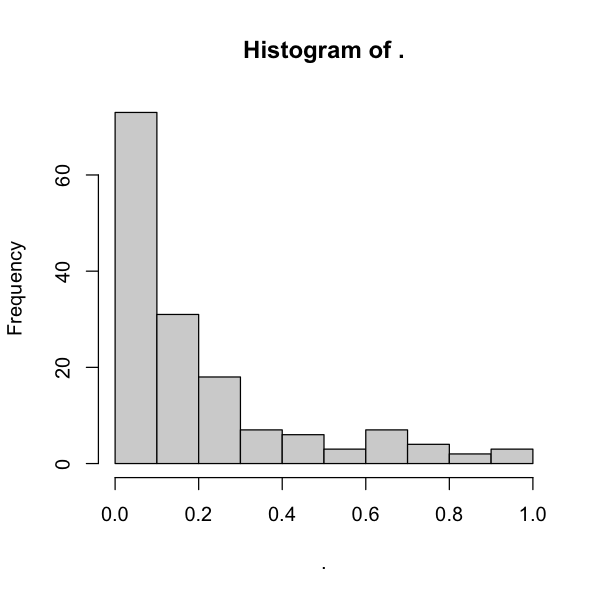

In [2448]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- HH_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 0))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
DQB1_lm_HH_adt <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + log2(DQB1deletion_Mean + 1)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_HH_adt<- DQB1_lm_HH_adt %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_HH_adt %>% with(pval) %>% hist
DQB1_lm_HH_adt <- DQB1_lm_HH_adt %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

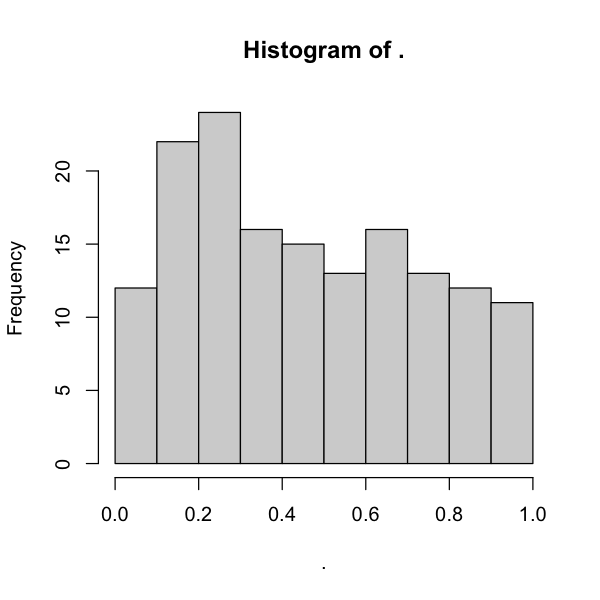

In [2450]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- Daudi_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 1))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
DQB1_lm_Daudi_adt <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + log2(DQB1deletion_Mean + 1)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_Daudi_adt<- DQB1_lm_Daudi_adt %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_Daudi_adt %>% with(pval) %>% hist
DQB1_lm_Daudi_adt <- DQB1_lm_Daudi_adt %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

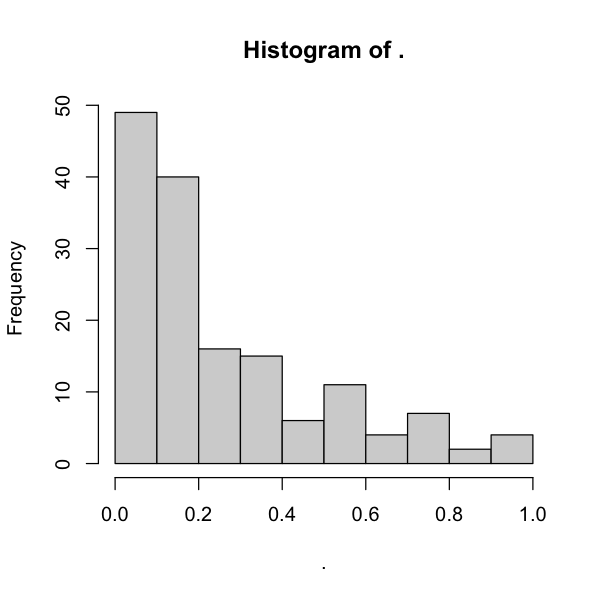

In [2452]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- HH_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 0))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
DQB1_lm_HH_adt_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index2
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_HH_adt_Edited<- DQB1_lm_HH_adt_Edited %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_HH_adt_Edited %>% with(pval) %>% hist
DQB1_lm_HH_adt_Edited <- DQB1_lm_HH_adt_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

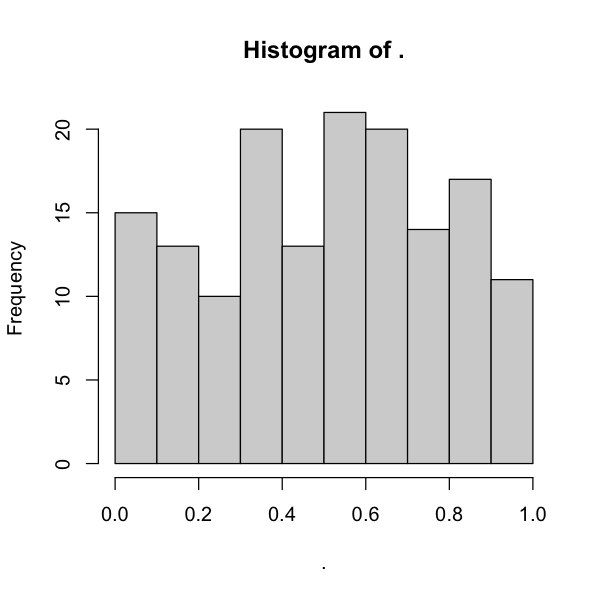

In [2453]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- Daudi_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 1))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
DQB1_lm_Daudi_adt_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index2
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_Daudi_adt_Edited<- DQB1_lm_Daudi_adt_Edited %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_Daudi_adt_Edited %>% with(pval) %>% hist
DQB1_lm_Daudi_adt_Edited <- DQB1_lm_Daudi_adt_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [2455]:
DQB1_lm_Daudi_adt_Edited %>% head
DQB1_lm_HH_adt_Edited %>% head

Genes pval         beta       padj      
1 CD45  0.0005356091  0.2783255 0.08248379
2 CD151 0.0065257682 -0.2469730 0.47325328
3 CD62L 0.0092192198 -0.2812650 0.47325328
4 CD63  0.0186368793 -0.2047818 0.68777290
5 Ig_L  0.0223302890  0.2660922 0.68777290
6 CD21  0.0369702940 -0.2076064 0.86443685

Genes         pval        beta      padj     
1 TCR_Valpha7.2 0.001464300 0.4189374 0.2255021
2 CD45          0.007646605 0.3253113 0.3015580
3 CD305         0.012531069 0.4921059 0.3015580
4 CD86          0.018832008 0.3077932 0.3015580
5 CD116         0.018869699 0.2660997 0.3015580
6 CD127         0.022560128 0.2798562 0.3015580

In [2676]:
# Generalized Function. 

In [2707]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
lm_nb_rna <- function(cells, exprs, meta, cutoff,formula1, formula2 ){

Exprs <- exprs[,cells]
genes <- rownames(exprs)
    
nCells = rowSums(exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- rownames(Exprs)

suppressWarnings({
Model <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ as.formula(formula1)
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ as.formula(formula2)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],"beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[2],1]))
        })
    })
Model<- Model %>% t %>% as_tibble(rownames = "Genes")
Model %>% with(pval) %>% hist
Model <- Model %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))
    return(Model)
    }

In [399]:
gtf <- read_tsv("mart_export.tsv")

Rows: 276950 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): Gene stable ID, Transcript stable ID, Transcript name, Protein stab...
dbl (3): Gene start (bp), Gene end (bp), Strand

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [400]:
colnames(gtf) <- c("geneID", "transcriptID", "Start", "End", "TranscriptName", "ProteinID", "Strand", "Chr", "Gene")

In [401]:
gtf_filt <- gtf %>% dplyr::select(Gene, Start, Chr) %>% unique

In [402]:
#Combine HH and Daudi results
Mix <- rbind(DQB1_lm_Daudi %>% mutate("CellType" = "Daudi"),
DQB1_lm_HH %>% mutate("CellType" = "HH"))

In [403]:
Mix<- Mix %>% rename(Genes = "Gene")

In [404]:
manh <- Mix %>% inner_join(gtf_filt)
manh<- manh %>% filter(Chr %in% 1:24) %>% mutate(Chr = as.numeric(Chr)) 
### do it with ggplot damnit
## filter out non numeric Chr
don <- manh %>% 
  
  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 
  
  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  dplyr::select(-chr_len) %>%
  
  # Add this info to the initial dataset
  left_join(manh, ., by=c("Chr"="Chr")) %>%
  
  # Add a cumulative position of each SNP
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

Joining with `by = join_by(Gene)`
Warning message in inner_join(., gtf_filt):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 20714 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [405]:
#prepare the xaxis 
axisdf = don %>% group_by(Chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )


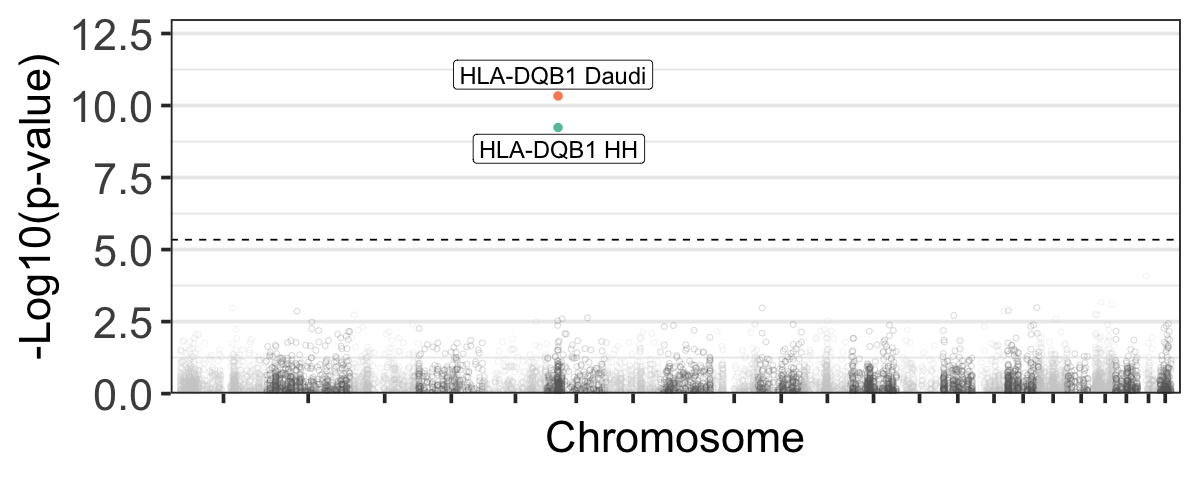

In [408]:
#define colors
colors = rep(c("grey80", "grey40"), 11 )
names(colors) = as.character(1:22)

fig.size(4,10)
g <- don %>% mutate(Gene = paste(Gene, CellType)) %>% 
{
ggplot(., aes(x=BPcum, y=-log10(pval))) +
    
    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha=0.2, size=1.3, shape = 1) +
    scale_color_manual(values = c(colors, 
                                    "HH" = "#66C2A5", 
                                    "Daudi" = "#FC8D62"))+
    
    # custom X axis:
    scale_x_continuous(expand = c(0.01,0.01),label = axisdf$Chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(NA, -log10(10^-13))) +     # remove space between plot area and x axis
  
    # Custom the theme:
    theme_gy() +
    theme(axis.text.x =element_text(size =0, vjust = 0.5, angle = -90),
      legend.position="none",
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) + 
    geom_label_repel(data = filter(., pval < 0.05/6136), 
                     aes(label = Gene), size=5) + 

    geom_point(data = filter(., pval < 0.05/6136), 
                     aes(color = CellType), size=2, ) +
geom_hline(yintercept = -log10(0.05/11000), linetype = 2)+
xlab("Chromosome") + 
ylab("-Log10(p-value)")
    }
plot(g)
suppressWarnings({ggsave(g, filename = "Man.png", device="png", width = 10, height = 4) })

`geom_smooth()` using formula = 'y ~ x'


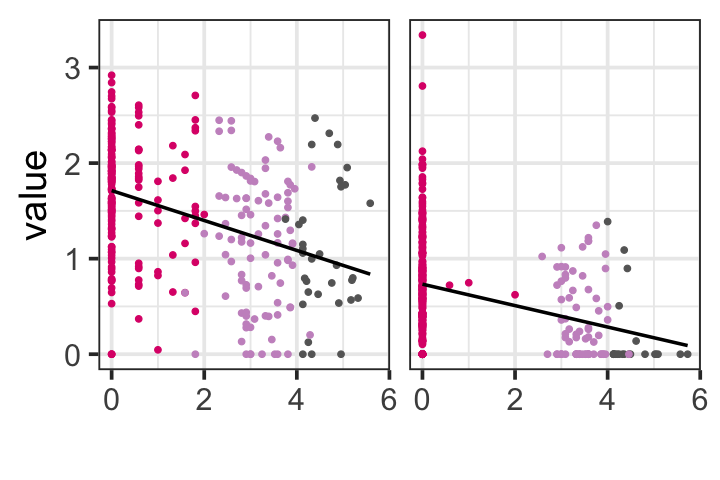

In [2548]:
fig.size(4, 6)

norm_exprs["HLA-DQB1",DQB1Plots$cell] %>% 
as_tibble(rownames = "cell") %>% inner_join(DQB1Plots, by ="cell") %>%  {

ggplot(., aes(x = log2(DQB1deletion_Mean + 1), y = value)) +  
    
geom_point(data = ., aes(color = as.factor(KClust)))  +

theme_gy()+
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "CRISPR" = "#FDBF6E",
          "1" = "#DD1C77", 
          "3" = "#C994C7",
          "2" = "grey40"))+ 
xlab("") + 
#ylab("CD45 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x)  + 
    theme(strip.text = element_blank()) + 
    geom_smooth(method = "lm", color = "black", se =F)
             }
    

In [2557]:
FBXO11_alleles_DNA_filt_gen_Viz_Daudi %>% head

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'FBXO11_alleles_DNA_filt_gen_Viz_Daudi' not found


# Statistical modeling of FBXO11 data

In [113]:
#Define Dosage
Plots2 <- Plots %>% mutate(Dosage = ifelse(genotype == 1, 2, 
                                      ifelse(genotype == 2, 0, 
                                            ifelse(genotype == 4,1, NA))))
Plots2 <- na.omit(Plots2) # Remove other cells

In [114]:
## adtUMI data
Plots2<- Plots2 %>% inner_join(dplyr::select(meta_umap_adt.clust, nUMI, cell)) %>% 
inner_join(dplyr::select(meta_umap.clust, nUMI, cell), by = "cell")

Joining with `by = join_by(cell)`


## Genotype Dependent DGE FBXO11 Daudis

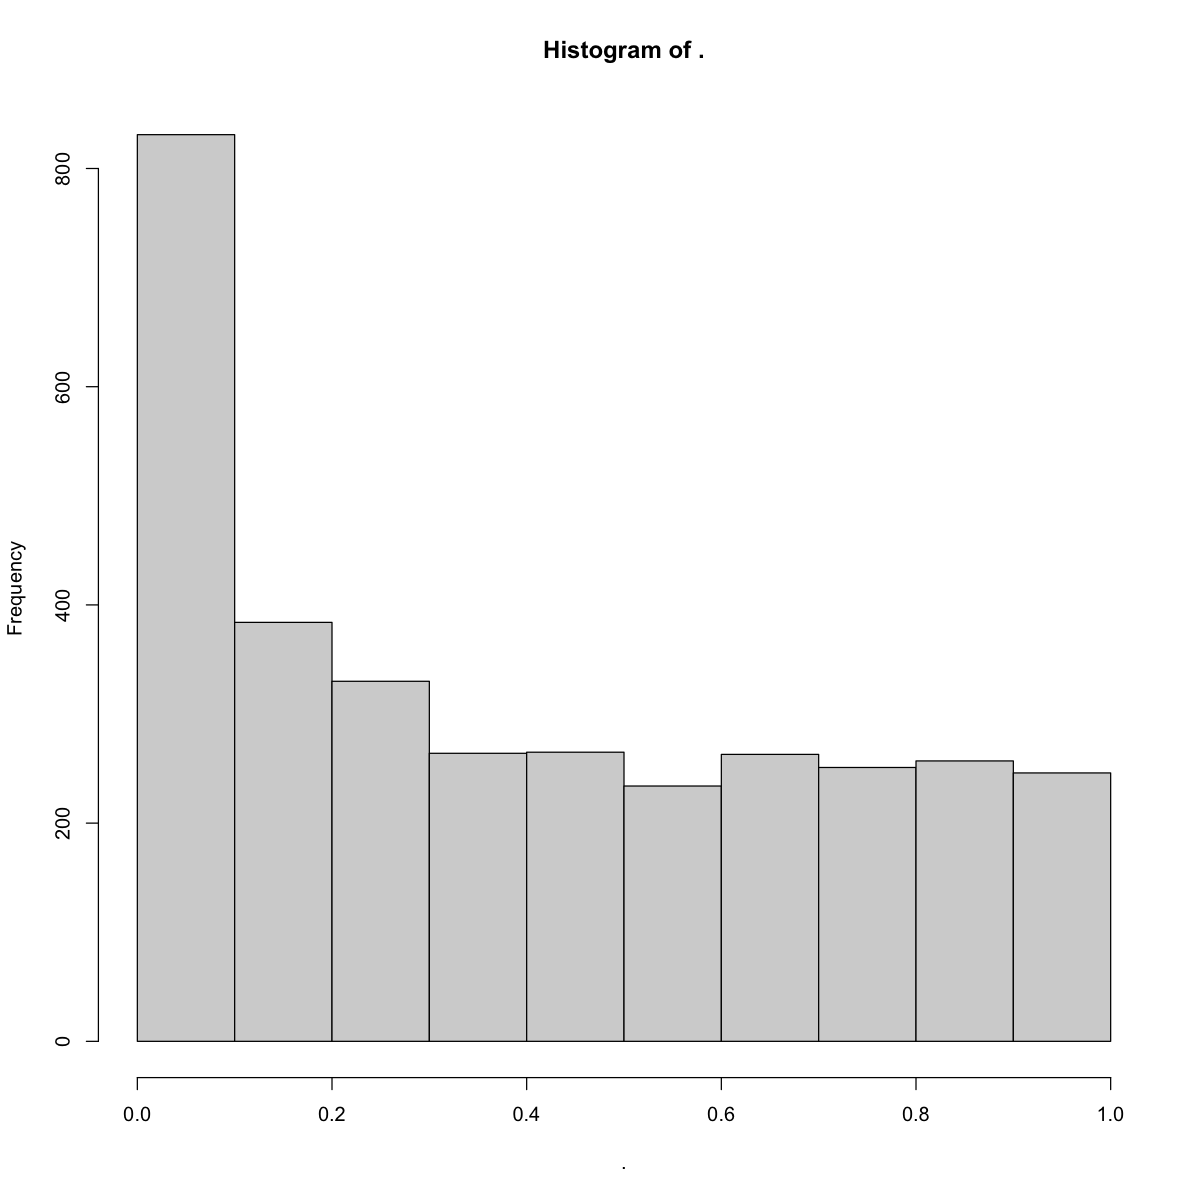

In [115]:
## Linear modeling with negative binomial. 
## Looking at Daudis - Remove Control cells. 

cells <- filter(Plots2, cluster.x == 0 & Edited_Index == "Edited") %>% with(cell) #Daudis in the edited condition
df <- (Plots2 %>% filter(cluster.x == 0& Edited_Index == "Edited")) #meta dataframe

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

#Filter on expression in at least 30% of cells
Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
#Extra filtering step. Mean raw counts of the gene > 2reads per cell - remove noisy low quality counts
genes <- names(which(rowSums(Exprs)/length(cells)> 2))


suppressWarnings({
FBXO11_lm_Daudi <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Dosage
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi<- FBXO11_lm_Daudi %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi %>% with(pval) %>% hist
FBXO11_lm_Daudi <- FBXO11_lm_Daudi %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

## Condition Dependent Linear Modeling

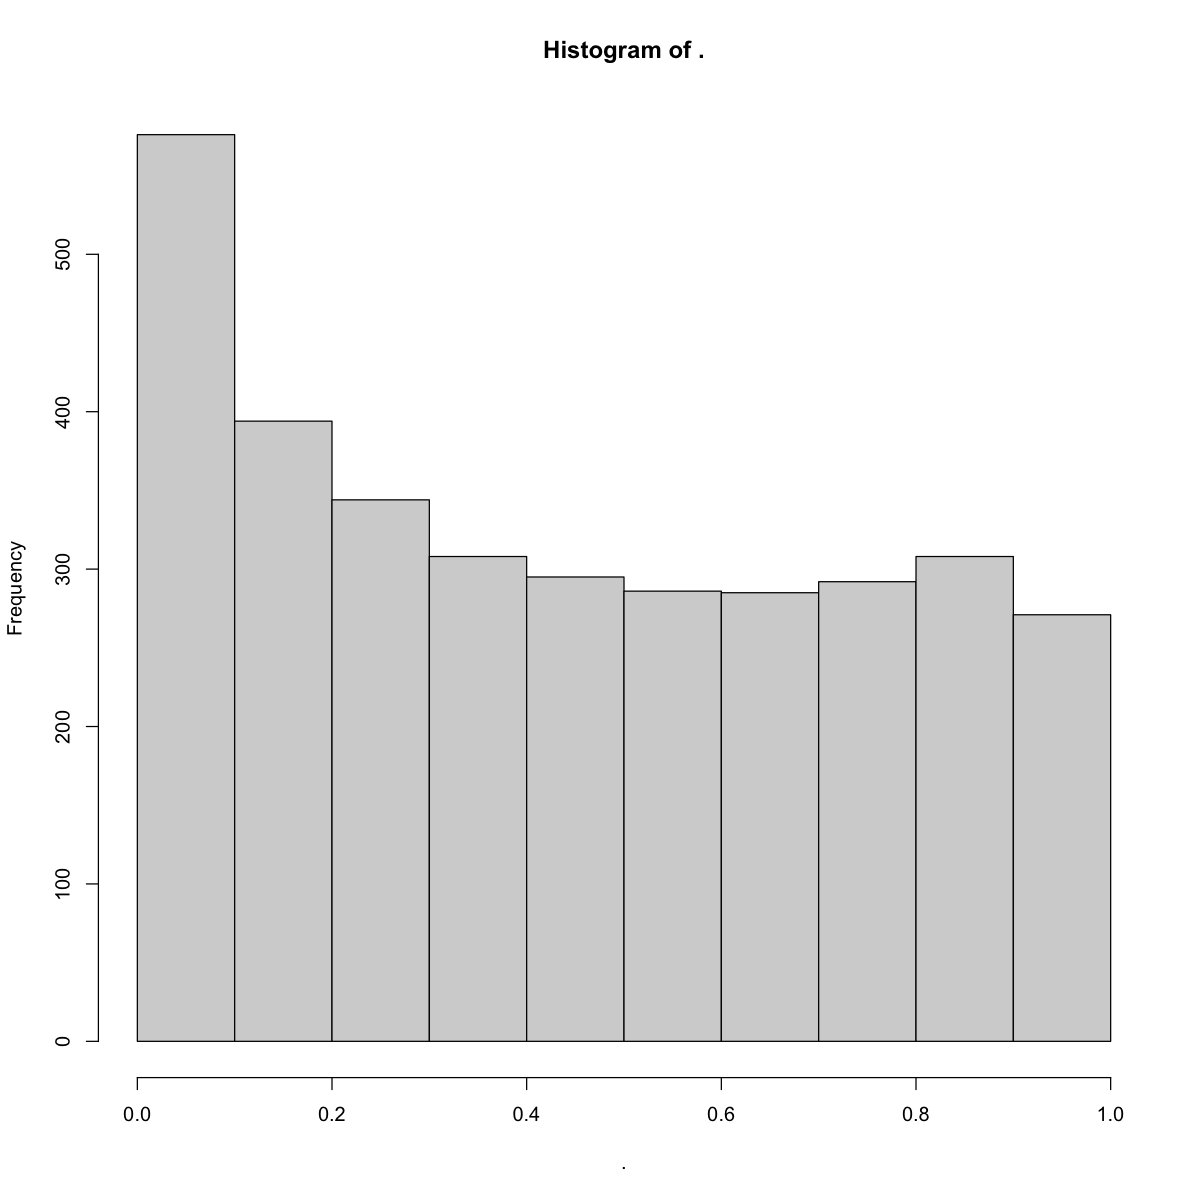

In [116]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 

cells <- filter(Plots2, cluster.x == 0) %>% with(cell)  #Daudis
df <- (Plots2 %>% filter(cell %in% cells))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(which(rowSums(Exprs)/length(cells)> 2))

suppressWarnings({
FBXO11_lm_Daudi_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi_Edited<- FBXO11_lm_Daudi_Edited %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi_Edited %>% with(pval) %>% hist
FBXO11_lm_Daudi_Edited <- FBXO11_lm_Daudi_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

# Statistical Modeling of ADTs

## Genoytpe ADT

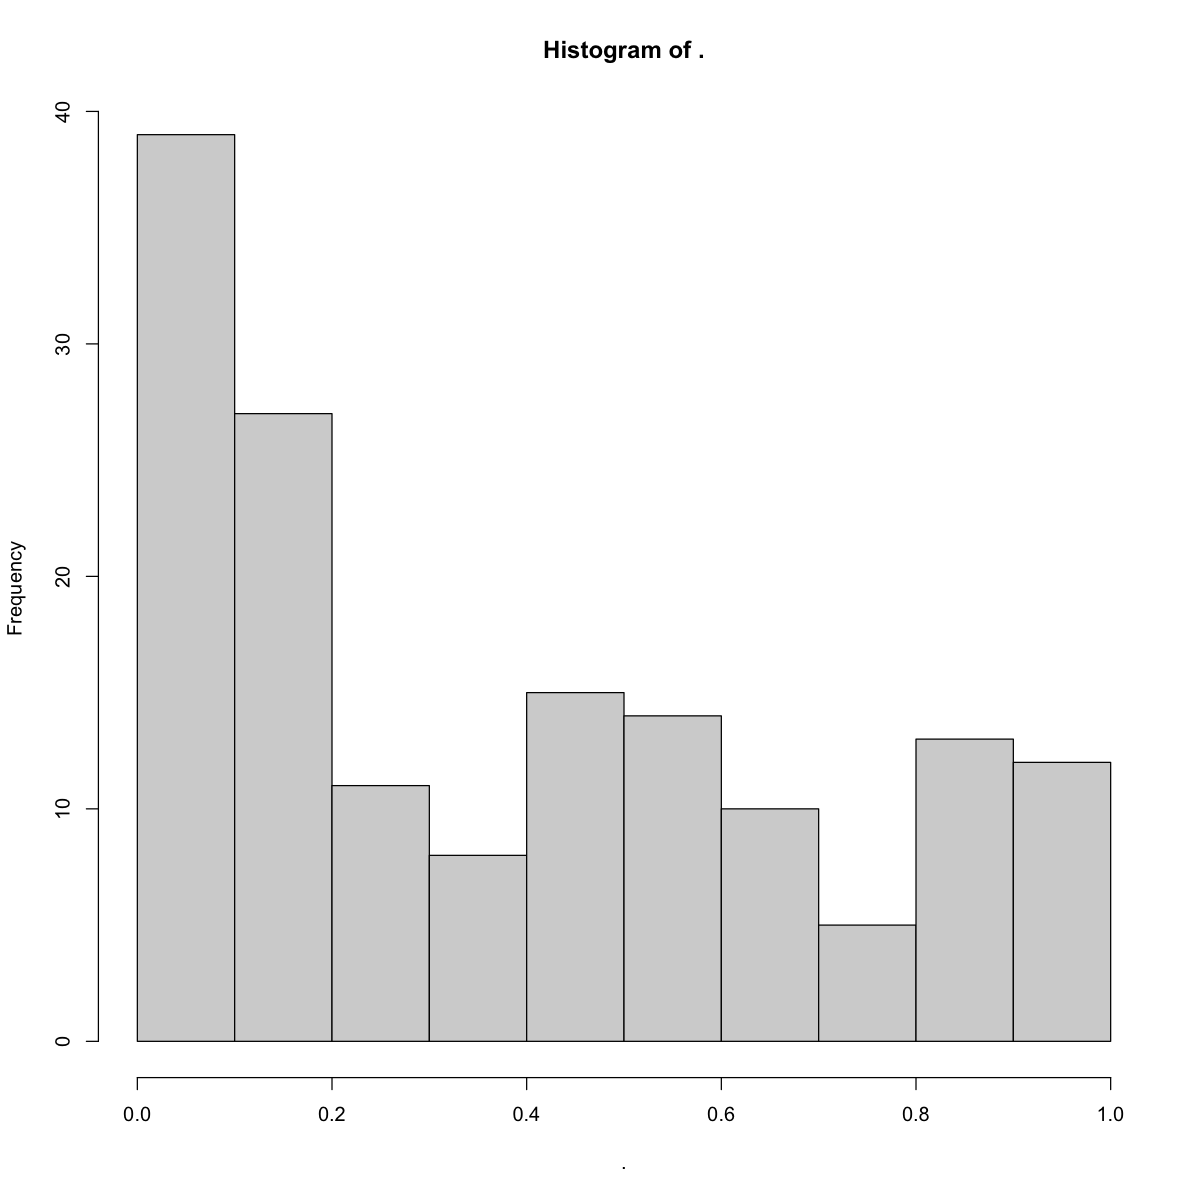

In [117]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- filter(Plots2, cluster.x == 0 & Edited_Index == "Edited") %>% with(cell) #Daudis and CRISPR condition
df <- (Plots2 %>% filter(cluster.x == 0 & Edited_Index == "Edited"))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
FBXO11_lm_Daudi_adt <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.x) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.x) + Plate + Dosage
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi_adt<- FBXO11_lm_Daudi_adt %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi_adt %>% with(pval) %>% hist
FBXO11_lm_Daudi_adt <- FBXO11_lm_Daudi_adt %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

## Condition ADT

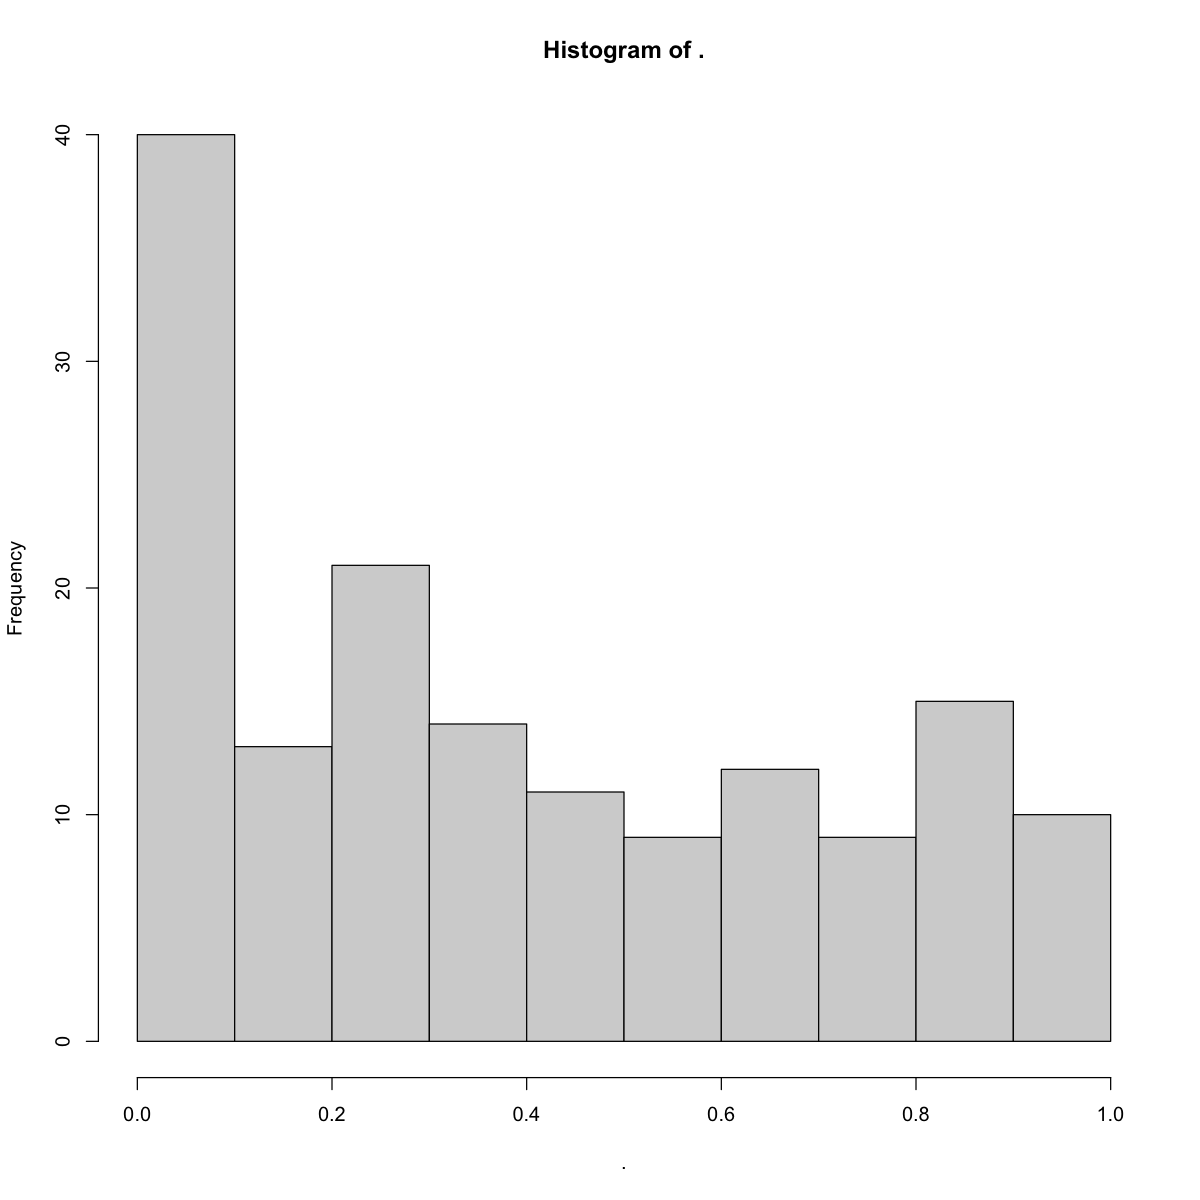

In [119]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- filter(Plots2, cluster.x == 0) %>% with(cell) #Daudis 
df <- (Plots2 %>% filter(cell %in% cells))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
FBXO11_lm_Daudi_adt_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.x) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.x) + Plate + Edited_Index
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi_adt_Edited<- FBXO11_lm_Daudi_adt_Edited %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi_adt_Edited %>% with(pval) %>% hist
FBXO11_lm_Daudi_adt_Edited <- FBXO11_lm_Daudi_adt_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

## Venn Diagram Comparing Results

In [126]:
library("ggvenn")

Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:Biostrings’:

    pattern




In [127]:
#Intesections and differences
featurex <- FBXO11_lm_Daudi %>% filter(padj < 0.05) %>% with(Genes)
featurey <- FBXO11_lm_Daudi_Edited %>% filter(padj < 0.05) %>% with(Genes)
featurexadt <- FBXO11_lm_Daudi_adt %>% filter(padj < 0.05) %>% with(Genes)
featureyadt <- FBXO11_lm_Daudi_adt_Edited %>% filter(padj < 0.05) %>% with(Genes)

In [128]:
intersect(featurex, featurey)
intersect(featurexadt, featureyadt)
setdiff(featurey, featurex)

[1] "MPST"     "HLA-DRB1" "WARS"     "FBXO11"   "AK2"      "RNF187"   "CSTB"

[1] "CD40"        "CD58"        "HLADR"       "CD131"       "HLADR_DP_DQ"
 [6] "CD72"        "CD37"        "CD275"       "CD49d"       "CD85j"      
[11] "CD27"        "CD29"        "CD21"        "CD63"

[1] "HLA-A"     "HSP90B1"   "HLA-B"     "NCF1"      "PDIA6"     "TRIB3"    
 [7] "HLA-C"     "IER3IP1"   "MT-ND1"    "DDX5"      "IGLV10-54" "PITX1"    
[13] "DNAJB1"

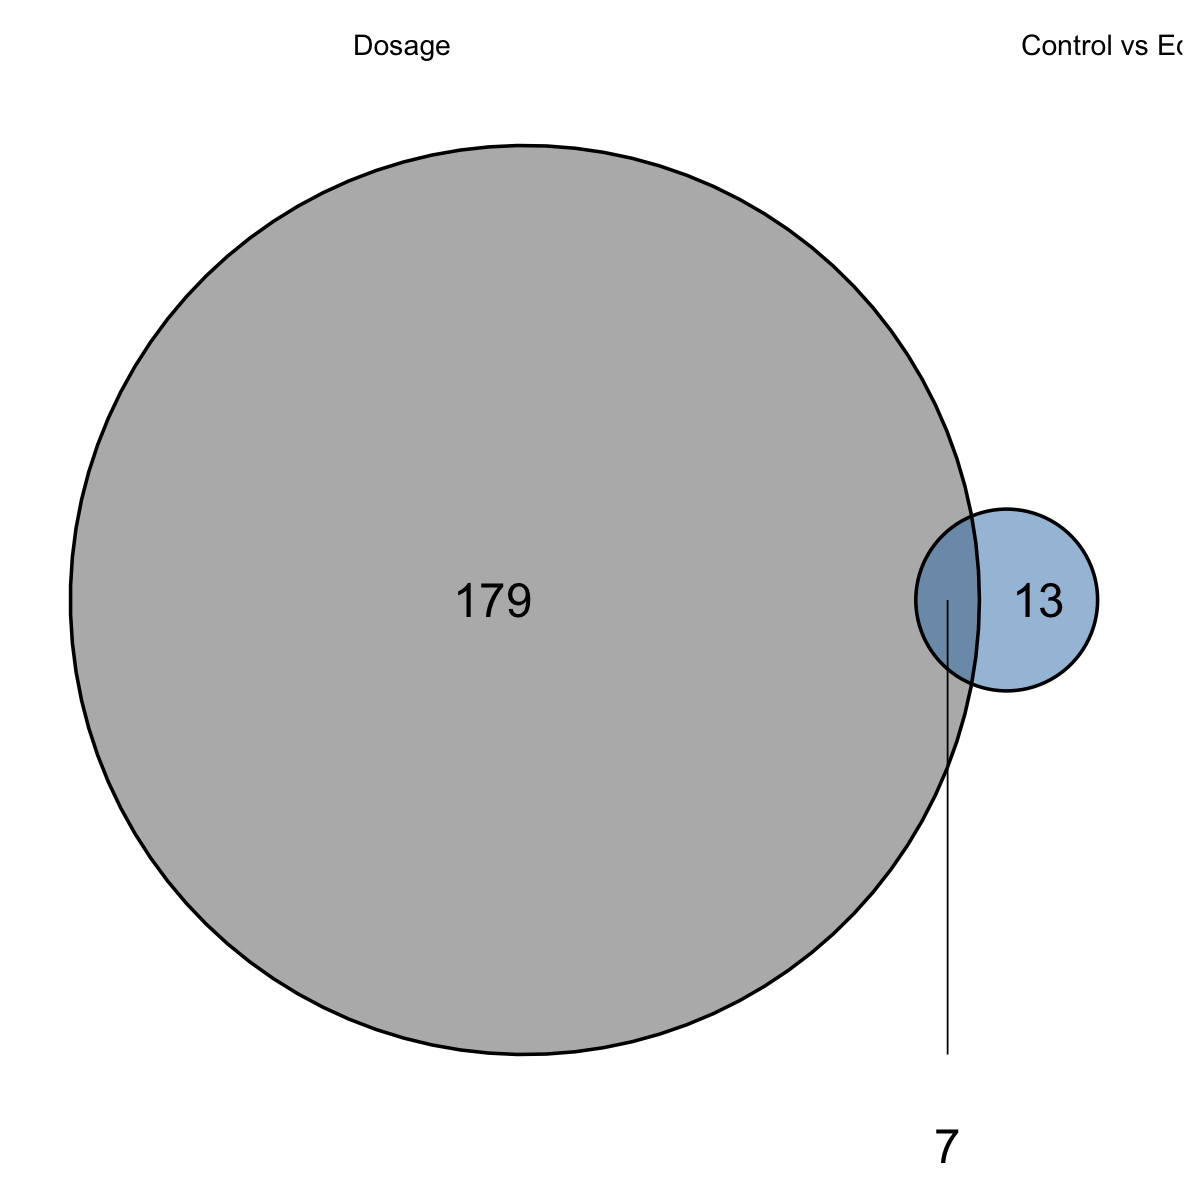

In [129]:
# fig.size(5,5)
g2 <- ggvenn(list("Dosage" = featurex, 
             "Control vs Edited" = featurey), 
      auto_scale = T, 
      fill_color = c("grey40","#377EB8"), 
      text_size = 10, 
      show_percentage = F)

plot(g2)

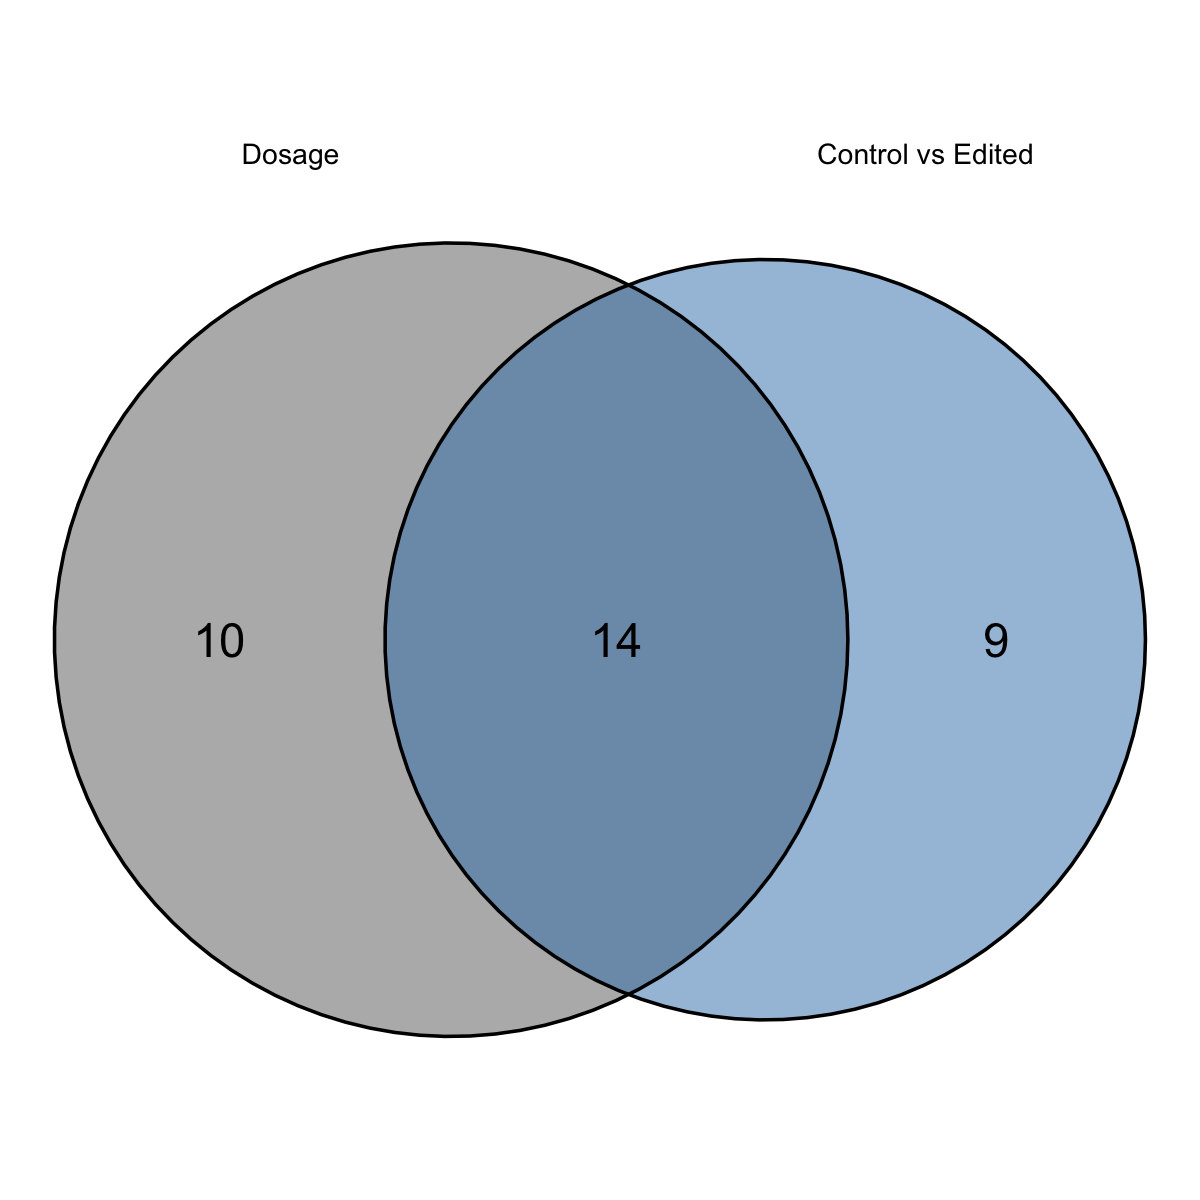

In [130]:
g2 <- ggvenn(list("Dosage" = featurexadt, 
             "Control vs Edited" = featureyadt), 
      auto_scale = T, 
      fill_color =c("grey40","#377EB8"), 
      text_size = 10, 
      show_percentage = F)


plot(g2)


In [131]:
jointviolindata <- rbind(mutate(FBXO11_lm_Daudi, group = "Dosage"), 
                         mutate(FBXO11_lm_Daudi_Edited, group = "Edited"))

jointviolindata_adt <-rbind(mutate(FBXO11_lm_Daudi_adt, group = "Dosage"), 
                         mutate(FBXO11_lm_Daudi_adt_Edited, group = "Edited"))

In [132]:
jointviolindata %>% filter(padj < 0.05 & group == "Edited") %>% dim
jointviolindata_adt %>% filter(padj < 0.05 & group == "Edited") %>% dim

[1] 20  5

[1] 23  5

In [133]:
jointviolindata %>% filter(Genes == "CD40")

Genes pval         beta       padj       group 
1 CD40  0.0009187758 -0.2352939 0.02443944 Dosage
2 CD40  0.0155463860 -0.4324566 0.30360646 Edited

In [134]:
fig.size(4,6)
adtlabels <- c("CD40", "HLADR", "IgM", "CD27", "CD22")
genelabels <- c("FBXO11", "CD40", "HLA-DRA", "IGLL1", "CD27")

g1 <- jointviolindata_adt %>% {
ggplot(.) + 
geom_point(aes(beta, -log10(pval), color = group)) +
geom_point(aes(beta, -log10(pval), color = group))+
theme_gy() + facet_wrap(~factor(group, levels = c("Edited", "Dosage")))+ 
scale_color_manual(values = c(
          
          "Edited" = "#377EB8",
          "Dosage" = "grey40")) + 
geom_label_repel(data = . %>% filter(Genes %in% adtlabels), 
               aes(beta, -log10(pval), label = Genes), size = 5) + 
    geom_point(data = . %>% filter(Genes %in% adtlabels), 
               aes(beta, -log10(pval), label = Genes), size = 2, color = "red") +
theme(legend.position = "none") + 
theme(legend.position = "none") + 
geom_hline(yintercept = -log10(jointviolindata_adt %>% arrange(pval)%>% filter(padj < 0.05) %>% tail(1) %>% with(pval)), linetype =2)+ 
ylab("-Log10(p-value)")+ 
    theme(axis.text.x = element_text(size = 20),axis.text.y = element_text(size = 20),
          strip.text = element_blank(), 
         panel.spacing = unit(1, "lines"))
    }


fig.size(4,6)
g2 <- jointviolindata %>% {
ggplot(.) + 
geom_point(aes(beta, -log10(pval), color = group)) +
geom_point(aes(beta, -log10(pval), color = group))+
theme_gy() + facet_wrap(~factor(group, levels = c("Edited", "Dosage")))+ 
scale_color_manual(values = c(
          "Edited" = "#377EB8",
          "Dosage" = "grey40")) + 
geom_label_repel(data = . %>% filter(Genes %in% genelabels), 
               aes(beta, -log10(pval), label = Genes), size = 5) + 
    geom_point(data = . %>% filter(Genes %in% genelabels), 
               aes(beta, -log10(pval), label = Genes), size = 2, color = "red") +
theme(legend.position = "none") + 
geom_hline(yintercept = -log10(jointviolindata %>% arrange(pval) %>% filter(padj < 0.05) %>% tail(1) %>% with(pval)), linetype =2)+ 
ylab("-Log10(p-value)") +
    theme(axis.text.x = element_text(size = 20),
          axis.text.y = element_text(size = 20),
          strip.text = element_blank(), 
         panel.spacing = unit(1, "lines"))



}

Warning message in geom_point(data = . %>% filter(Genes %in% adtlabels), aes(beta, :
“Ignoring unknown aesthetics: label”
Warning message in geom_point(data = . %>% filter(Genes %in% genelabels), aes(beta, :
“Ignoring unknown aesthetics: label”


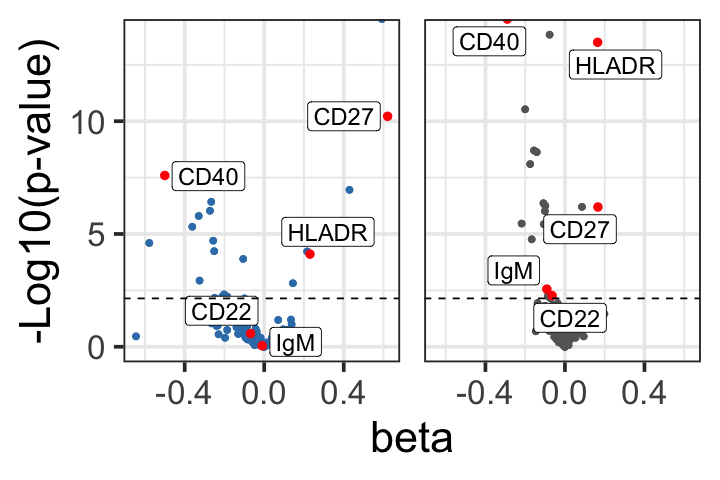

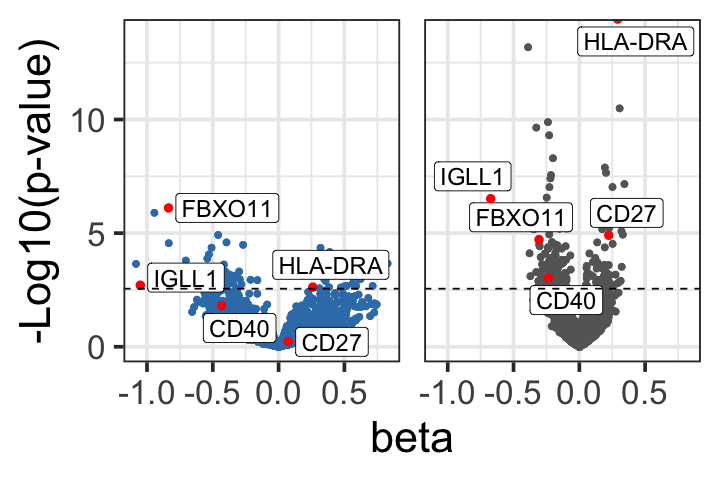

In [135]:
fig.size(4,6)
g1
g2